In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import statsmodels.formula.api as smf
import datetime
import seaborn as sns
from scipy.stats import sem, t
from matplotlib.lines import Line2D
%matplotlib inline
import sys,os
sys.path.append(os.path.realpath('..'))

# An Evaluation of the Impact of Leading Pedestrian Interval Signals in NYC

### Jeremy J. Sze
Hunter College, The City University of New York

[Jeremy.Sze@outlook.com](mailto:Jeremy.Sze@outlook.com)

[https://jeremysze.github.io](https://jeremysze.github.io)


# 1. Introduction

![visionzeronyc.png](../manuscripts/visionzeronyc.png)
![nyc_streets.jpg](../manuscripts/nyc_streets.jpg)
<sub> Source: https://www.flickr.com/photos/romankphoto/ </sub>

## Leading Pedestrian Interval Signals (LPIs)
![LPIS_visualization.png](../manuscripts/LPIS_visualization.png)

<sup> Source: https://nacto.org/publication/urban-street-design-guide/intersection-design-elements/traffic-signals/leading-pedestrian-interval/</sup>

![lpis%20map2.png](../manuscripts/lpis%20map2.png)

## NYPD Motor Vehicle Collisions
* From July 2012 to September 2018
* Approximately 1.35 million collisions were recorded

Includes: 
* collision outcomes, coordinates, streets, borough, zip code, time, vehicle type, contributing factors

Stratified:
* 11.00 p.m. to 4.59 a.m.
* 5.00 a.m. to 10.59 p.m.

In [34]:
fp = r"..\input_data\NYPD_Motor_Vehicle_Collisions.dta"
collisions_df = pd.read_stata(fp)

Checking that collisions_df is unique in `uniquekey`

In [35]:
collisions_df['uniquekey'].nunique()

1351213

In [36]:
collisions_df.shape[0]

1351215

collisions_df is NOT unique in `uniquekey`

In [37]:
collisions_df.drop_duplicates(subset = 'uniquekey', keep = False, inplace=True)

In [38]:
collisions_df['uniquekey'].nunique()

1351213

collisions_df is unique in `uniquekey` now

In [40]:
collisions_df.shape[0]

1351213

In [41]:
# Making a copy of time
new = collisions_df['time'].copy()
collisions_df['datetime'] =collisions_df["date"].str.cat(new, sep =" ") 

In [42]:
collisions_df['timelen'] = collisions_df['time'].str.len()

In [43]:
collisions_df['timelen'].value_counts()

5    1011881
4     339332
Name: timelen, dtype: int64

In [44]:
collisions_df.index[collisions_df['timelen'] == 0].tolist()

[]

In [45]:
collisions_df = collisions_df.drop(collisions_df.index[collisions_df.index[collisions_df['timelen'] == 0].tolist()])

In [46]:
collisions_df.head(3)

date  time        borough zipcode   latitude  longitude  \
0  09/24/2018  0:00  STATEN ISLAND   10306  40.573219 -74.106995   
1  09/24/2018  0:00                         40.612614 -74.076958   
2  09/24/2018  0:00                               NaN        NaN   

                 location                      onstreetname crossstreetname  \
0  (40.57322, -74.106995)  HYLAN BOULEVARD                      OTIS AVENUE   
1  (40.612614, -74.07696)  FLETCHER STREET                                    
2                                                                             

                              offstreetname  ...  contributingfactorvehicle4  \
0                                            ...                               
1                                            ...                               
2  161-18    140 street                      ...                               

   contributingfactorvehicle5  uniquekey                     vehicletypecode1  \
0                              3987045.0  Station Wagon/Sport Utility Vehicle   
1                              3987187.0  Station Wagon/Sport Utility Vehicle   
2                              3986792.0                                Sedan   

   vehicletypecode2  vehicletypecode3  vehicletypecode4  vehicletypecode5  \
0             Sedan                                                         
1             Sedan                                                         
2                                                                           

          datetime timelen  
0  09/24/2018 0:00       4  
1  09/24/2018 0:00       4  
2  09/24/2018 0:00       4  

[3 rows x 31 columns]

In [47]:
collisions_df['datetime_py'] = pd.to_datetime(collisions_df['datetime'], format= '%m/%d/%Y %H:%M')

In [48]:
collisions_df.head()

date  time        borough zipcode   latitude  longitude  \
0  09/24/2018  0:00  STATEN ISLAND   10306  40.573219 -74.106995   
1  09/24/2018  0:00                         40.612614 -74.076958   
2  09/24/2018  0:00                               NaN        NaN   
3  09/24/2018  0:00                         40.833981 -73.826347   
4  09/24/2018  0:05       BROOKLYN   11249  40.720074 -73.959846   

                 location                      onstreetname crossstreetname  \
0  (40.57322, -74.106995)  HYLAN BOULEVARD                      OTIS AVENUE   
1  (40.612614, -74.07696)  FLETCHER STREET                                    
2                                                                             
3   (40.83398, -73.82635)  BRUCKNER EXPRESSWAY                                
4  (40.720074, -73.95985)  WYTHE AVENUE                      NORTH 8 STREET   

                              offstreetname  ...  contributingfactorvehicle5  \
0                                            ...                               
1                                            ...                               
2  161-18    140 street                      ...                               
3                                            ...                               
4                                            ...                               

   uniquekey                     vehicletypecode1  vehicletypecode2  \
0  3987045.0  Station Wagon/Sport Utility Vehicle             Sedan   
1  3987187.0  Station Wagon/Sport Utility Vehicle             Sedan   
2  3986792.0                                Sedan                     
3  3986861.0                                Sedan             Sedan   
4  3986532.0                                Sedan             Sedan   

   vehicletypecode3  vehicletypecode4  vehicletypecode5         datetime  \
0                                                        09/24/2018 0:00   
1                                                        09/24/2018 0:00   
2                                                        09/24/2018 0:00   
3                                                        09/24/2018 0:00   
4                                                        09/24/2018 0:05   

  timelen         datetime_py  
0       4 2018-09-24 00:00:00  
1       4 2018-09-24 00:00:00  
2       4 2018-09-24 00:00:00  
3       4 2018-09-24 00:00:00  
4       4 2018-09-24 00:05:00  

[5 rows x 32 columns]

In [49]:
collisions_df['time_py'] = pd.to_datetime(collisions_df['time'], format= '%H:%M' ).dt.time

In [50]:
collisions_df[['time_py','time']].tail()

time_py  time
1351210  09:45:00  9:45
1351211  09:50:00  9:50
1351212  09:50:00  9:50
1351213  09:57:00  9:57
1351214  09:59:00  9:59

Collapse the data into outcomes per day

In [51]:
collisions_df['count'] = 1

source1: https://www.interviewqs.com/ddi_code_snippets/select_pandas_dataframe_rows_between_two_dates  <br>
source2: https://datatofish.com/if-condition-in-pandas-dataframe/

Set the index to datetime

In [53]:
collisions_df = collisions_df.set_index('datetime_py')

In [54]:
collisions_df.tail()

date  time    borough zipcode   latitude  \
datetime_py                                                           
2012-07-01 09:45:00  07/01/2012  9:45                           NaN   
2012-07-01 09:50:00  07/01/2012  9:50  MANHATTAN   10019  40.766777   
2012-07-01 09:50:00  07/01/2012  9:50     QUEENS   11001  40.736244   
2012-07-01 09:57:00  07/01/2012  9:57  MANHATTAN   10065  40.765244   
2012-07-01 09:59:00  07/01/2012  9:59      BRONX   10452  40.835396   

                     longitude                   location  \
datetime_py                                                 
2012-07-01 09:45:00        NaN                              
2012-07-01 09:50:00 -73.996765  (40.7667789, -73.9967618)   
2012-07-01 09:50:00 -73.702965  (40.7362448, -73.7029656)   
2012-07-01 09:57:00 -73.957870  (40.7652424, -73.9578679)   
2012-07-01 09:59:00 -73.920303    (40.835397, -73.920305)   

                                         onstreetname  \
datetime_py                                             
2012-07-01 09:45:00                                     
2012-07-01 09:50:00  WEST SIDE HIGHWAY                  
2012-07-01 09:50:00  265 STREET                         
2012-07-01 09:57:00  1 AVENUE                           
2012-07-01 09:59:00  EAST 167 STREET                    

                                      crossstreetname offstreetname  ...  \
datetime_py                                                          ...   
2012-07-01 09:45:00                                                  ...   
2012-07-01 09:50:00  WEST 50 STREET                                  ...   
2012-07-01 09:50:00  85 AVENUE                                       ...   
2012-07-01 09:57:00  EAST 68 STREET                                  ...   
2012-07-01 09:59:00  GERARD AVENUE                                   ...   

                     uniquekey   vehicletypecode1  \
datetime_py                                         
2012-07-01 09:45:00  2896726.0  PASSENGER VEHICLE   
2012-07-01 09:50:00    37635.0                VAN   
2012-07-01 09:50:00   219395.0  PASSENGER VEHICLE   
2012-07-01 09:57:00    44907.0  PASSENGER VEHICLE   
2012-07-01 09:59:00    85154.0  PASSENGER VEHICLE   

                                  vehicletypecode2  vehicletypecode3  \
datetime_py                                                            
2012-07-01 09:45:00                        UNKNOWN                     
2012-07-01 09:50:00  SPORT UTILITY / STATION WAGON                     
2012-07-01 09:50:00  SPORT UTILITY / STATION WAGON                     
2012-07-01 09:57:00                           TAXI                     
2012-07-01 09:59:00  SPORT UTILITY / STATION WAGON                     

                     vehicletypecode4  vehicletypecode5         datetime  \
datetime_py                                                                
2012-07-01 09:45:00                                      07/01/2012 9:45   
2012-07-01 09:50:00                                      07/01/2012 9:50   
2012-07-01 09:50:00                                      07/01/2012 9:50   
2012-07-01 09:57:00                                      07/01/2012 9:57   
2012-07-01 09:59:00                                      07/01/2012 9:59   

                     timelen   time_py count  
datetime_py                                   
2012-07-01 09:45:00        4  09:45:00     1  
2012-07-01 09:50:00        4  09:50:00     1  
2012-07-01 09:50:00        4  09:50:00     1  
2012-07-01 09:57:00        4  09:57:00     1  
2012-07-01 09:59:00        4  09:59:00     1  

[5 rows x 33 columns]

In [55]:
latenight_df = pd.DataFrame(collisions_df.between_time('23:00:00', '04:59:59'))

In [56]:
collisions_df['uniquekey'].nunique()

1351213

In [57]:
collisions_df.shape[0]

1351213

In [58]:
collisions_df.shape[1]

33

In [59]:
collisions_df1 = pd.merge(collisions_df,latenight_df[['uniquekey']], how='left', on = 'uniquekey', indicator = True, validate='1:1')

In [60]:
collisions_df1.shape[0]

1351213

In [61]:
collisions_df1.shape[1]

34

In [62]:
collisions_df1.head()

date  time        borough zipcode   latitude  longitude  \
0  09/24/2018  0:00  STATEN ISLAND   10306  40.573219 -74.106995   
1  09/24/2018  0:00                         40.612614 -74.076958   
2  09/24/2018  0:00                               NaN        NaN   
3  09/24/2018  0:00                         40.833981 -73.826347   
4  09/24/2018  0:05       BROOKLYN   11249  40.720074 -73.959846   

                 location                      onstreetname crossstreetname  \
0  (40.57322, -74.106995)  HYLAN BOULEVARD                      OTIS AVENUE   
1  (40.612614, -74.07696)  FLETCHER STREET                                    
2                                                                             
3   (40.83398, -73.82635)  BRUCKNER EXPRESSWAY                                
4  (40.720074, -73.95985)  WYTHE AVENUE                      NORTH 8 STREET   

                              offstreetname  ...  \
0                                            ...   
1                                            ...   
2  161-18    140 street                      ...   
3                                            ...   
4                                            ...   

                      vehicletypecode1  vehicletypecode2  vehicletypecode3  \
0  Station Wagon/Sport Utility Vehicle             Sedan                     
1  Station Wagon/Sport Utility Vehicle             Sedan                     
2                                Sedan                                       
3                                Sedan             Sedan                     
4                                Sedan             Sedan                     

   vehicletypecode4  vehicletypecode5         datetime  timelen   time_py  \
0                                      09/24/2018 0:00        4  00:00:00   
1                                      09/24/2018 0:00        4  00:00:00   
2                                      09/24/2018 0:00        4  00:00:00   
3                                      09/24/2018 0:00        4  00:00:00   
4                                      09/24/2018 0:05        4  00:05:00   

  count _merge  
0     1   both  
1     1   both  
2     1   both  
3     1   both  
4     1   both  

[5 rows x 34 columns]

In [63]:
collisions_df1['_merge'].value_counts()

left_only     1211546
both           139667
right_only          0
Name: _merge, dtype: int64

In [64]:
collisions_df1['latenight'] = np.where(collisions_df1['_merge']=='both', '1', '0')

In [65]:
collisions_df1['latenight'].dtypes

dtype('O')

Convert to int

In [66]:
collisions_df1['latenight'] = collisions_df1['latenight'].astype(int)

In [67]:
collisions_df1['latenight'].value_counts()

0    1211546
1     139667
Name: latenight, dtype: int64

In [68]:
collisions_df1['nonlatenight'] = 1-collisions_df1['latenight']

In [69]:
collisions_df1['nonlatenight'].value_counts()

1    1211546
0     139667
Name: nonlatenight, dtype: int64

In [70]:
collisions_df1['nonlatenight_count'] = np.multiply(collisions_df1['nonlatenight'],collisions_df['count'])
collisions_df1['nonlatenight_personsinjured'] = np.multiply(collisions_df1['nonlatenight'],collisions_df['numberofpersonsinjured'])
collisions_df1['nonlatenight_pedestriansinjured'] = np.multiply(collisions_df1['nonlatenight'],collisions_df['numberofpedestriansinjured'])
collisions_df1['nonlatenight_cyclistinjured'] = np.multiply(collisions_df1['nonlatenight'],collisions_df['numberofcyclistinjured'])
collisions_df1['nonlatenight_motoristinjured'] = np.multiply(collisions_df1['nonlatenight'],collisions_df['numberofmotoristinjured'])

In [71]:
collisions_df1['latenight_count'] = np.multiply(collisions_df1['latenight'],collisions_df['count'])
collisions_df1['latenight_personsinjured'] = np.multiply(collisions_df1['latenight'],collisions_df['numberofpersonsinjured'])
collisions_df1['latenight_pedestriansinjured'] = np.multiply(collisions_df1['latenight'],collisions_df['numberofpedestriansinjured'])
collisions_df1['latenight_cyclistinjured'] = np.multiply(collisions_df1['latenight'],collisions_df['numberofcyclistinjured'])
collisions_df1['latenight_motoristinjured'] = np.multiply(collisions_df1['latenight'],collisions_df['numberofmotoristinjured'])

In [72]:
collapsed_collisions_df = pd.DataFrame(collisions_df1.groupby('date').agg({
    'count': sum, # sum number of collisions per day
    'numberofpersonsinjured': sum,
    'numberofpedestriansinjured': sum,
    'numberofcyclistinjured': sum,
    'numberofmotoristinjured': sum,
    'nonlatenight_count': sum, # sum number of collisions per day
    'nonlatenight_personsinjured': sum,
    'nonlatenight_pedestriansinjured': sum,
    'nonlatenight_cyclistinjured': sum,
    'nonlatenight_motoristinjured': sum,    
    'latenight_count': sum, # sum number of collisions per day
    'latenight_personsinjured': sum,
    'latenight_pedestriansinjured': sum,
    'latenight_cyclistinjured': sum,
    'latenight_motoristinjured': sum,  
})).reset_index()

In [73]:
collapsed_collisions_df.head()

date  count  numberofpersonsinjured  numberofpedestriansinjured  \
0  01/01/2013    381                   157.0                        34.0   
1  01/01/2014    399                   165.0                        24.0   
2  01/01/2015    395                   130.0                        16.0   
3  01/01/2016    394                   124.0                        13.0   
4  01/01/2017    483                   167.0                        25.0   

   numberofcyclistinjured  numberofmotoristinjured  nonlatenight_count  \
0                     3.0                    120.0                 266   
1                     2.0                    139.0                 292   
2                     1.0                    113.0                 274   
3                     5.0                    107.0                 280   
4                     6.0                    140.0                 322   

   nonlatenight_personsinjured  nonlatenight_pedestriansinjured  \
0                         94.0                             15.0   
1                         93.0                             18.0   
2                         88.0                             13.0   
3                         83.0                              7.0   
4                        113.0                             14.0   

   nonlatenight_cyclistinjured  nonlatenight_motoristinjured  latenight_count  \
0                          2.0                          77.0              115   
1                          2.0                          73.0              107   
2                          0.0                          75.0              121   
3                          2.0                          74.0              114   
4                          5.0                          98.0              161   

   latenight_personsinjured  latenight_pedestriansinjured  \
0                      63.0                          19.0   
1                      72.0                           6.0   
2                      42.0                           3.0   
3                      41.0                           6.0   
4                      54.0                          11.0   

   latenight_cyclistinjured  latenight_motoristinjured  
0                       1.0                       43.0  
1                       0.0                       66.0  
2                       1.0                       38.0  
3                       3.0                       33.0  
4                       1.0                       42.0

In [74]:
collapsed_collisions_df = collapsed_collisions_df.drop(collapsed_collisions_df.index[0])

In [75]:
collapsed_collisions_df['datelen'] = collapsed_collisions_df['date'].str.len()

In [76]:
collapsed_collisions_df['datelen'].value_counts()

10    2276
Name: datelen, dtype: int64

In [77]:
collapsed_collisions_df.dtypes

date                                object
count                                int64
numberofpersonsinjured             float64
numberofpedestriansinjured         float64
numberofcyclistinjured             float64
numberofmotoristinjured            float64
nonlatenight_count                   int64
nonlatenight_personsinjured        float64
nonlatenight_pedestriansinjured    float64
nonlatenight_cyclistinjured        float64
nonlatenight_motoristinjured       float64
latenight_count                      int64
latenight_personsinjured           float64
latenight_pedestriansinjured       float64
latenight_cyclistinjured           float64
latenight_motoristinjured          float64
datelen                              int64
dtype: object

Format the date variable

In [78]:
collapsed_collisions_df['date_py'] = pd.to_datetime(collapsed_collisions_df['date'], format='%m/%d/%Y')

In [79]:
collapsed_collisions_df.head()

date  count  numberofpersonsinjured  numberofpedestriansinjured  \
1  01/01/2014    399                   165.0                        24.0   
2  01/01/2015    395                   130.0                        16.0   
3  01/01/2016    394                   124.0                        13.0   
4  01/01/2017    483                   167.0                        25.0   
5  01/01/2018    443                   120.0                        12.0   

   numberofcyclistinjured  numberofmotoristinjured  nonlatenight_count  \
1                     2.0                    139.0                 292   
2                     1.0                    113.0                 274   
3                     5.0                    107.0                 280   
4                     6.0                    140.0                 322   
5                     3.0                    105.0                 308   

   nonlatenight_personsinjured  nonlatenight_pedestriansinjured  \
1                         93.0                             18.0   
2                         88.0                             13.0   
3                         83.0                              7.0   
4                        113.0                             14.0   
5                         80.0                             10.0   

   nonlatenight_cyclistinjured  nonlatenight_motoristinjured  latenight_count  \
1                          2.0                          73.0              107   
2                          0.0                          75.0              121   
3                          2.0                          74.0              114   
4                          5.0                          98.0              161   
5                          2.0                          68.0              135   

   latenight_personsinjured  latenight_pedestriansinjured  \
1                      72.0                           6.0   
2                      42.0                           3.0   
3                      41.0                           6.0   
4                      54.0                          11.0   
5                      40.0                           2.0   

   latenight_cyclistinjured  latenight_motoristinjured  datelen    date_py  
1                       0.0                       66.0       10 2014-01-01  
2                       1.0                       38.0       10 2015-01-01  
3                       3.0                       33.0       10 2016-01-01  
4                       1.0                       42.0       10 2017-01-01  
5                       1.0                       37.0       10 2018-01-01

Set date_py as the index

In [80]:
collapsed_collisions_df = collapsed_collisions_df.set_index('date_py')

In [81]:
collapsed_collisions_df.head()

date  count  numberofpersonsinjured  \
date_py                                                 
2014-01-01  01/01/2014    399                   165.0   
2015-01-01  01/01/2015    395                   130.0   
2016-01-01  01/01/2016    394                   124.0   
2017-01-01  01/01/2017    483                   167.0   
2018-01-01  01/01/2018    443                   120.0   

            numberofpedestriansinjured  numberofcyclistinjured  \
date_py                                                          
2014-01-01                        24.0                     2.0   
2015-01-01                        16.0                     1.0   
2016-01-01                        13.0                     5.0   
2017-01-01                        25.0                     6.0   
2018-01-01                        12.0                     3.0   

            numberofmotoristinjured  nonlatenight_count  \
date_py                                                   
2014-01-01                    139.0                 292   
2015-01-01                    113.0                 274   
2016-01-01                    107.0                 280   
2017-01-01                    140.0                 322   
2018-01-01                    105.0                 308   

            nonlatenight_personsinjured  nonlatenight_pedestriansinjured  \
date_py                                                                    
2014-01-01                         93.0                             18.0   
2015-01-01                         88.0                             13.0   
2016-01-01                         83.0                              7.0   
2017-01-01                        113.0                             14.0   
2018-01-01                         80.0                             10.0   

            nonlatenight_cyclistinjured  nonlatenight_motoristinjured  \
date_py                                                                 
2014-01-01                          2.0                          73.0   
2015-01-01                          0.0                          75.0   
2016-01-01                          2.0                          74.0   
2017-01-01                          5.0                          98.0   
2018-01-01                          2.0                          68.0   

            latenight_count  latenight_personsinjured  \
date_py                                                 
2014-01-01              107                      72.0   
2015-01-01              121                      42.0   
2016-01-01              114                      41.0   
2017-01-01              161                      54.0   
2018-01-01              135                      40.0   

            latenight_pedestriansinjured  latenight_cyclistinjured  \
date_py                                                              
2014-01-01                           6.0                       0.0   
2015-01-01                           3.0                       1.0   
2016-01-01                           6.0                       3.0   
2017-01-01                          11.0                       1.0   
2018-01-01                           2.0                       1.0   

            latenight_motoristinjured  datelen  
date_py                                         
2014-01-01                       66.0       10  
2015-01-01                       38.0       10  
2016-01-01                       33.0       10  
2017-01-01                       42.0       10  
2018-01-01                       37.0       10

In [82]:
collapsed_collisions_df['year'] = collapsed_collisions_df.index.year
collapsed_collisions_df['quarter'] = collapsed_collisions_df.index.quarter
collapsed_collisions_df['month'] = collapsed_collisions_df.index.month
collapsed_collisions_df['weekdayname'] = collapsed_collisions_df.index.weekday_name

In [83]:
collapsed_collisions_df.head()

date  count  numberofpersonsinjured  \
date_py                                                 
2014-01-01  01/01/2014    399                   165.0   
2015-01-01  01/01/2015    395                   130.0   
2016-01-01  01/01/2016    394                   124.0   
2017-01-01  01/01/2017    483                   167.0   
2018-01-01  01/01/2018    443                   120.0   

            numberofpedestriansinjured  numberofcyclistinjured  \
date_py                                                          
2014-01-01                        24.0                     2.0   
2015-01-01                        16.0                     1.0   
2016-01-01                        13.0                     5.0   
2017-01-01                        25.0                     6.0   
2018-01-01                        12.0                     3.0   

            numberofmotoristinjured  nonlatenight_count  \
date_py                                                   
2014-01-01                    139.0                 292   
2015-01-01                    113.0                 274   
2016-01-01                    107.0                 280   
2017-01-01                    140.0                 322   
2018-01-01                    105.0                 308   

            nonlatenight_personsinjured  nonlatenight_pedestriansinjured  \
date_py                                                                    
2014-01-01                         93.0                             18.0   
2015-01-01                         88.0                             13.0   
2016-01-01                         83.0                              7.0   
2017-01-01                        113.0                             14.0   
2018-01-01                         80.0                             10.0   

            nonlatenight_cyclistinjured  ...  latenight_count  \
date_py                                  ...                    
2014-01-01                          2.0  ...              107   
2015-01-01                          0.0  ...              121   
2016-01-01                          2.0  ...              114   
2017-01-01                          5.0  ...              161   
2018-01-01                          2.0  ...              135   

            latenight_personsinjured  latenight_pedestriansinjured  \
date_py                                                              
2014-01-01                      72.0                           6.0   
2015-01-01                      42.0                           3.0   
2016-01-01                      41.0                           6.0   
2017-01-01                      54.0                          11.0   
2018-01-01                      40.0                           2.0   

            latenight_cyclistinjured  latenight_motoristinjured  datelen  \
date_py                                                                    
2014-01-01                       0.0                       66.0       10   
2015-01-01                       1.0                       38.0       10   
2016-01-01                       3.0                       33.0       10   
2017-01-01                       1.0                       42.0       10   
2018-01-01                       1.0                       37.0       10   

            year  quarter  month  weekdayname  
date_py                                        
2014-01-01  2014        1      1    Wednesday  
2015-01-01  2015        1      1     Thursday  
2016-01-01  2016        1      1       Friday  
2017-01-01  2017        1      1       Sunday  
2018-01-01  2018        1      1       Monday  

[5 rows x 21 columns]

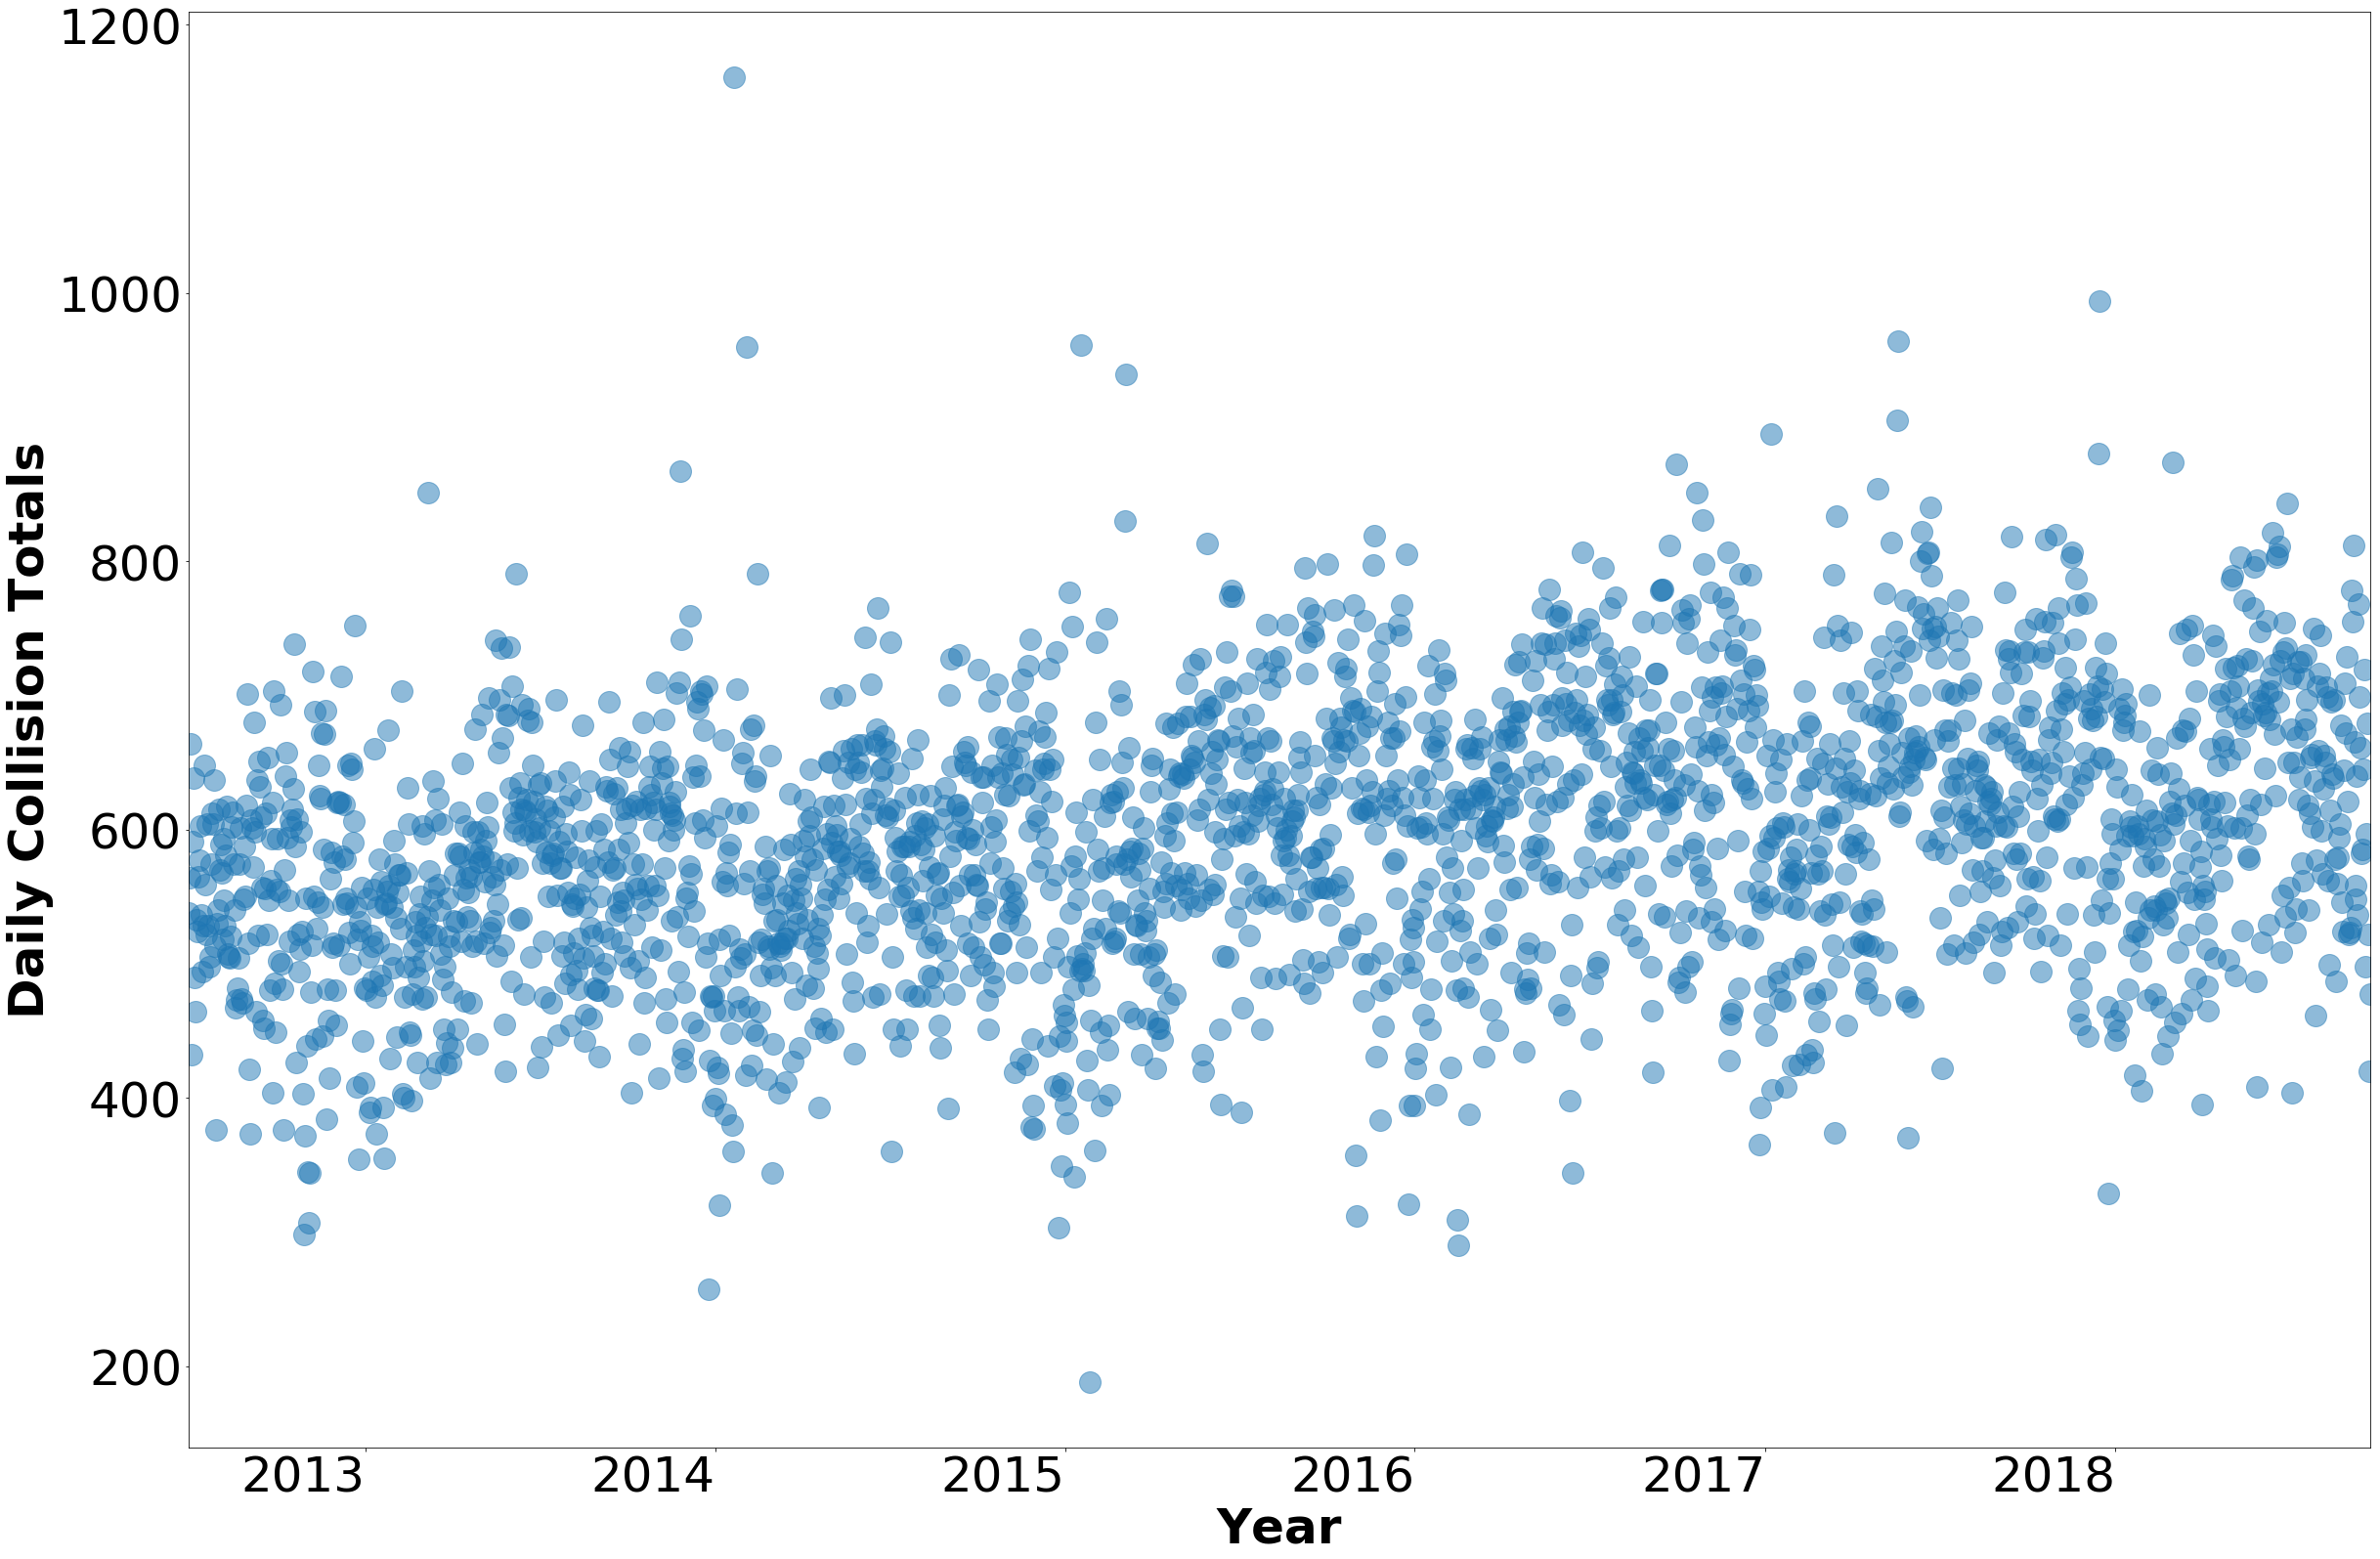

In [84]:
plt.rcParams['xtick.labelsize']=50
plt.rcParams['ytick.labelsize']=50

ax = collapsed_collisions_df['count'].plot(marker='o', alpha=0.5, markersize=22 , linestyle='None', figsize=(40,30), subplots=True)
plt.ylabel('Daily Collision Totals', fontsize=50,fontweight='bold')
plt.xlabel('Year', fontsize=50,fontweight='bold')
plt.xticks(rotation='horizontal')


plt.savefig('../manuscripts/dailycollisions.png', bbox_inches='tight')


![dailycollisions.png](../manuscripts/dailycollisions.png)

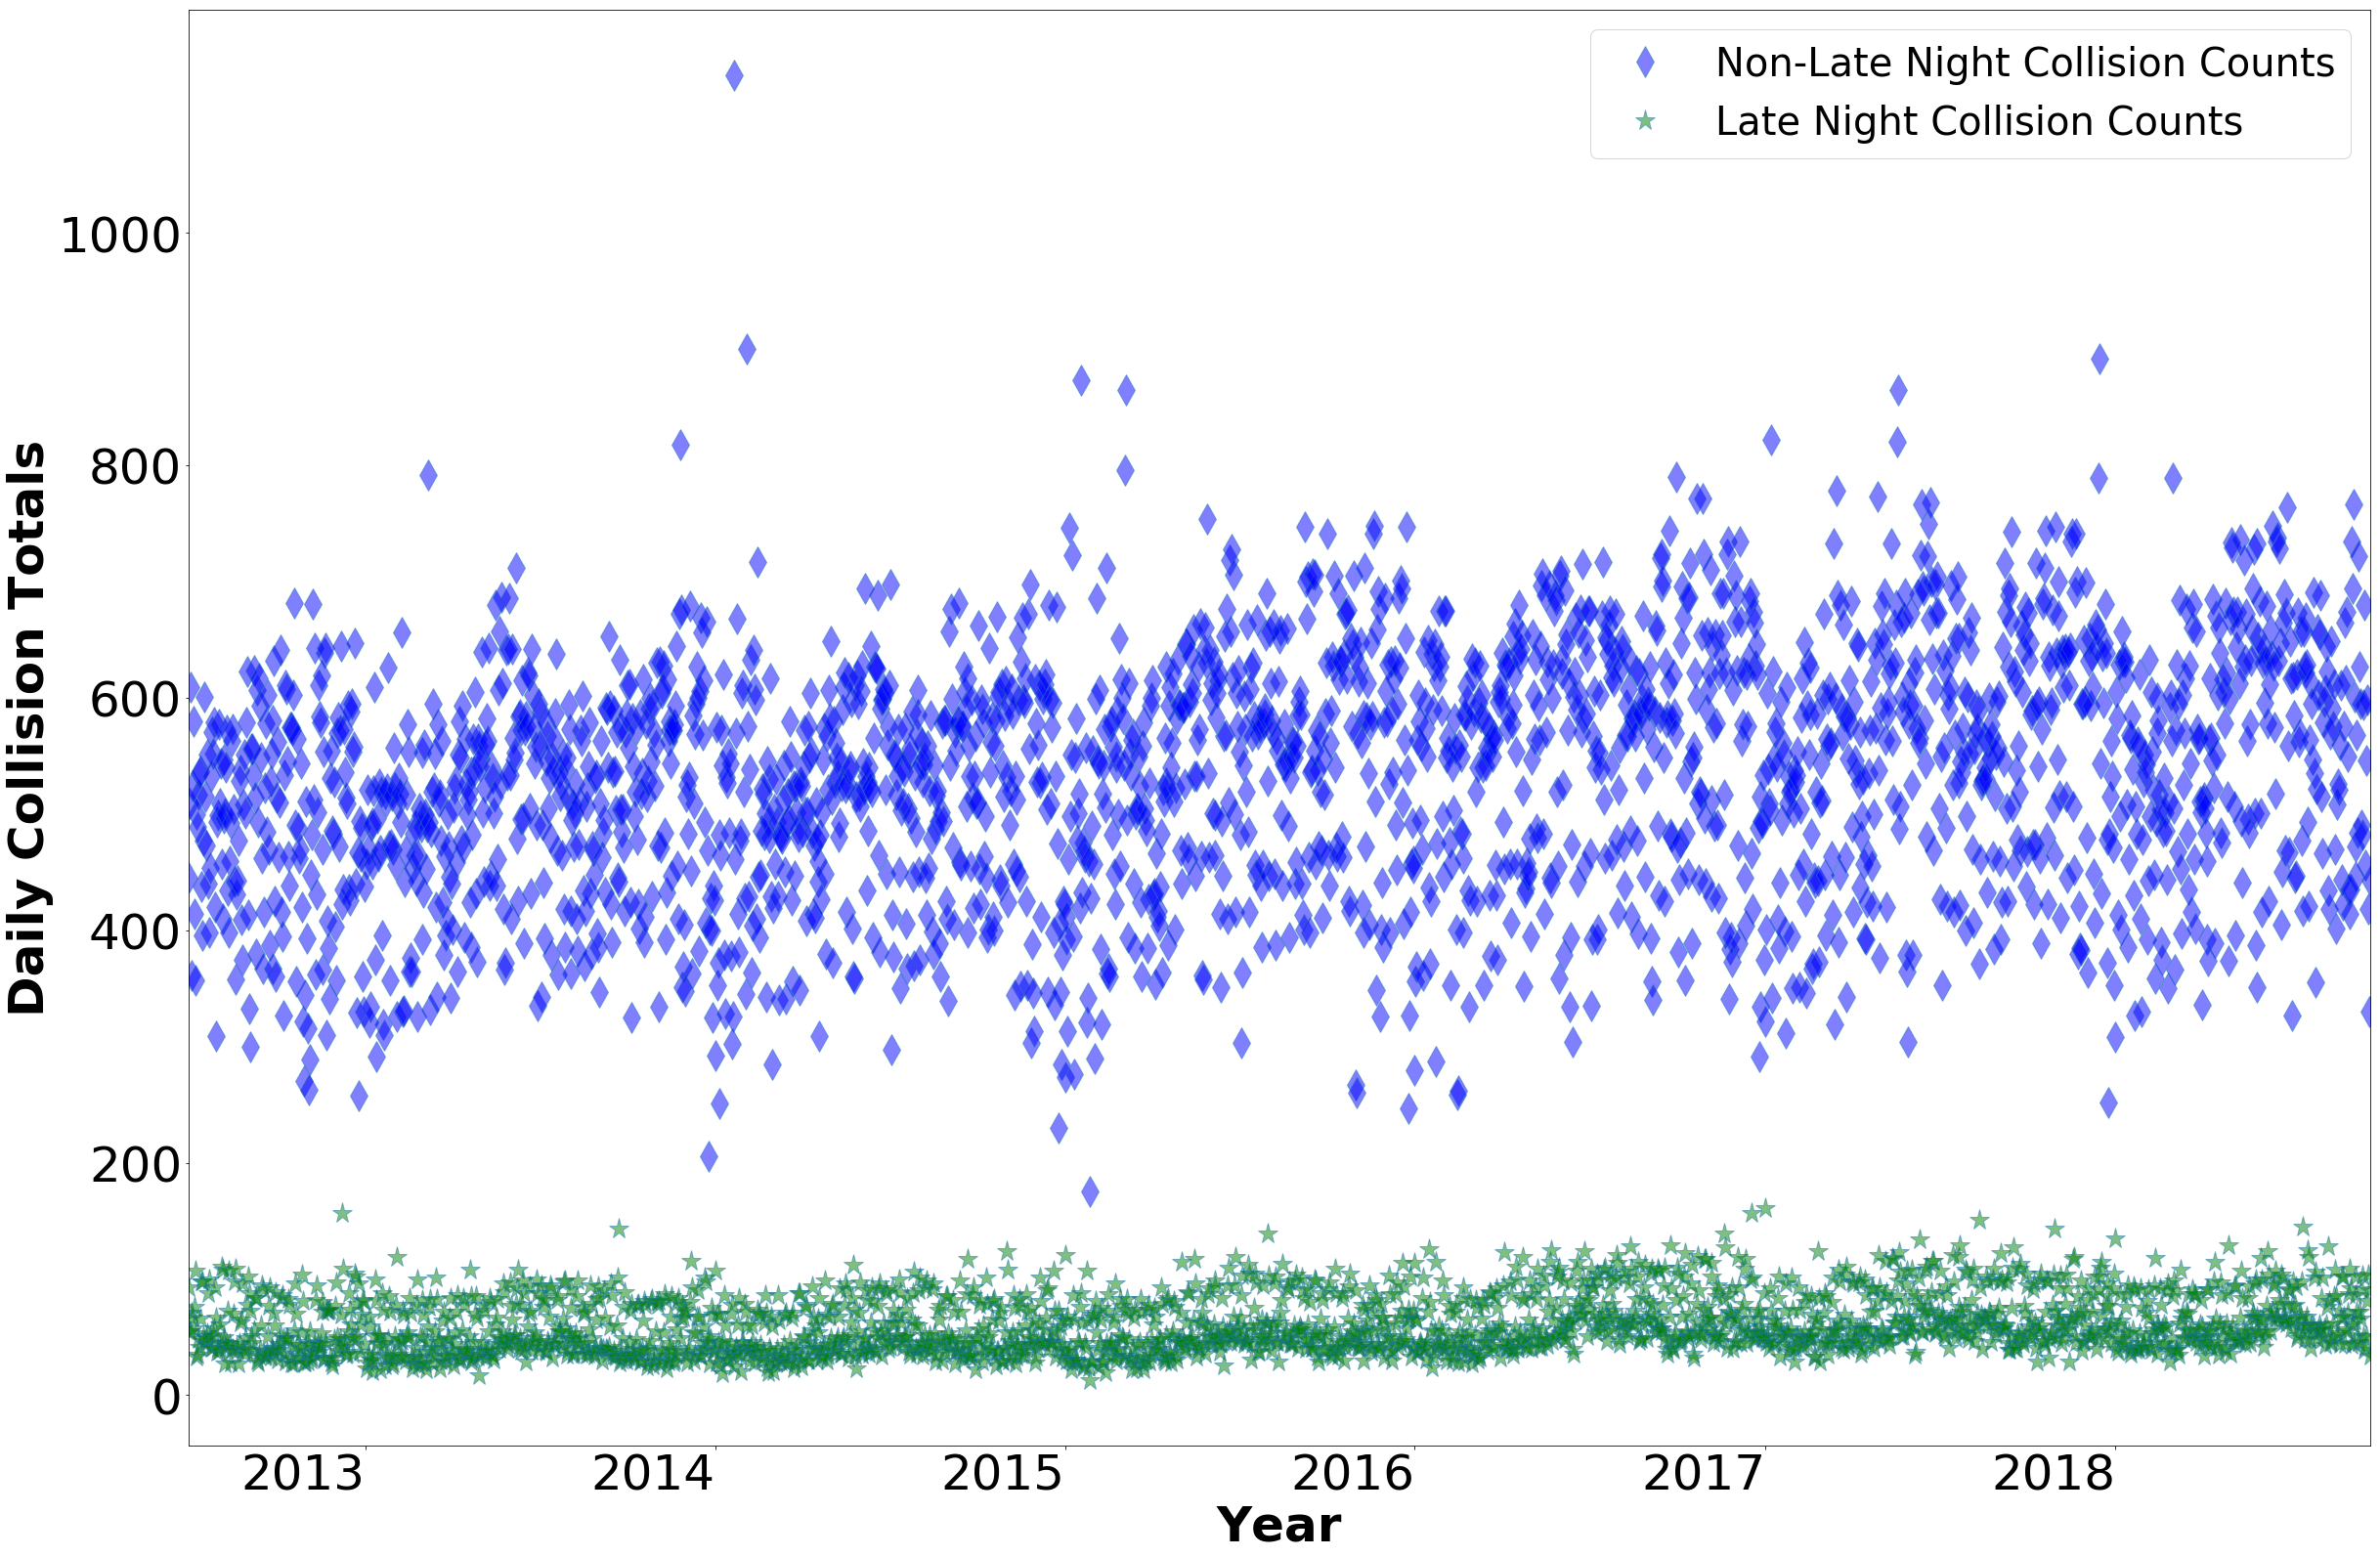

In [85]:
plt.rcParams['xtick.labelsize']=50
plt.rcParams['ytick.labelsize']=50

ax = collapsed_collisions_df['nonlatenight_count'].plot(marker='d',markerfacecolor='blue', alpha=0.5, markersize=22 , linestyle='None', figsize=(40,30), subplots=True)
ax = collapsed_collisions_df['latenight_count'].plot(marker='*',markerfacecolor='green', alpha=0.5, markersize=22 , linestyle='None', figsize=(40,30), subplots=True)

plt.ylabel('Daily Collision Totals', fontsize=50,fontweight='bold')
plt.xlabel('Year', fontsize=50,fontweight='bold')
plt.legend(('Non-Late Night Collision Counts','Late Night Collision Counts'), loc='upper right',prop={'size':40})
plt.xticks(rotation='horizontal')

plt.savefig('../manuscripts/dailycollisions_stratified.png', bbox_inches='tight')


![dailycollisions_stratified.png](../manuscripts/dailycollisions_stratified.png)

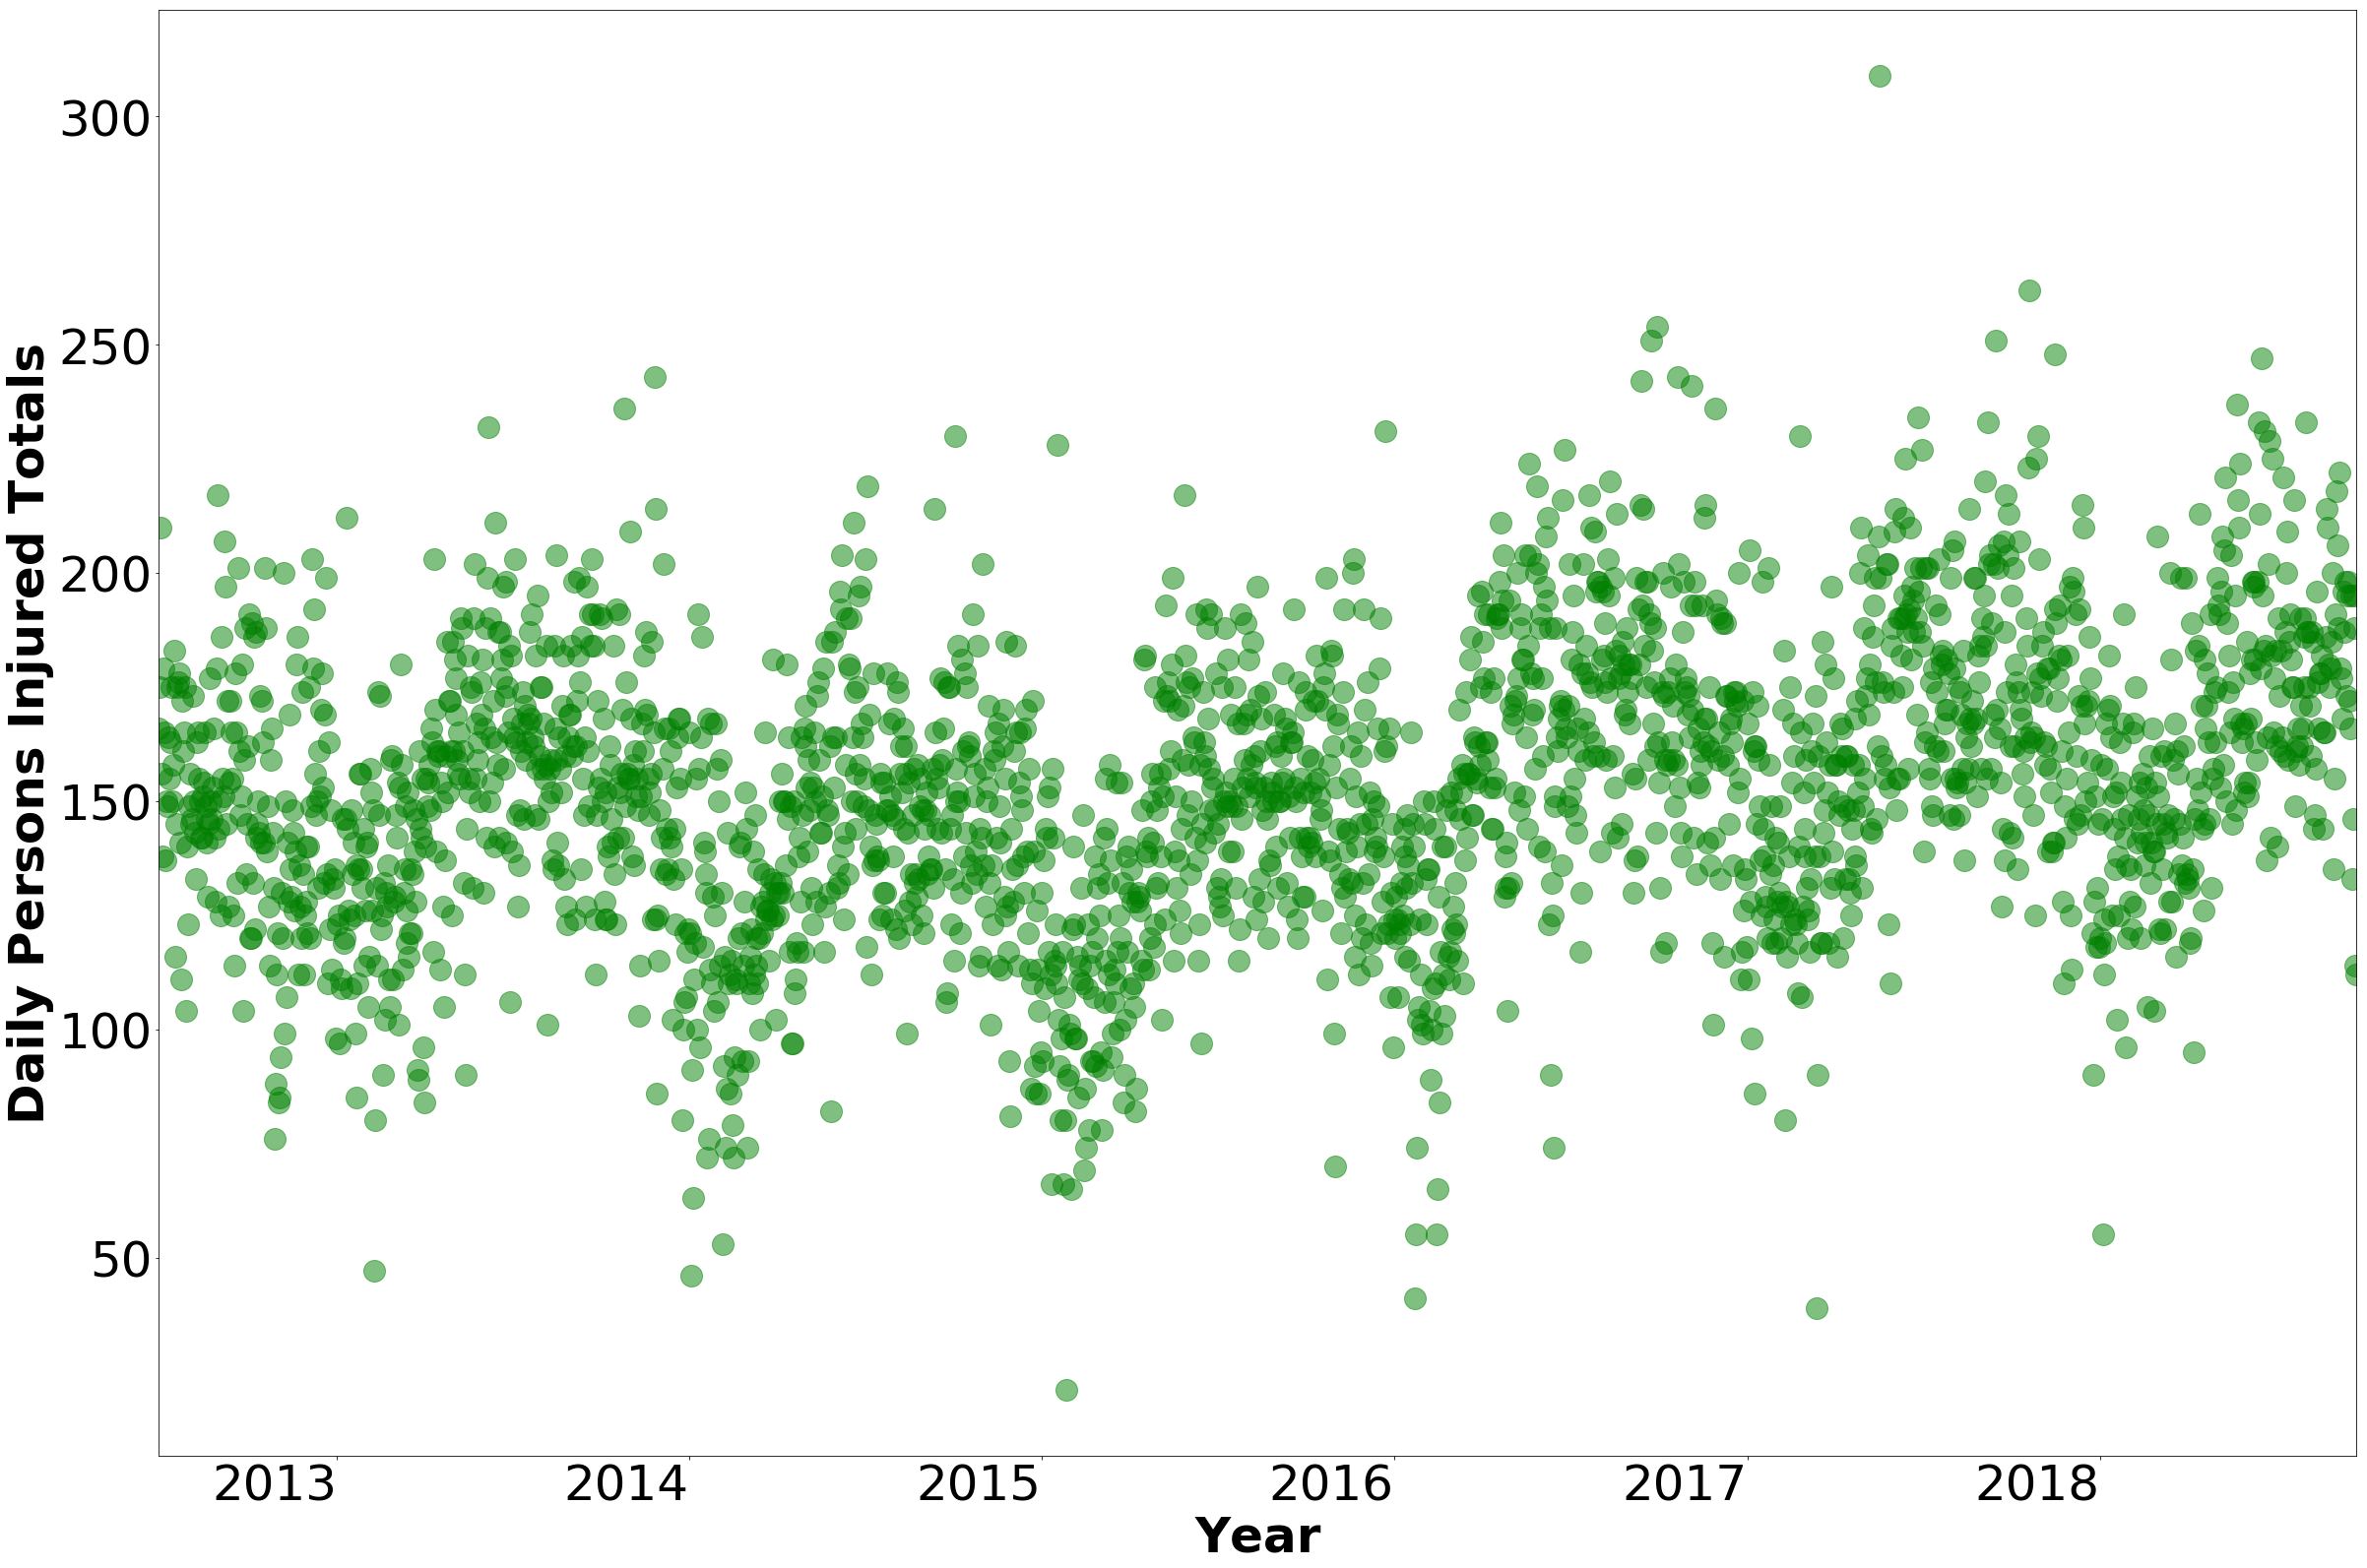

In [86]:
plt.rcParams['xtick.labelsize']=50
plt.rcParams['ytick.labelsize']=50

ax = collapsed_collisions_df['numberofpersonsinjured'].plot(marker='o', color='green', alpha=0.5, markersize=22 , linestyle='None', figsize=(40,30), subplots=True)

plt.ylabel('Daily Persons Injured Totals', fontsize=50,fontweight='bold')
plt.xlabel('Year', fontsize=50,fontweight='bold')
plt.xticks(rotation='horizontal')

plt.savefig('../manuscripts/dailypersonsinjuries.png', bbox_inches='tight')


![dailypersonsinjuries.png](../manuscripts/dailypersonsinjuries.png)

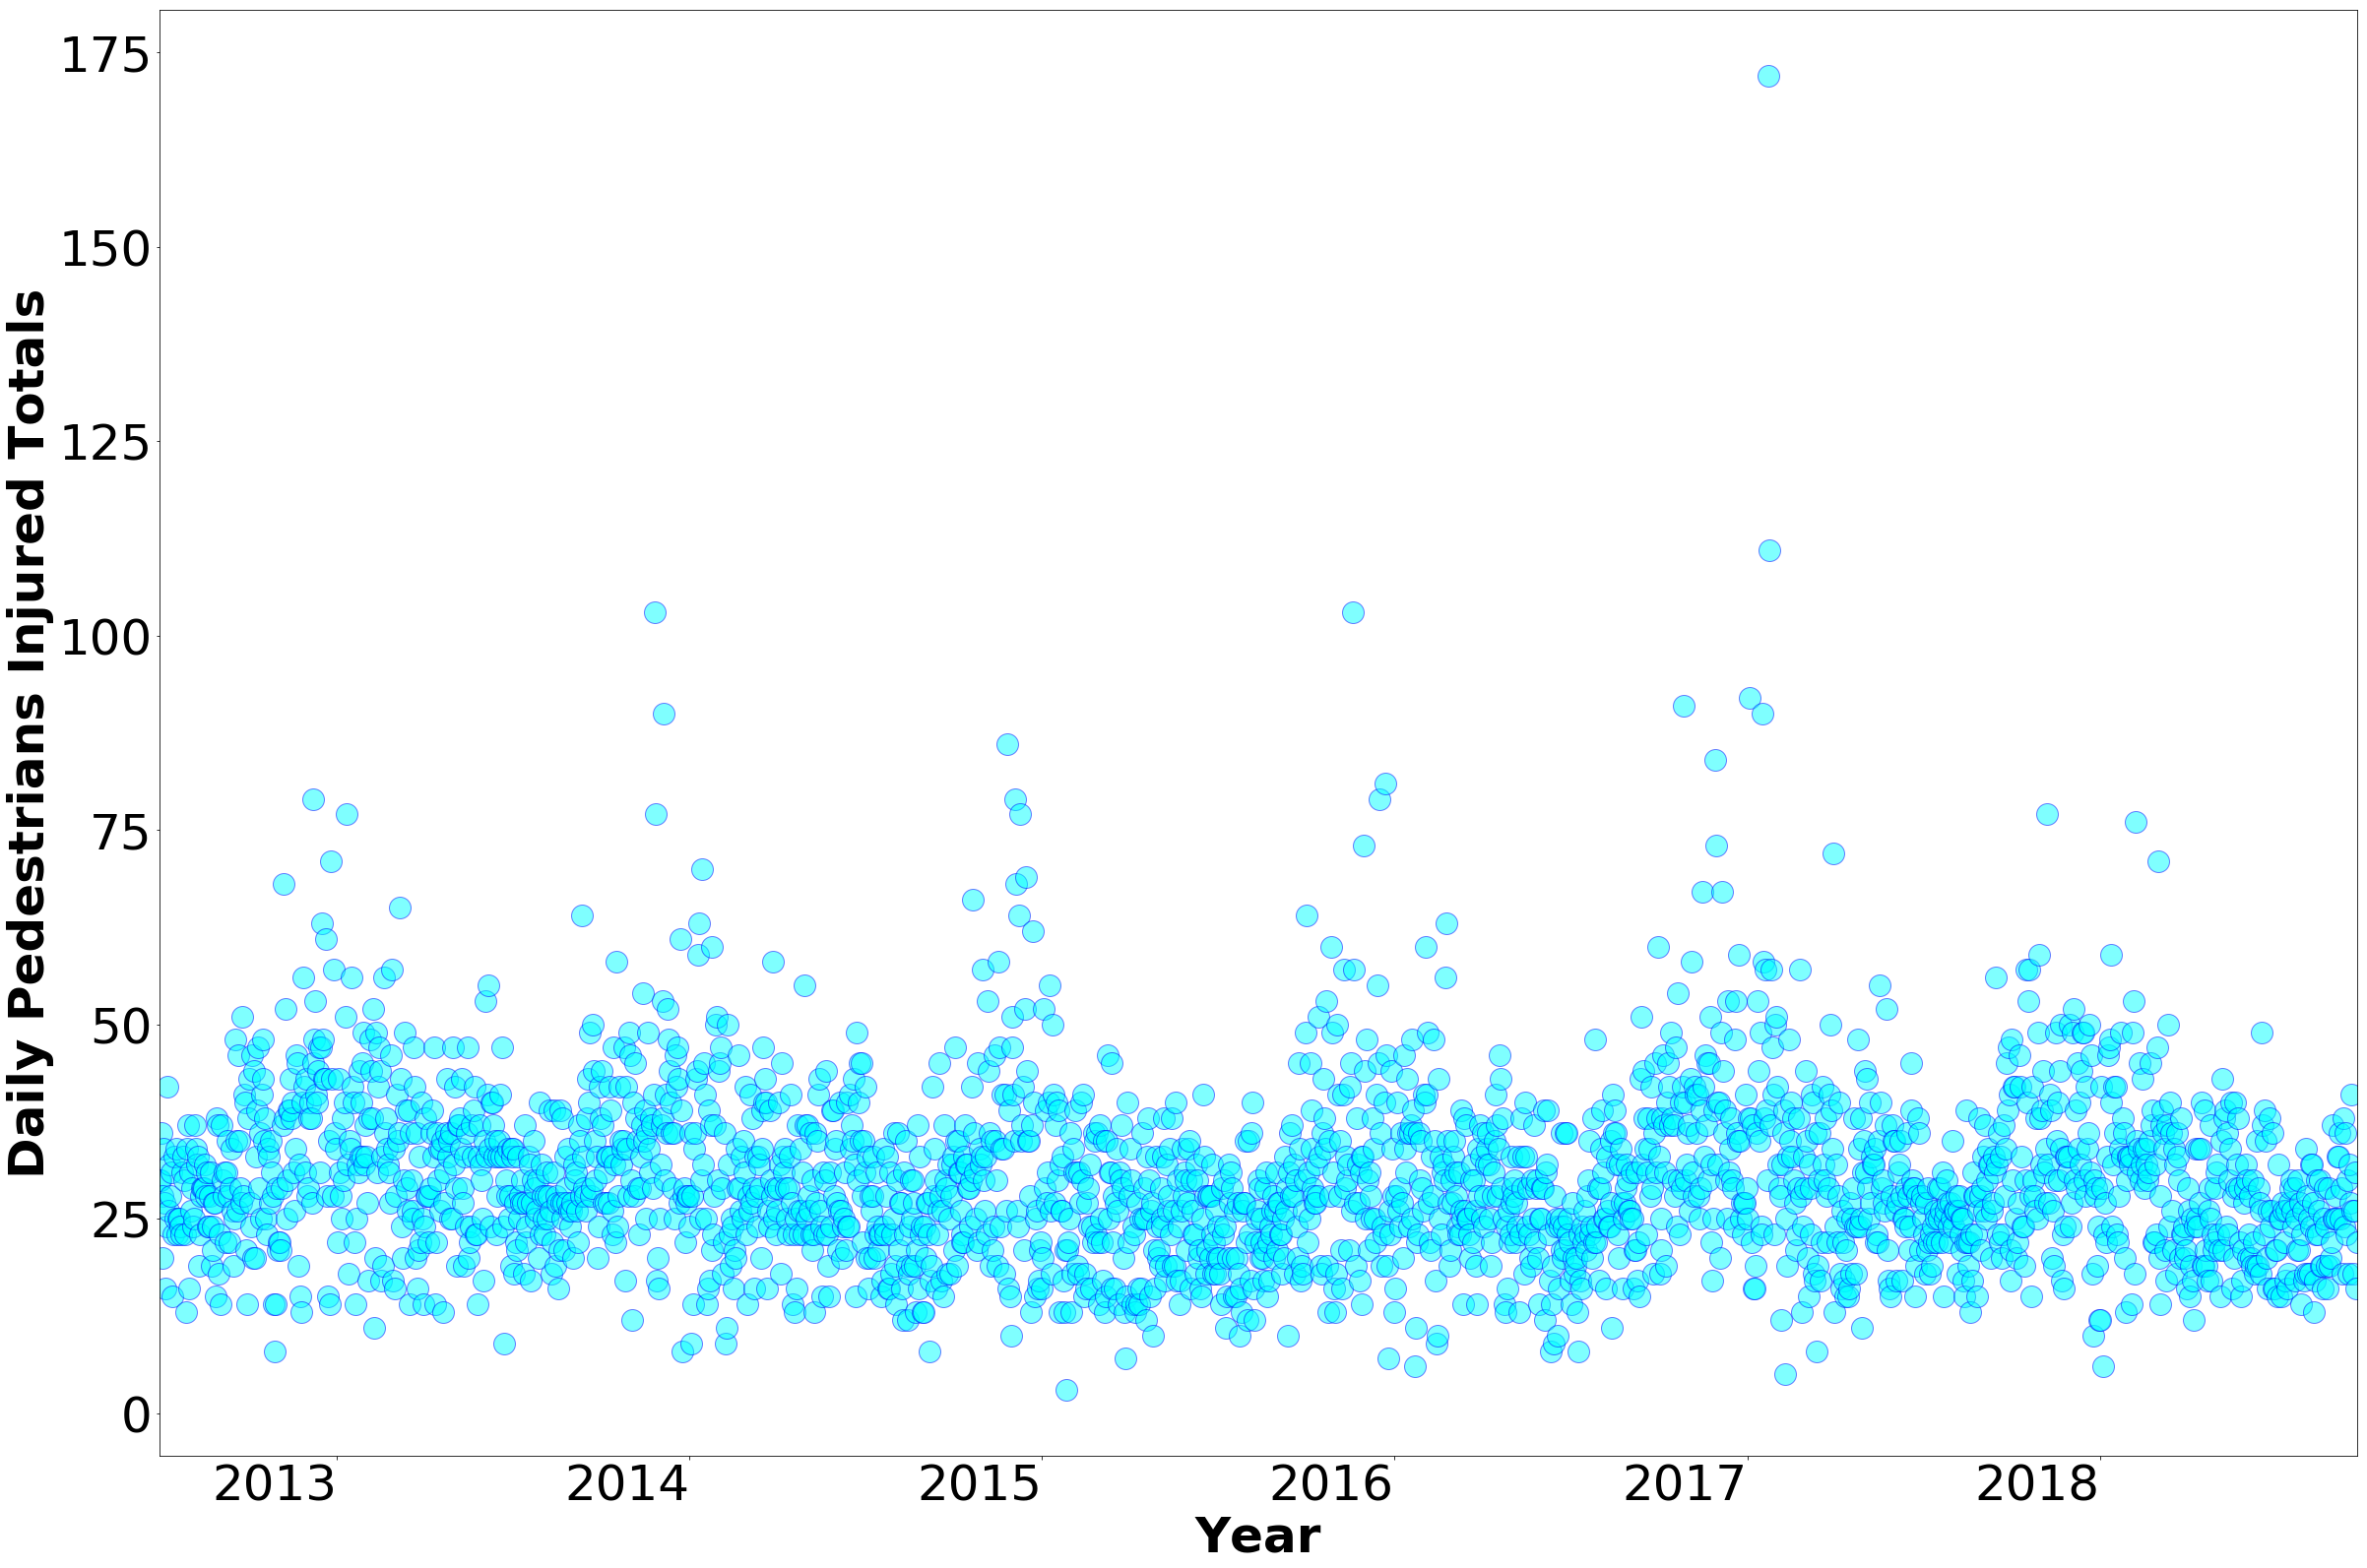

In [87]:
plt.rcParams['xtick.labelsize']=50
plt.rcParams['ytick.labelsize']=50

ax = collapsed_collisions_df['numberofpedestriansinjured'].plot(marker='o', color='cyan',markeredgecolor = 'blue', alpha=0.5, markersize=22 , linestyle='None', figsize=(40,30), subplots=True)

plt.ylabel('Daily Pedestrians Injured Totals', fontsize=50,fontweight='bold')
plt.xlabel('Year', fontsize=50,fontweight='bold')
plt.xticks(rotation='horizontal')

plt.savefig('../manuscripts/dailypedestriansinjuries.png', bbox_inches='tight')

![dailypedestriansinjuries.png](../manuscripts/dailypedestriansinjuries.png)

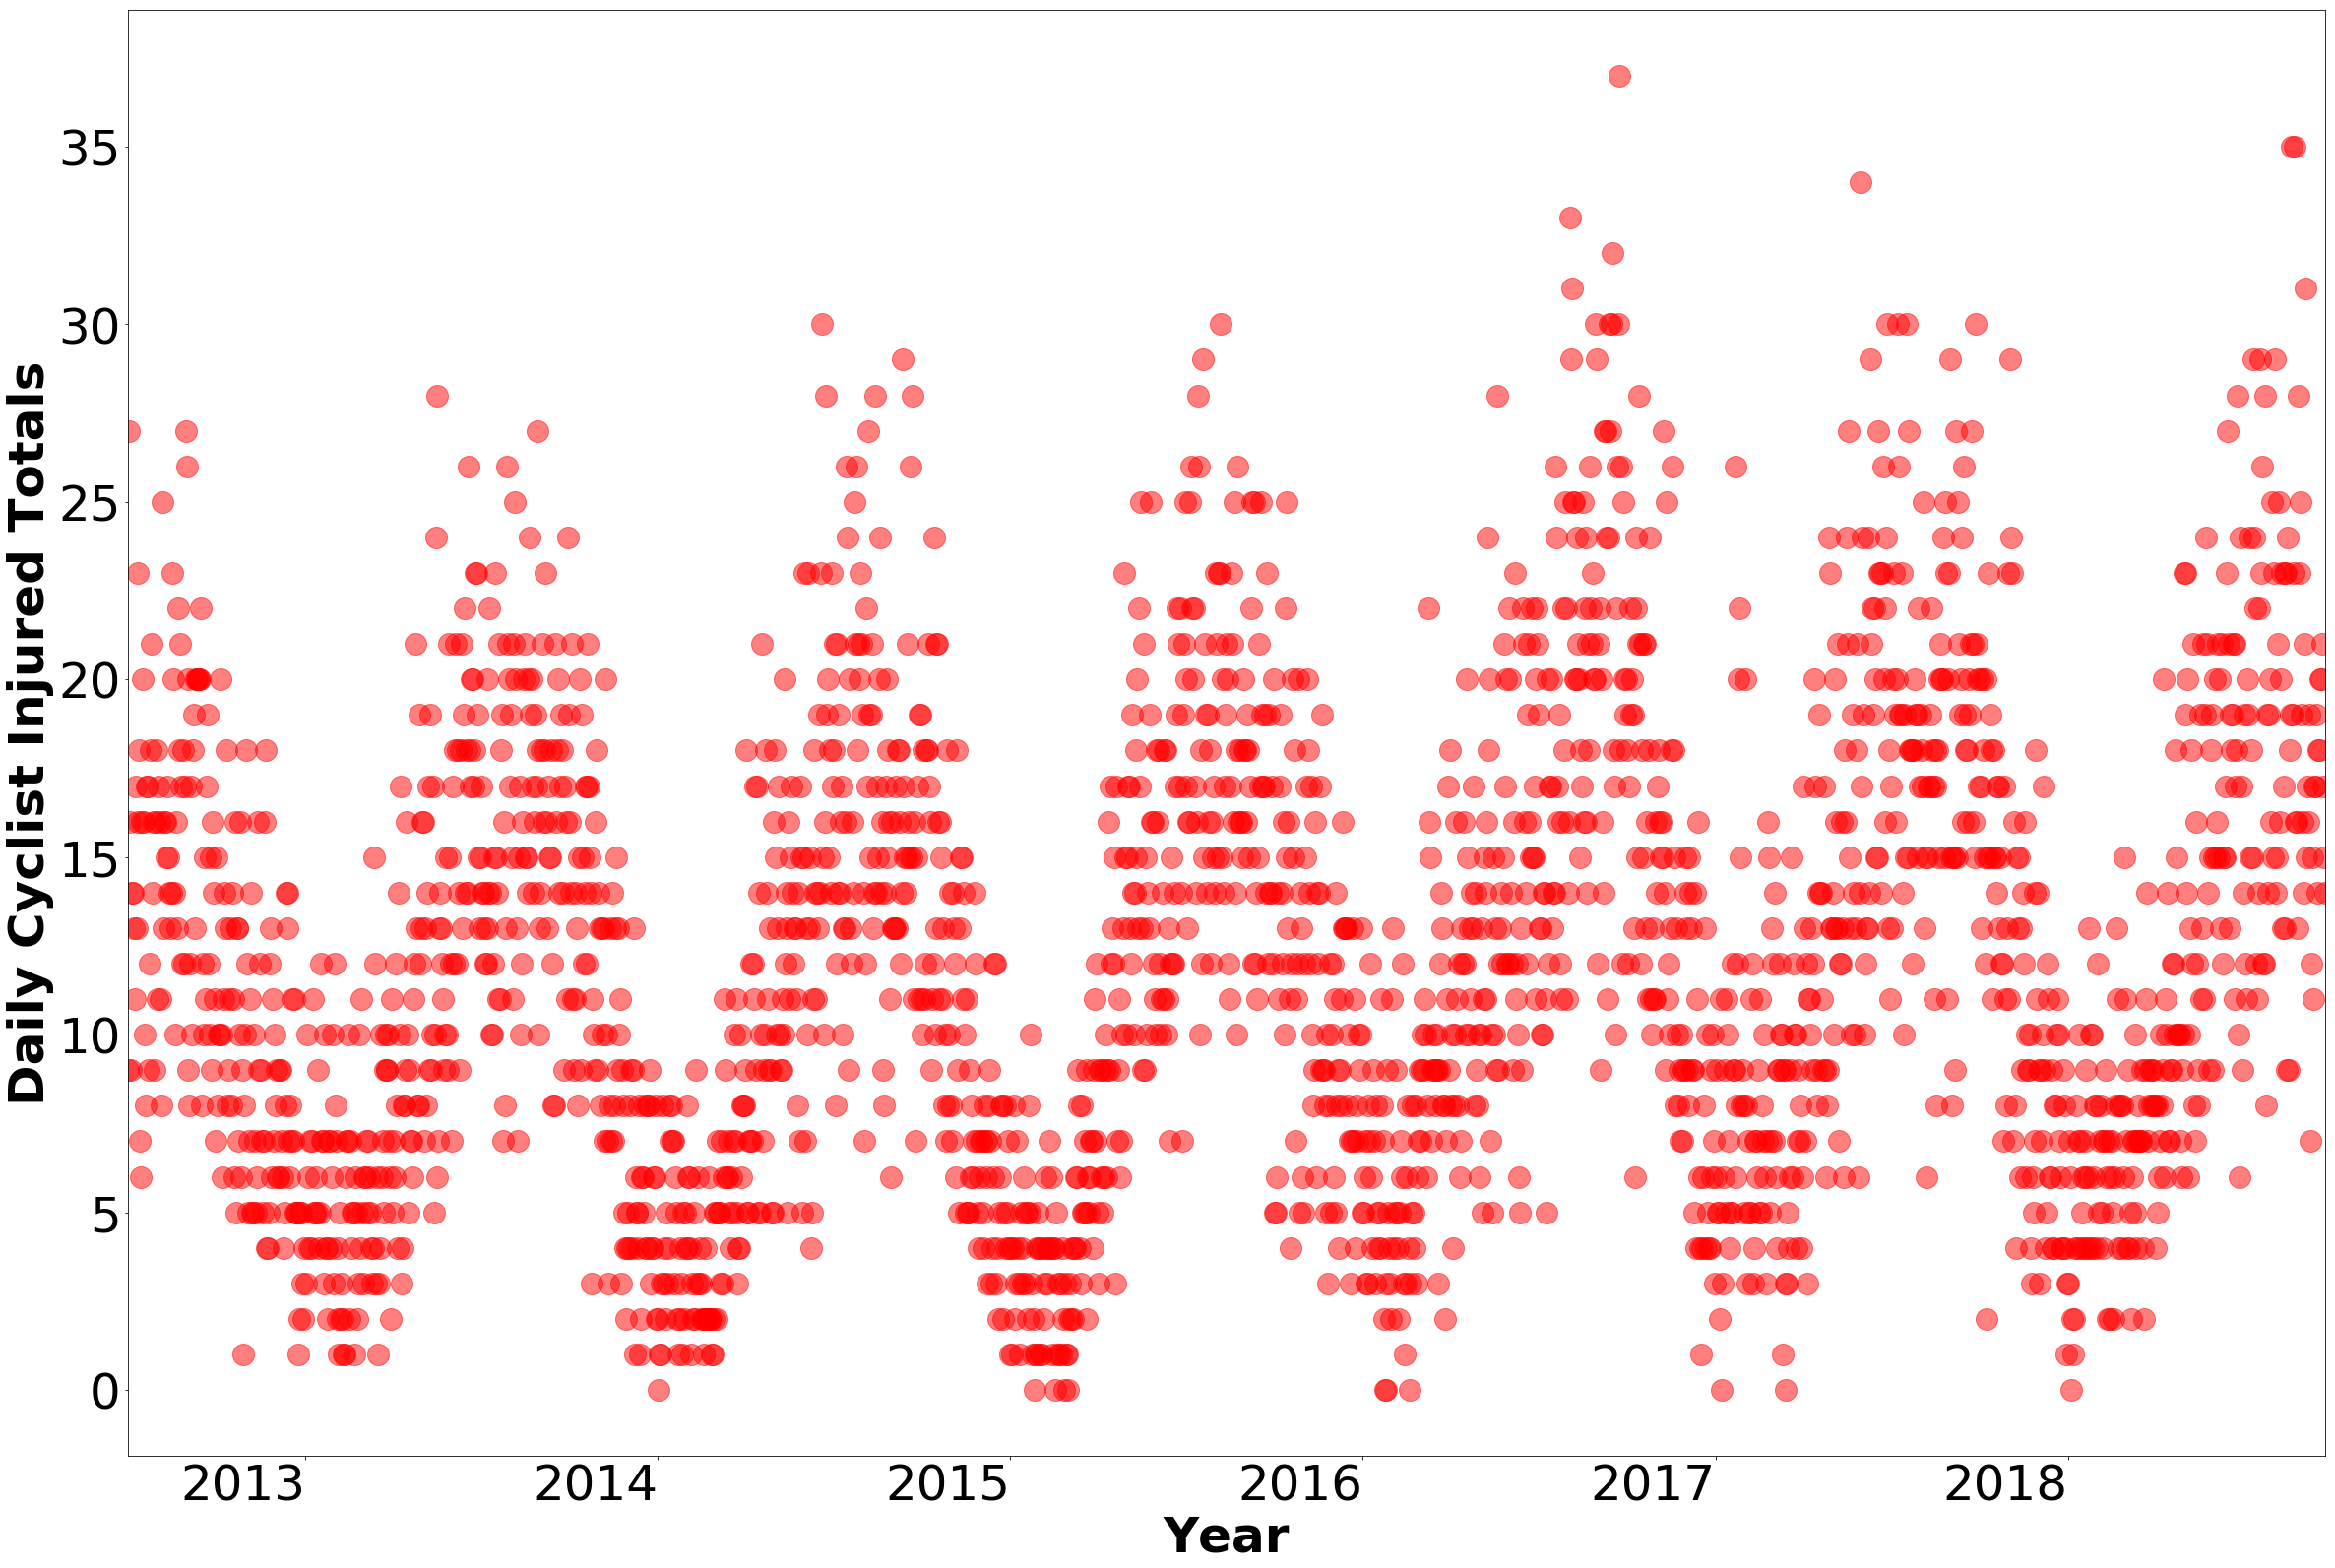

In [88]:
plt.rcParams['xtick.labelsize']=50
plt.rcParams['ytick.labelsize']=50

ax = collapsed_collisions_df['numberofcyclistinjured'].plot(marker='o', color='red', alpha=0.5, markersize=22 , linestyle='None', figsize=(40,30), subplots=True)

plt.ylabel('Daily Cyclist Injured Totals', fontsize=50,fontweight='bold')
plt.xlabel('Year', fontsize=50,fontweight='bold')
plt.xticks(rotation='horizontal')

plt.savefig('../manuscripts/dailycyclistinjuries.png', bbox_inches='tight')

![dailycyclistinjuries.png](../manuscripts/dailycyclistinjuries.png)

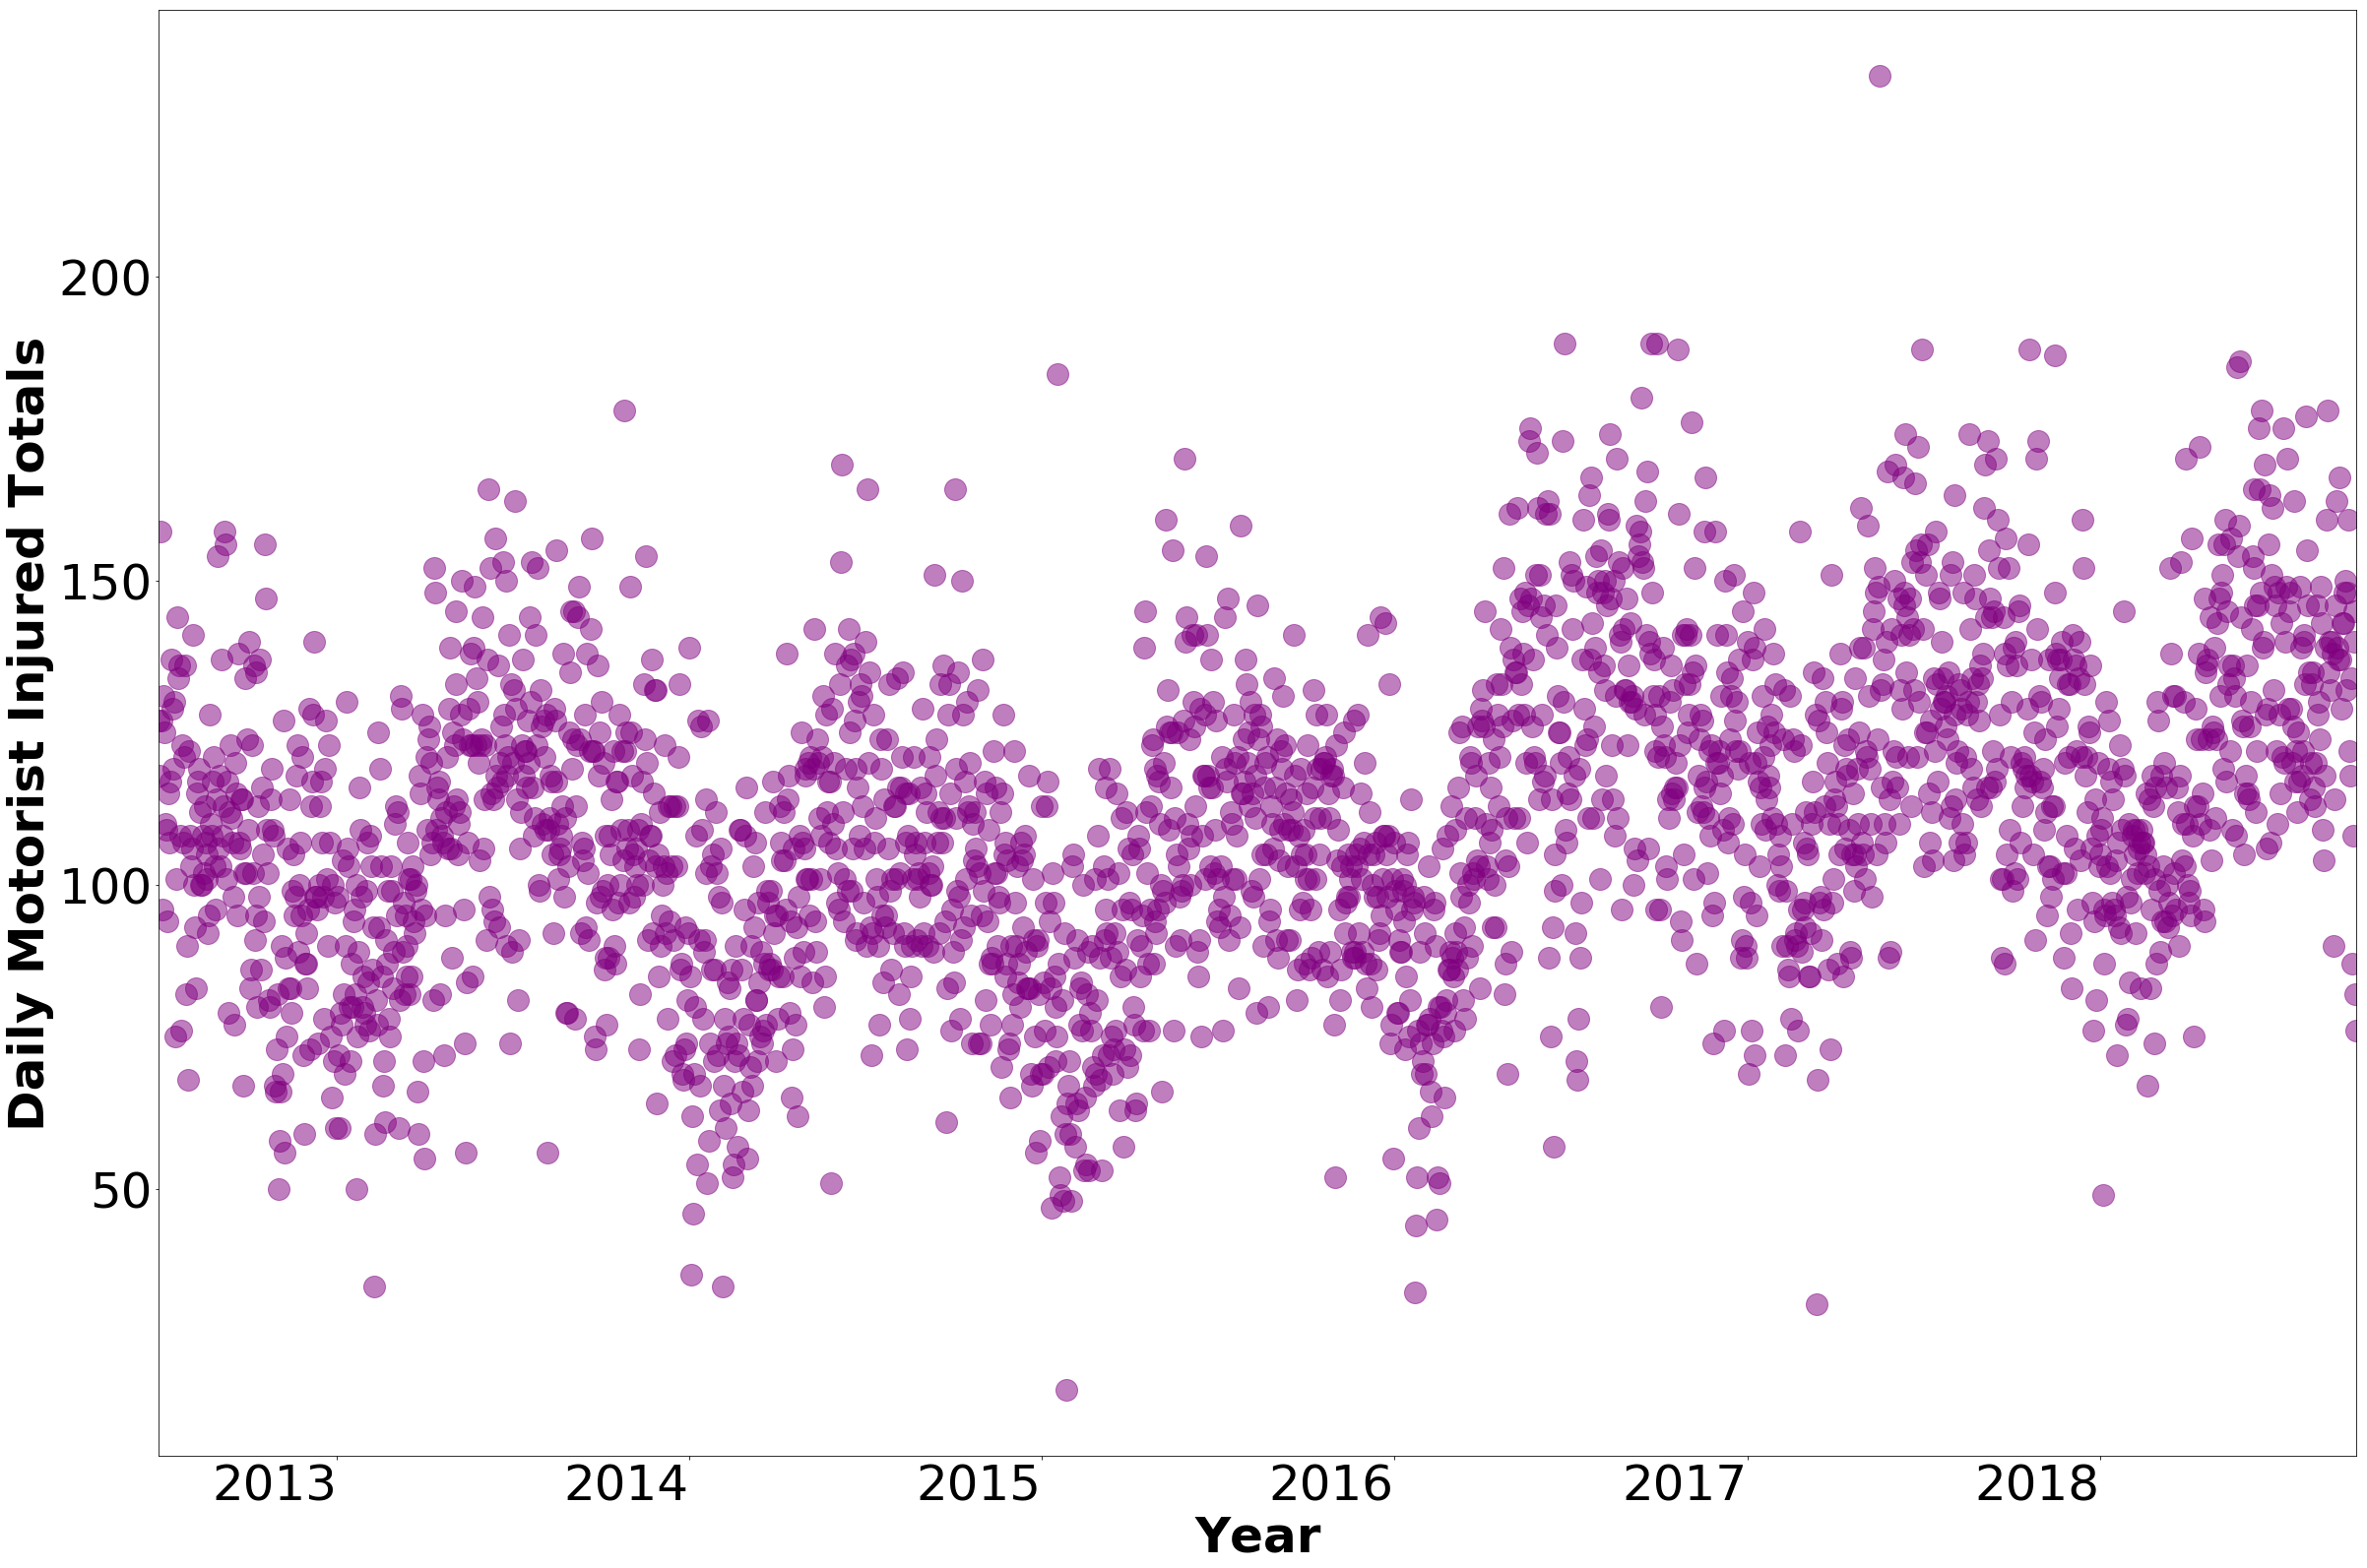

In [89]:
plt.rcParams['xtick.labelsize']=50
plt.rcParams['ytick.labelsize']=50

ax = collapsed_collisions_df['numberofmotoristinjured'].plot(marker='o', color='purple', alpha=0.5, markersize=22 , linestyle='None', figsize=(40,30), subplots=True)

plt.ylabel('Daily Motorist Injured Totals', fontsize=50,fontweight='bold')
plt.xlabel('Year', fontsize=50,fontweight='bold')
plt.xticks(rotation='horizontal')

plt.savefig('../manuscripts/dailymotoristinjuries.png', bbox_inches='tight')

![dailymotoristinjuries.png](../manuscripts/dailymotoristinjuries.png)

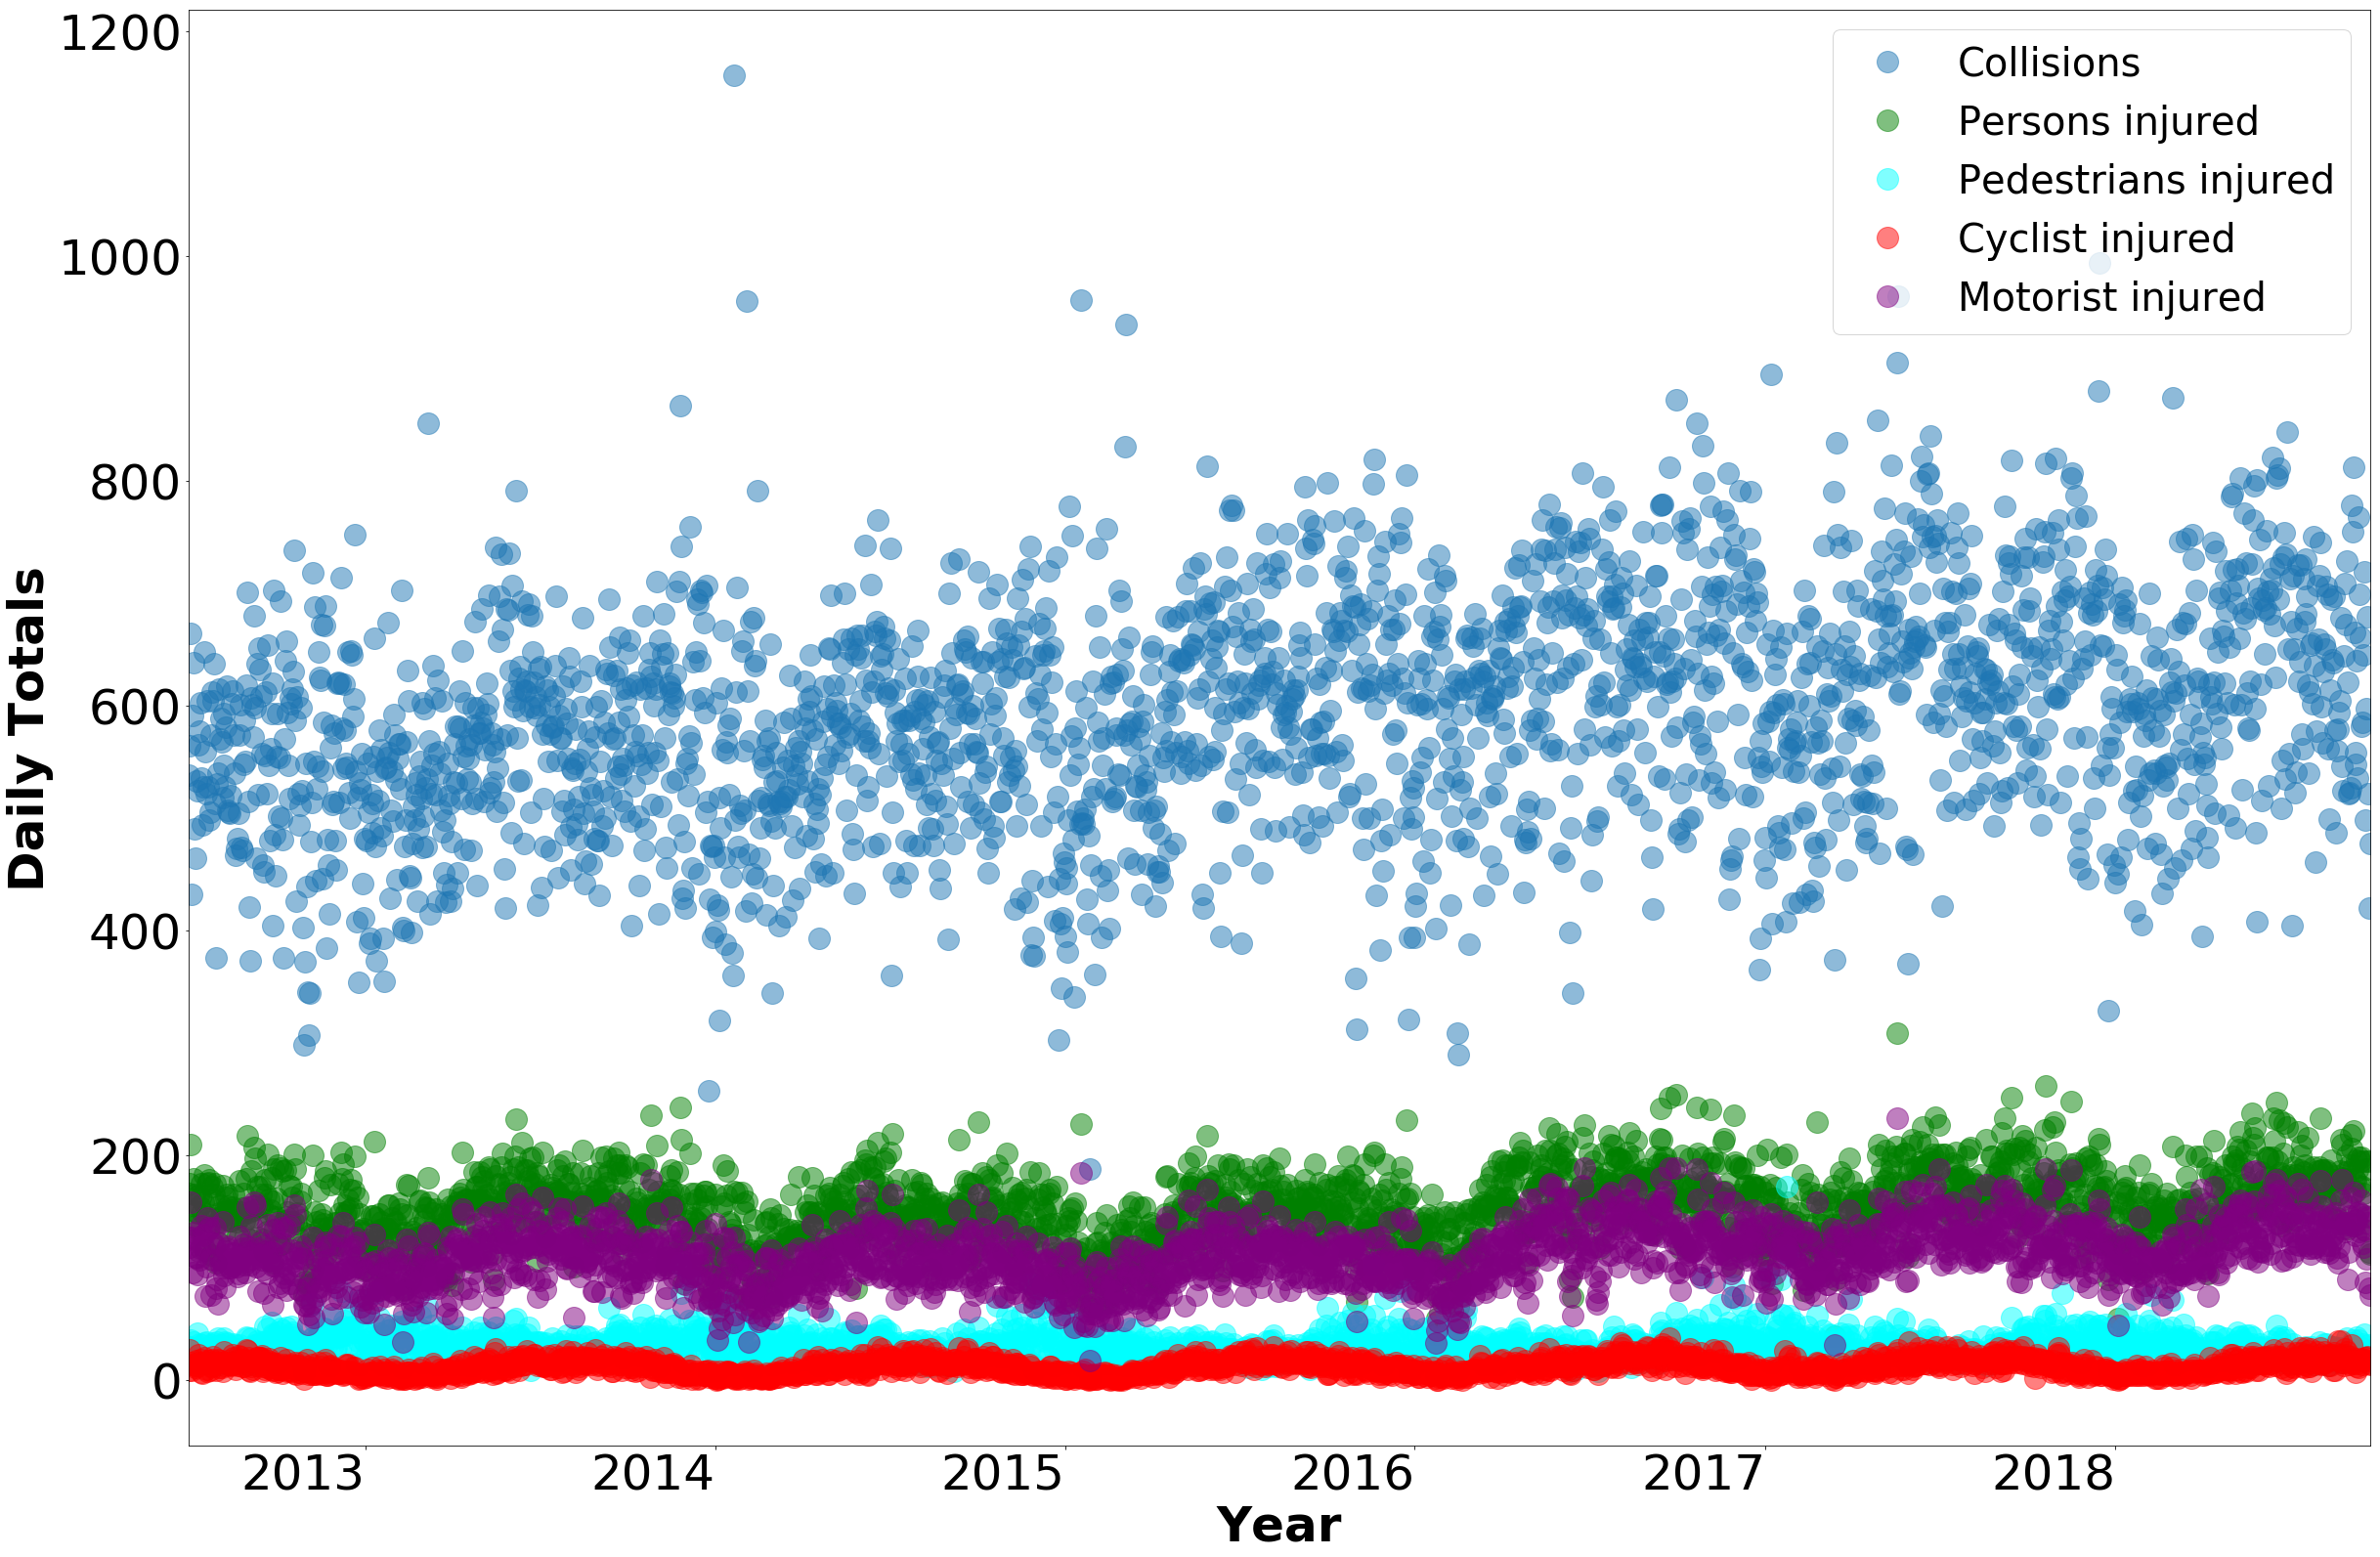

In [90]:
plt.rcParams['xtick.labelsize']=50
plt.rcParams['ytick.labelsize']=50

ax = collapsed_collisions_df['count'].plot(marker='o', alpha=0.5, markersize=22 , linestyle='None', figsize=(40,30), subplots=True)
ax = collapsed_collisions_df['numberofpersonsinjured'].plot(marker='o', color='green', alpha=0.5, markersize=22 , linestyle='None', figsize=(40,30), subplots=True)
ax = collapsed_collisions_df['numberofpedestriansinjured'].plot(marker='o', color='cyan', alpha=0.5, markersize=22 , linestyle='None', figsize=(40,30), subplots=True)
ax = collapsed_collisions_df['numberofcyclistinjured'].plot(marker='o', color='red', alpha=0.5, markersize=22 , linestyle='None', figsize=(40,30), subplots=True)
ax = collapsed_collisions_df['numberofmotoristinjured'].plot(marker='o', color='purple', alpha=0.5, markersize=22 , linestyle='None', figsize=(40,30), subplots=True)

plt.ylabel('Daily Totals', fontsize=50,fontweight='bold')
plt.xlabel('Year', fontsize=50,fontweight='bold')
plt.xticks(rotation='horizontal')

plt.legend(('Collisions','Persons injured', 'Pedestrians injured', 'Cyclist injured', 'Motorist injured'), loc='upper right',prop={'size':40})
plt.savefig('../manuscripts/dailyall.png', bbox_inches='tight')

![dailyall.png](../manuscripts/dailyall.png)

![graph_of_time_trend_average_small.png](../manuscripts/graph_of_time_trend_average_small.png)

## Hypothesis

The introduction of LPIs reduced collisions and injuries

# 2. Challenges and Solution

## Selective implementation
![collision_lpis_overlay.png](../manuscripts/collision_lpis_overlay.png)

## Phased introduction
![lpis_year_install_2013_2014.png](../manuscripts/lpis_year_install_2013_2014.png)

## Phased introduction
![lpis_year_install_2013_2016.png](../manuscripts/lpis_year_install_2013_2016.png)

## Phased introduction
![lpis_year_install_2013_2018.png](../manuscripts/lpis_year_install_2013_2018.png)


## Unobserved heterogeneity
![satalite_screenshot.png](../manuscripts/satalite_screenshot.png)

## Spatial autocorrelation
![NYC_collisions_deciles.png](../manuscripts/NYC_collisions_deciles.png)

## Spatial autocorrelation
![NYC_collisions_deciles_lagged.png](../manuscripts/NYC_collisions_deciles_lagged.png)

### General Binary treatment Difference-in-difference model
* There are 12,987 intersections ($i$) and 25 periods ($t$). 
* Simplifying from 25 quarters, we can think of it as there being 3 different groups
    * untreated group ($U$)
    * early treatment group ($k$) that receives treatment at ($t^*_k$) 
    * late treatment group ($ l$) that receives treatment at ($t^*_l$)
* Intersections that received the LPIs intervention at a later period after ($t^*_l$), hence in the periods before that, they act as controls to intersections that had received LPIs intervention at ($t^*_k$)

A simplfied representation of the model:

$$\hat{\beta}_{jU}^{2x2} \equiv ( \bar{y}_j^{POST(j)} − \bar{y}_j^{PRE(j)} ) −  ( \bar{y}_U^{POST(j)} − \bar{y}_U^{PRE(j)} ), j = k, \ell .$$

My model is an extension to the simplfied model described above, and it is more complicated as it follows LPIs that were implemented across 25 quarters.

### General Binary treatment Difference-in-difference model

* Simplifying from 25 quarters, we can think of it as there being 3 different groups
* untreated group $U$
* early treatment group $k$ that receives treatment at $t^*_k$
* late treatment group $l$ that receives treatment at $t^*_l$

### General Binary treatment Difference-in-difference model

![Generalized_DiD.png](../manuscripts/Generalized_DiD.png)

## Assumptions
* Unmeasured determinants of the outcomes were time invariant or group invariant
* Common trends assumption
* Timing of the treatment implementation must be statistically independent of the potential outcomes distributions, conditional on the group-and time-fixed effects

## Assumptions
* Unmeasured determinants of the outcomes were time invariant or group invariant
    * $ \alpha_i $ is the group fixed effect, which captures the time-invariant characteristics of the intersections ($i$) such as the design of the intersection, the light conditions of that intersection, and vehicle volumes (busyness of the intersection)
    * $ \alpha_t $ is the time fixed effect which captures the time varying characteristics but group-invariant characteristics, like trends in NYC such as seasons and the increase/decrease in population of the neighborhood
* Common trends assumption
    * Trends in the control group should closely parallel the trends in the treatment group
* Timing of the treatment implementation “must be statistically independent of the potential outcomes distributions, conditional on the group-and time-fixed effects
    * Requires that the NYC DOT not change LPIs treatment implementation based on outcomes measured in earlier periods

# 3. Results

## Model Specifications and controls
* Indicator for when intersections received LPIs intervention
* Indicator for when Bike route was built
* Indicator for when Street Improvement was implemented
* Indicator for when Left Turn intervention was implemented
* School Zone trends
* Senior Zone trends
* Priority Intersections trends
* Time effects
* Intersection fixed effects

https://zhiyzuo.github.io/Python-Plot-Regression-Coefficient/

In [2]:
fp = r"C:\Users\jerem\Box Sync\Policy Evaluation\manuscripts\coefficients.csv"
coefficients_df = pd.read_csv(fp)

In [4]:
coefficients_df['ID'] = coefficients_df.index

In [5]:
confidence = 0.95
coefficients_df['h'] = coefficients_df['err'] * t. ppf((1 + confidence) / 2, coefficients_df['n'] - 1)

In [7]:
coefficients_df['ucl'] = coefficients_df['coef'] - coefficients_df['h']
coefficients_df['lcl'] = coefficients_df['coef'] + coefficients_df['h']

In [8]:
coefficients_df['outcome_type'] = coefficients_df['type'] + " " + coefficients_df['varname']

In [9]:
varname = coefficients_df['varname'].str.split(" ", n = 1, expand = True)

In [10]:
coefficients_df['outcome'] = varname[0]

In [12]:
coefficients_df.at[0, 'outcome'] = 'collision(naive)'
coefficients_df.at[1, 'outcome'] = 'collision(naive)'
coefficients_df.at[2, 'outcome'] = 'collision(naive)'

Visualize all the coefficient and CI estimates

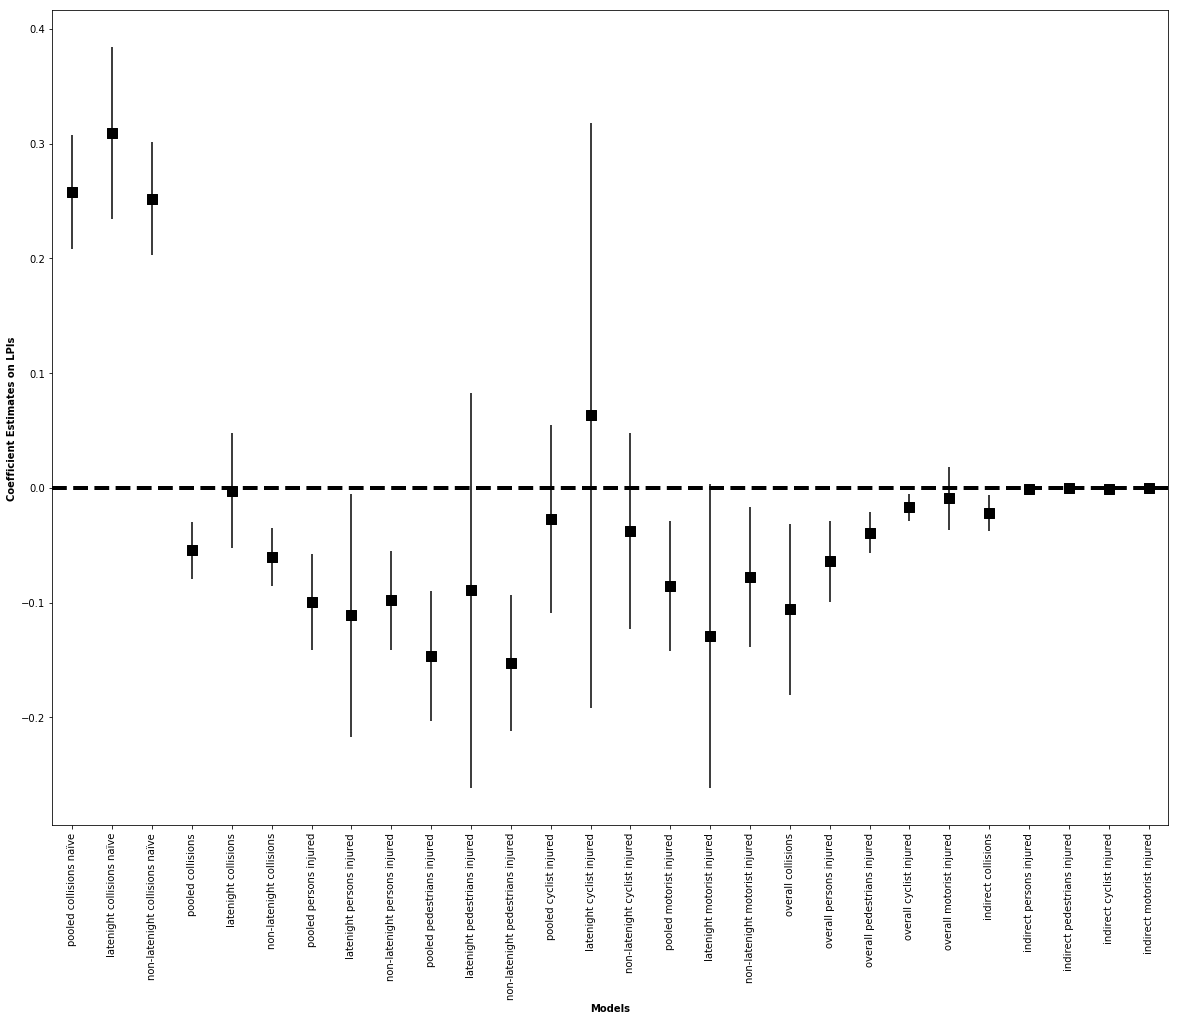

In [14]:
plt.rcParams['xtick.labelsize']=10
plt.rcParams['ytick.labelsize']=10

fig, ax = plt.subplots(figsize=(20, 15))
coefficients_df.plot(x='outcome_type', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='h', legend=False)
ax.set_ylabel('')
ax.set_xlabel('')
plt.ylabel('Coefficient Estimates on LPIs', fontsize=10,fontweight='bold')
plt.xlabel('Models', fontsize=10,fontweight='bold')
ax.scatter(x=pd.np.arange(coefficients_df.shape[0]), 
           marker='s', s=120, 
           y=coefficients_df['coef'], color='black')
ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
plt.savefig('../manuscripts/NYC_collisions_visuals.png')

Selecting the non-spatial regression LPIs coefficients

In [15]:
NYC_collisions_df = pd.DataFrame(coefficients_df.iloc[0:18])
spatial_collisions_df = pd.DataFrame(coefficients_df.iloc[18:28])

In [16]:
spatial_collisions_df

n   coef    err              varname      type  ID        h      ucl  \
18  68400 -0.106  0.038           collisions   overall  18  0.07448 -0.18048   
19  68400 -0.064  0.018      persons injured   overall  19  0.03528 -0.09928   
20  68400 -0.039  0.009  pedestrians injured   overall  20  0.01764 -0.05664   
21  68400 -0.017  0.006      cyclist injured   overall  21  0.01176 -0.02876   
22  68400 -0.009  0.014     motorist injured   overall  22  0.02744 -0.03644   
23  68400 -0.022  0.008           collisions  indirect  23  0.01568 -0.03768   
24  68400 -0.001  0.001      persons injured  indirect  24  0.00196 -0.00296   
25  68400  0.000  0.000  pedestrians injured  indirect  25  0.00000  0.00000   
26  68400 -0.001  0.000      cyclist injured  indirect  26  0.00000 -0.00100   
27  68400  0.000  0.000     motorist injured  indirect  27  0.00000  0.00000   

        lcl                  outcome_type      outcome  
18 -0.03152            overall collisions   collisions  
19 -0.02872       overall persons injured      persons  
20 -0.02136   overall pedestrians injured  pedestrians  
21 -0.00524       overall cyclist injured      cyclist  
22  0.01844      overall motorist injured     motorist  
23 -0.00632           indirect collisions   collisions  
24  0.00096      indirect persons injured      persons  
25  0.00000  indirect pedestrians injured  pedestrians  
26 -0.00100      indirect cyclist injured      cyclist  
27  0.00000     indirect motorist injured     motorist

In [17]:
NYC_collisions_pooled_df = pd.DataFrame(coefficients_df.loc[coefficients_df['type'] == "pooled"]).reset_index(drop=True)
NYC_collisions_late_df = pd.DataFrame(coefficients_df.loc[coefficients_df['type'] == "latenight"]).reset_index(drop=True)
NYC_collisions_nonlate_df = pd.DataFrame(coefficients_df.loc[coefficients_df['type'] == "non-latenight"]).reset_index(drop=True)
Manhattan_collisions_overall_df = pd.DataFrame(coefficients_df.loc[coefficients_df['type'] == "overall"]).reset_index(drop=True)
Manhattan_collisions_indirect_df = pd.DataFrame(coefficients_df.loc[coefficients_df['type'] == "indirect"]).reset_index(drop=True)

In [18]:
NYC_collisions_pooled_df

n    coef     err              varname    type  ID         h  \
0  324675  0.2580 -0.0253     collisions naïve  pooled   0 -0.049587   
1  283550 -0.0545 -0.0128           collisions  pooled   3 -0.025088   
2  273875 -0.0993 -0.0213      persons injured  pooled   6 -0.041747   
3  223100 -0.1470 -0.0289  pedestrians injured  pooled   9 -0.056643   
4  158275 -0.0272 -0.0418      cyclist injured  pooled  12 -0.081927   
5  254400 -0.0856 -0.0290     motorist injured  pooled  15 -0.056839   

        ucl       lcl                outcome_type           outcome  
0  0.307587  0.208413     pooled collisions naïve  collision(naive)  
1 -0.029412 -0.079588           pooled collisions        collisions  
2 -0.057553 -0.141047      pooled persons injured           persons  
3 -0.090357 -0.203643  pooled pedestrians injured       pedestrians  
4  0.054727 -0.109127      pooled cyclist injured           cyclist  
5 -0.028761 -0.142439     pooled motorist injured          motorist

## Pooled Non-spatial

In [19]:
NYC_collisions_pooled_df['percentchange'] = (np.exp(NYC_collisions_pooled_df['coef'])-1)*100

In [20]:
NYC_collisions_pooled_df['percentchange2'] = NYC_collisions_pooled_df.percentchange.round(2)

In [21]:
NYC_collisions_pooled_df

n    coef     err              varname    type  ID         h  \
0  324675  0.2580 -0.0253     collisions naïve  pooled   0 -0.049587   
1  283550 -0.0545 -0.0128           collisions  pooled   3 -0.025088   
2  273875 -0.0993 -0.0213      persons injured  pooled   6 -0.041747   
3  223100 -0.1470 -0.0289  pedestrians injured  pooled   9 -0.056643   
4  158275 -0.0272 -0.0418      cyclist injured  pooled  12 -0.081927   
5  254400 -0.0856 -0.0290     motorist injured  pooled  15 -0.056839   

        ucl       lcl                outcome_type           outcome  \
0  0.307587  0.208413     pooled collisions naïve  collision(naive)   
1 -0.029412 -0.079588           pooled collisions        collisions   
2 -0.057553 -0.141047      pooled persons injured           persons   
3 -0.090357 -0.203643  pooled pedestrians injured       pedestrians   
4  0.054727 -0.109127      pooled cyclist injured           cyclist   
5 -0.028761 -0.142439     pooled motorist injured          motorist   

   percentchange  percentchange2  
0      29.433882           29.43  
1      -5.304149           -5.30  
2      -9.452897           -9.45  
3     -13.670602          -13.67  
4      -2.683341           -2.68  
5      -8.203866           -8.20

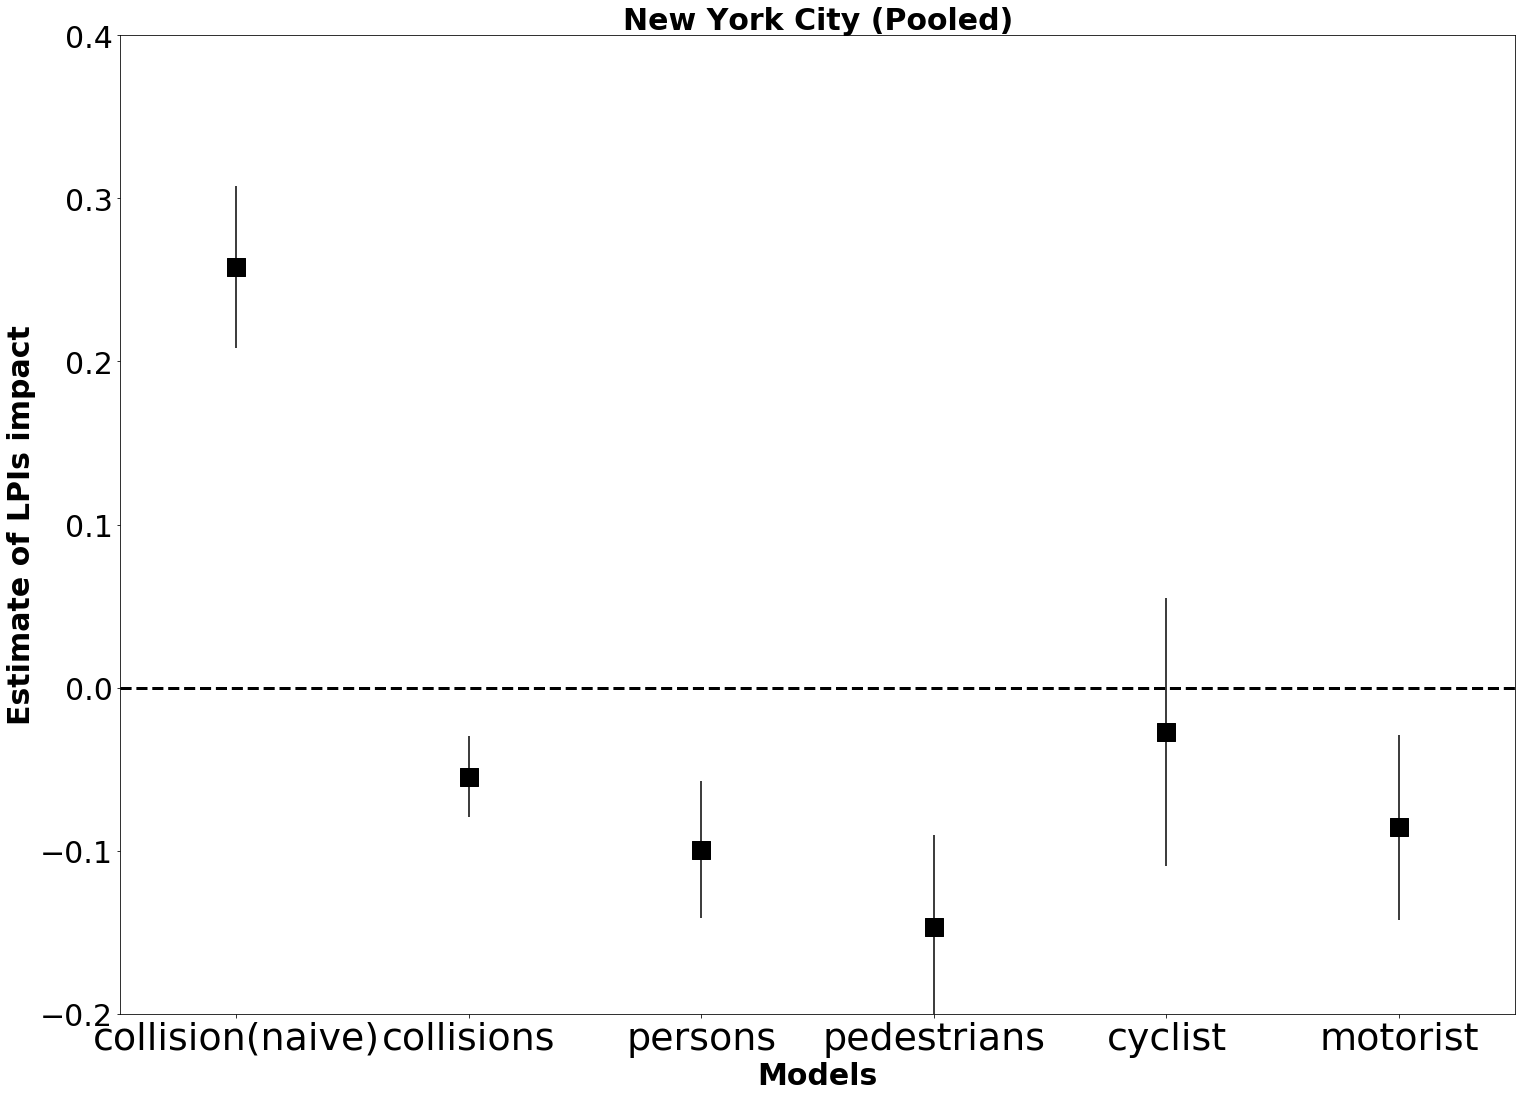

In [28]:
# Pooled non-spatial
plt.rcParams['xtick.labelsize']=38
plt.rcParams['ytick.labelsize']=30

fig, ax = plt.subplots(figsize=(25, 18))
NYC_collisions_pooled_df.plot(x='outcome', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='h', legend=False)
plt.title('New York City (Pooled)', fontsize=30,fontweight='bold')
plt.ylabel('Estimate of LPIs impact', fontsize=30,fontweight='bold')
plt.xlabel('Models', fontsize=30,fontweight='bold')
ax.scatter(x=pd.np.arange(NYC_collisions_pooled_df.shape[0]), 
           marker='s', s=300, 
           y=NYC_collisions_pooled_df['coef'], color='black')
ax.axhline(y=0, linestyle='--', color='black', linewidth=3)
ax.tick_params(axis='x', rotation='default')
ax.set_ylim([-0.2,0.4])

plt.savefig('../manuscripts/NYC_collisions_pooled_visuals.png')

## NYC Fixed effects DiD (Pooled)
![NYC_collisions_pooled_visuals.png](../manuscripts/NYC_collisions_pooled_visuals.png)

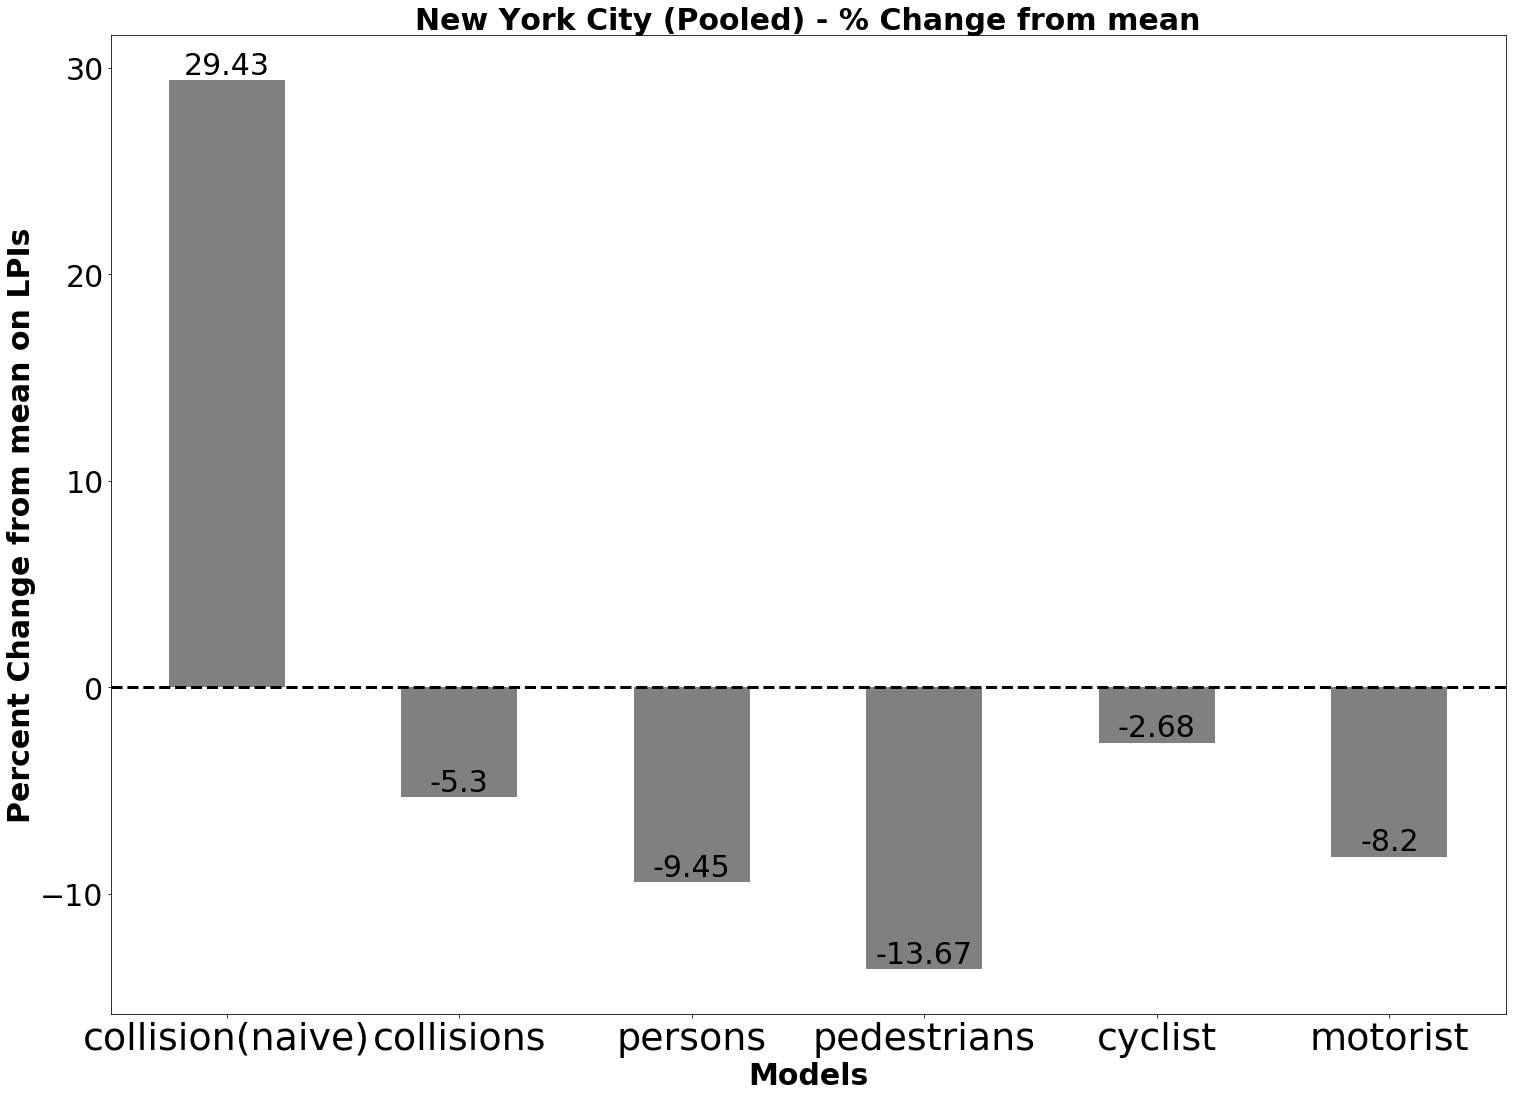

In [22]:
# Pooled non-spatial
plt.rcParams['xtick.labelsize']=38
plt.rcParams['ytick.labelsize']=30

fig, ax = plt.subplots(figsize=(25, 18))
NYC_collisions_pooled_df.plot(x='outcome', y='percentchange', kind='bar', 
             ax=ax, color='grey', legend=False)
plt.title('New York City (Pooled) - % Change from mean', fontsize=30,fontweight='bold')
plt.ylabel('Percent Change from mean on LPIs', fontsize=30,fontweight='bold')
plt.xlabel('Models', fontsize=30,fontweight='bold')
ax.axhline(y=0, linestyle='--', color='black', linewidth=3)
ax.tick_params(axis='x', rotation='default')

rects = ax.patches

# Make some labels.
labels = NYC_collisions_pooled_df['percentchange2']

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, label,
            ha='center', va='bottom',fontsize=30)

plt.savefig('../manuscripts/NYC_collisions_pooled_visuals_percent.png')

## NYC Fixed effects DiD (Pooled)
![NYC_collisions_pooled_visuals_percent.png](../manuscripts/NYC_collisions_pooled_visuals_percent.png)

## Late night

In [130]:
NYC_collisions_late_df['percentchange'] = (np.exp(NYC_collisions_late_df['coef'])-1)*100

In [131]:
NYC_collisions_late_df['percentchange2'] = NYC_collisions_late_df.percentchange.round(2)

In [132]:
NYC_collisions_late_df

n     coef     err              varname       type  ID         h  \
0  324675  0.30900 -0.0383     collisions naïve  latenight   1 -0.075067   
1  242725 -0.00245 -0.0255           collisions  latenight   4 -0.049979   
2  146725 -0.11100 -0.0540      persons injured  latenight   7 -0.105839   
3   58475 -0.08950 -0.0880  pedestrians injured  latenight  10 -0.172480   
4   27575  0.06320 -0.1300      cyclist injured  latenight  13 -0.254807   
5  113775 -0.12900 -0.0676     motorist injured  latenight  16 -0.132495   

        ucl       lcl                   outcome_type           outcome  \
0  0.384067  0.233933     latenight collisions naïve  collision(naive)   
1  0.047529 -0.052429           latenight collisions        collisions   
2 -0.005161 -0.216839      latenight persons injured           persons   
3  0.082980 -0.261980  latenight pedestrians injured       pedestrians   
4  0.318007 -0.191607      latenight cyclist injured           cyclist   
5  0.003495 -0.261495     latenight motorist injured          motorist   

   percentchange  percentchange2  
0      36.206237           36.21  
1      -0.244700           -0.24  
2     -10.506125          -10.51  
3      -8.561173           -8.56  
4       6.523987            6.52  
5     -12.102603          -12.10

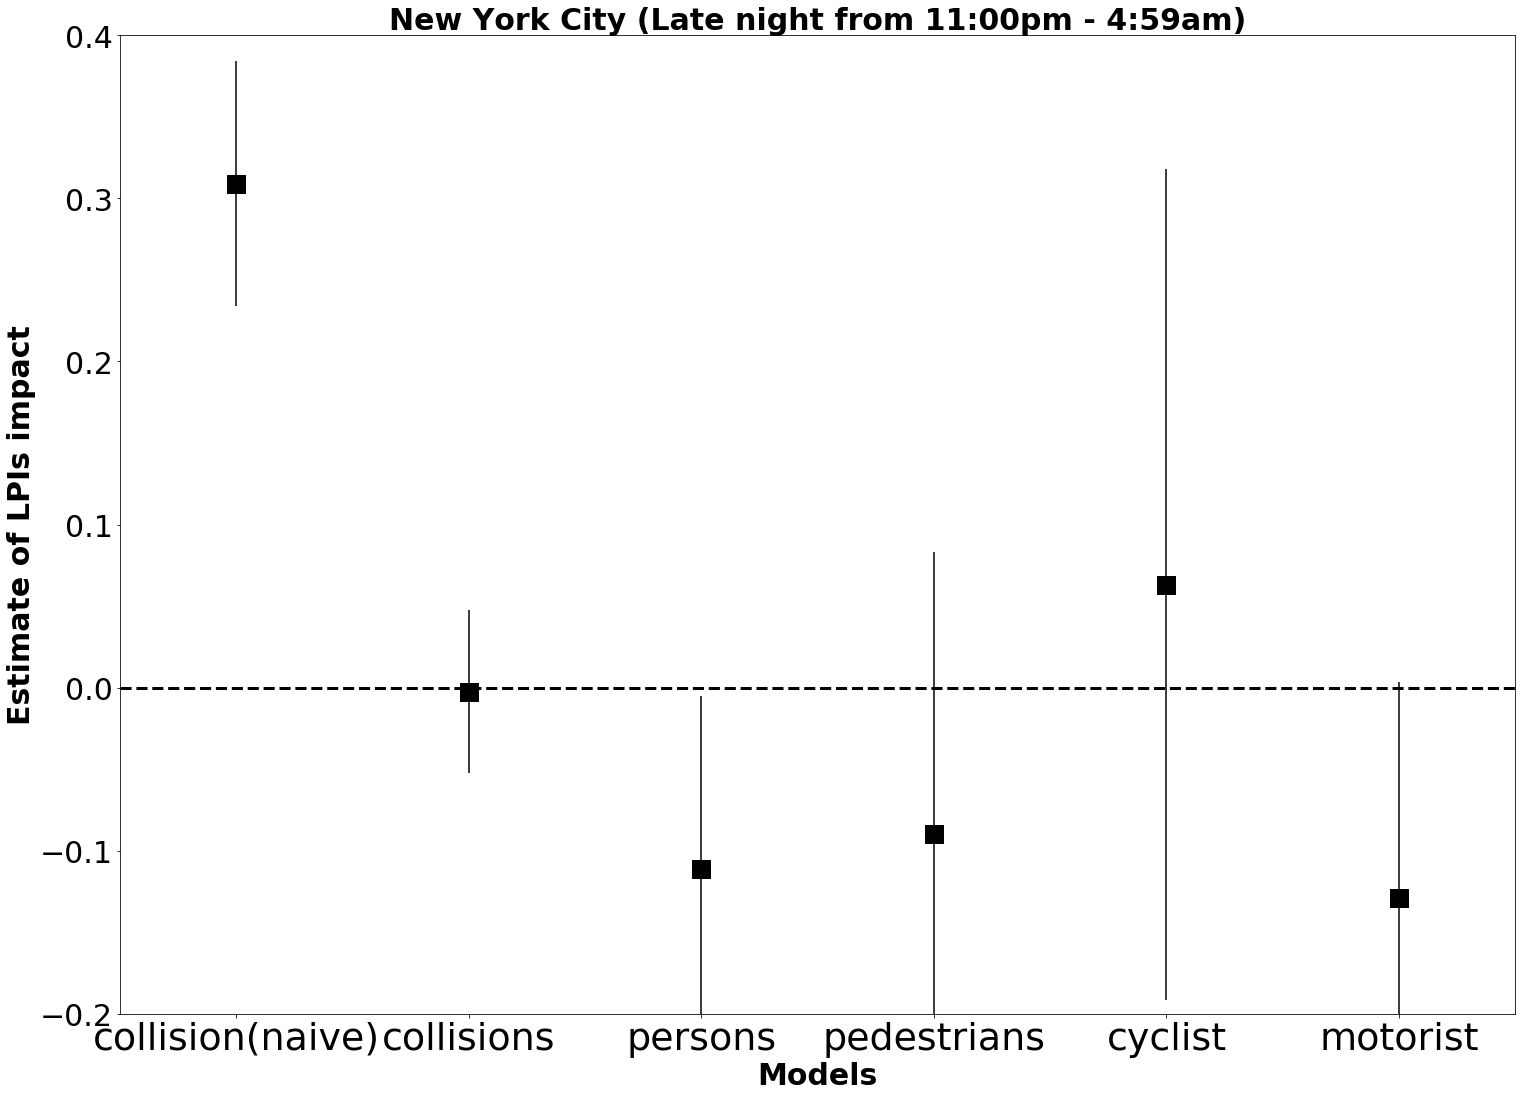

In [29]:
plt.rcParams['xtick.labelsize']=38
plt.rcParams['ytick.labelsize']=30

fig, ax = plt.subplots(figsize=(25, 18))
NYC_collisions_late_df.plot(x='outcome', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='h', legend=False)
plt.title('New York City (Late night from 11:00pm - 4:59am)', fontsize=30,fontweight='bold')
plt.ylabel('Estimate of LPIs impact', fontsize=30,fontweight='bold')
plt.xlabel('Models', fontsize=30,fontweight='bold')
ax.scatter(x=pd.np.arange(NYC_collisions_late_df.shape[0]), 
           marker='s', s=300, 
           y=NYC_collisions_late_df['coef'], color='black')
ax.axhline(y=0, linestyle='--', color='black', linewidth=3)
ax.tick_params(axis='x', rotation='default')
ax.set_ylim([-0.2,0.4])

plt.savefig('../manuscripts/NYC_collisions_latenight_visuals.png')

## NYC Fixed Effects DiD (Late Night)
![NYC_collisions_latenight_visuals.png](../manuscripts/NYC_collisions_latenight_visuals.png)

## Non-latenight

In [134]:
NYC_collisions_nonlate_df['percentchange'] = (np.exp(NYC_collisions_nonlate_df['coef'])-1)*100

In [135]:
NYC_collisions_nonlate_df['percentchange2'] = NYC_collisions_nonlate_df.percentchange.round(2)

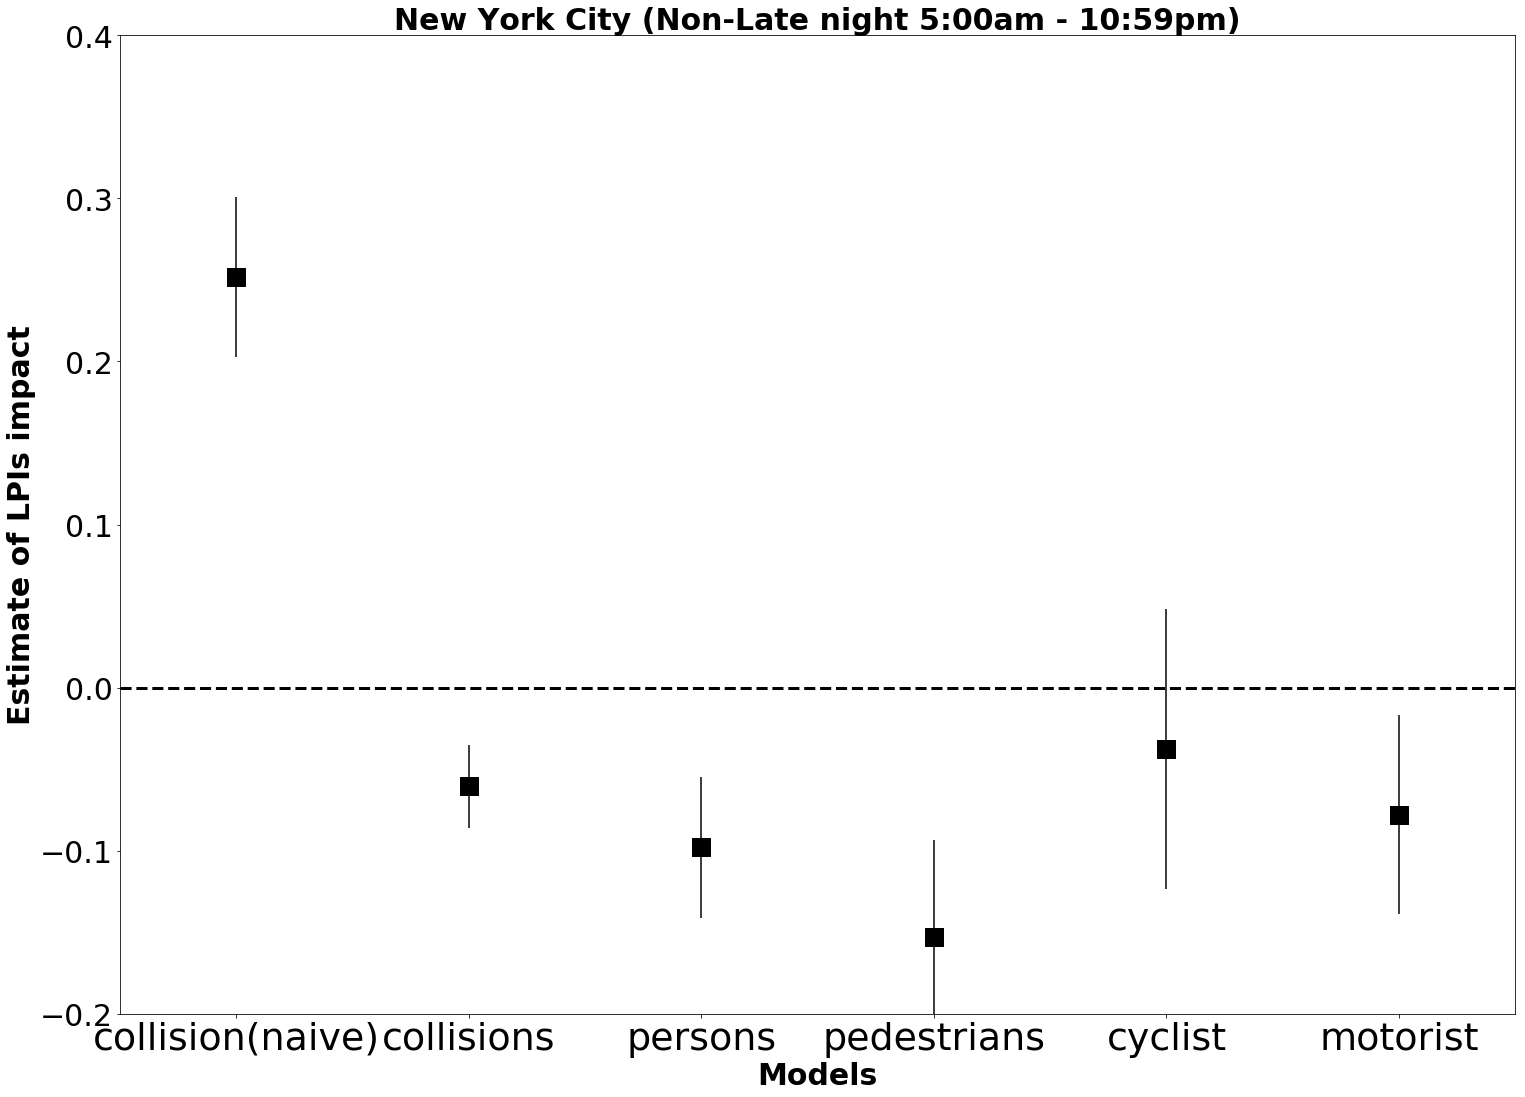

In [30]:
plt.rcParams['xtick.labelsize']=38
plt.rcParams['ytick.labelsize']=30

fig, ax = plt.subplots(figsize=(25, 18))
NYC_collisions_nonlate_df.plot(x='outcome', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='h', legend=False)
plt.title('New York City (Non-Late night 5:00am - 10:59pm)', fontsize=30,fontweight='bold')
plt.ylabel('Estimate of LPIs impact', fontsize=30,fontweight='bold')
plt.xlabel('Models', fontsize=30,fontweight='bold')
ax.scatter(x=pd.np.arange(NYC_collisions_nonlate_df.shape[0]), 
           marker='s', s=300, 
           y=NYC_collisions_nonlate_df['coef'], color='black')
ax.axhline(y=0, linestyle='--', color='black', linewidth=3)
ax.tick_params(axis='x', rotation='default')
ax.set_ylim([-0.2,0.4])

plt.savefig('../manuscripts/NYC_collisions_nonlatenight_visuals.png')

## NYC Fixed Effects DiD (Non-late night)
![NYC_collisions_nonlatenight_visuals.png](../manuscripts/NYC_collisions_nonlatenight_visuals.png)

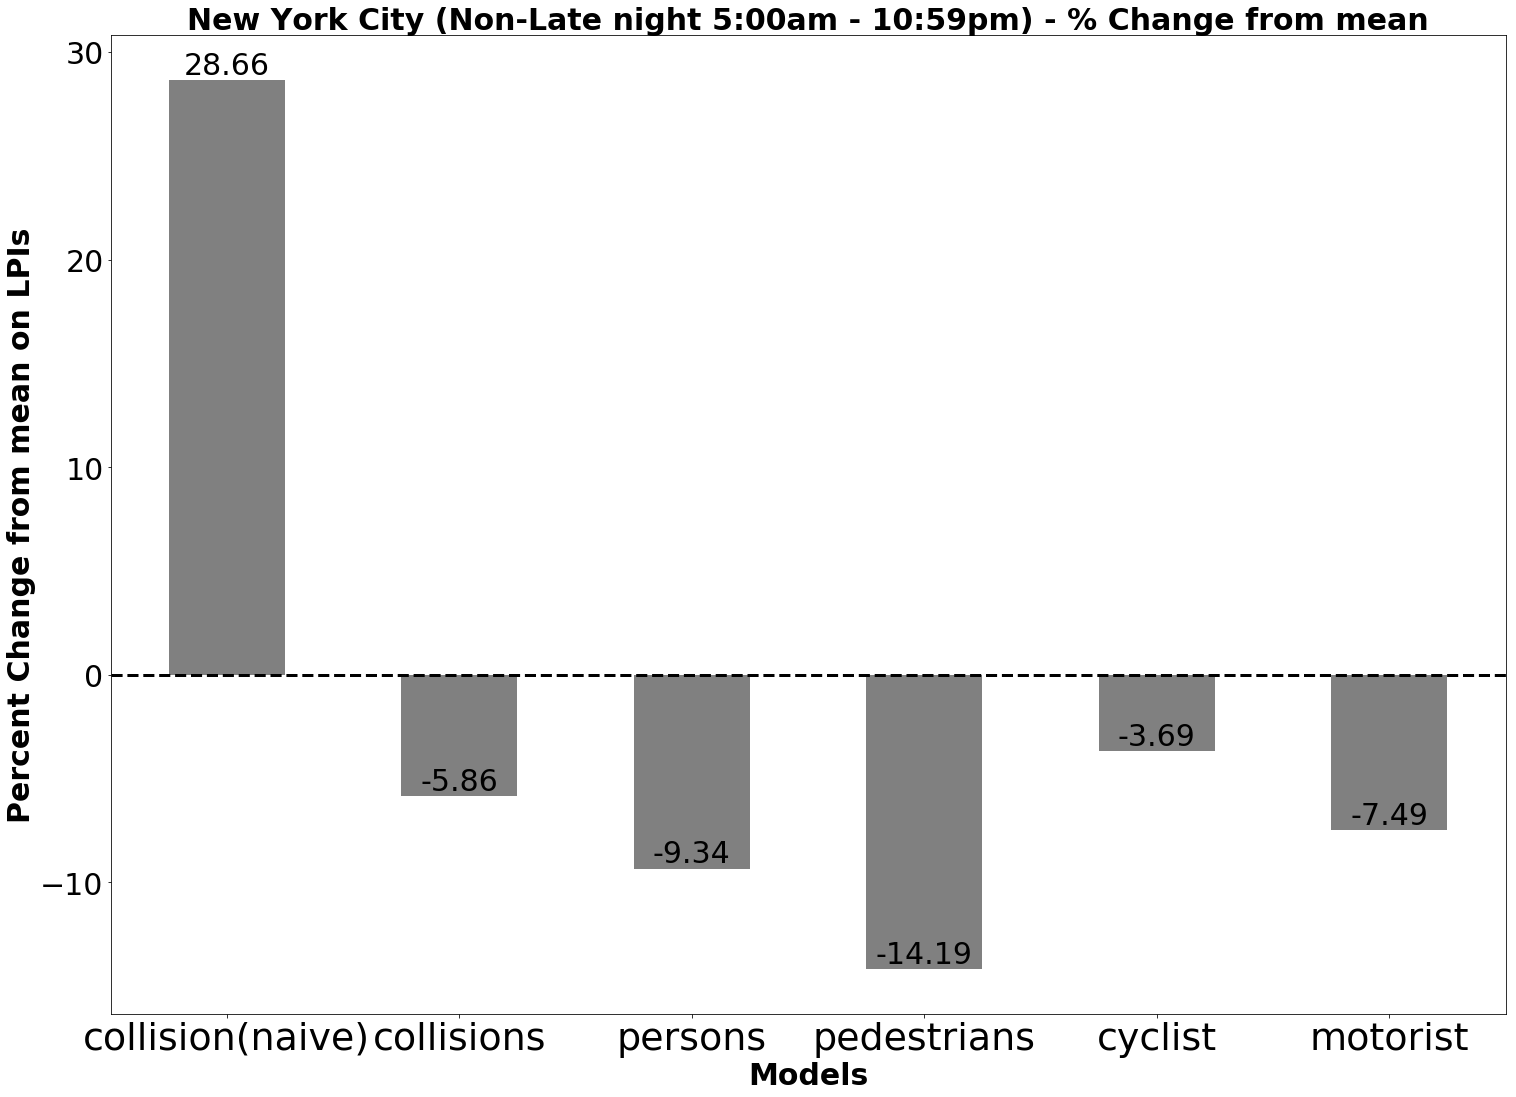

In [140]:
plt.rcParams['xtick.labelsize']=38
plt.rcParams['ytick.labelsize']=30

fig, ax = plt.subplots(figsize=(25, 18))
NYC_collisions_nonlate_df.plot(x='outcome', y='percentchange', kind='bar', 
             ax=ax, color='grey', legend=False)
plt.title('New York City (Non-Late night 5:00am - 10:59pm) - % Change from mean', fontsize=30,fontweight='bold')
plt.ylabel('Percent Change from mean on LPIs', fontsize=30,fontweight='bold')
plt.xlabel('Models', fontsize=30,fontweight='bold')
ax.axhline(y=0, linestyle='--', color='black', linewidth=3)
ax.tick_params(axis='x', rotation='default')

rects = ax.patches

# Make some labels.
labels = NYC_collisions_nonlate_df['percentchange2']

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, label,
            ha='center', va='bottom',fontsize=30)

plt.savefig('../manuscripts/NYC_collisions_nonlatenight_visuals_percent.png')

## Manhattan Overall impact

In [142]:
Manhattan_collisions_overall_df

n   coef    err              varname     type  ID        h      ucl  \
0  68400 -0.106  0.038           collisions  overall  18  0.07448 -0.18048   
1  68400 -0.064  0.018      persons injured  overall  19  0.03528 -0.09928   
2  68400 -0.039  0.009  pedestrians injured  overall  20  0.01764 -0.05664   
3  68400 -0.017  0.006      cyclist injured  overall  21  0.01176 -0.02876   
4  68400 -0.009  0.014     motorist injured  overall  22  0.02744 -0.03644   

       lcl                 outcome_type      outcome  
0 -0.03152           overall collisions   collisions  
1 -0.02872      overall persons injured      persons  
2 -0.02136  overall pedestrians injured  pedestrians  
3 -0.00524      overall cyclist injured      cyclist  
4  0.01844     overall motorist injured     motorist

In [143]:
data = np.array([3.115751,0.6299408,0.2287576,0.1019463,0.300866])
s = pd.Series(data)
Manhattan_collisions_overall_df['mean'] = s

In [144]:
Manhattan_collisions_overall_df

n   coef    err              varname     type  ID        h      ucl  \
0  68400 -0.106  0.038           collisions  overall  18  0.07448 -0.18048   
1  68400 -0.064  0.018      persons injured  overall  19  0.03528 -0.09928   
2  68400 -0.039  0.009  pedestrians injured  overall  20  0.01764 -0.05664   
3  68400 -0.017  0.006      cyclist injured  overall  21  0.01176 -0.02876   
4  68400 -0.009  0.014     motorist injured  overall  22  0.02744 -0.03644   

       lcl                 outcome_type      outcome      mean  
0 -0.03152           overall collisions   collisions  3.115751  
1 -0.02872      overall persons injured      persons  0.629941  
2 -0.02136  overall pedestrians injured  pedestrians  0.228758  
3 -0.00524      overall cyclist injured      cyclist  0.101946  
4  0.01844     overall motorist injured     motorist  0.300866

In [145]:
Manhattan_collisions_overall_df['percentchange'] = Manhattan_collisions_overall_df['coef']/Manhattan_collisions_overall_df['mean']*100

In [146]:
Manhattan_collisions_overall_df

n   coef    err              varname     type  ID        h      ucl  \
0  68400 -0.106  0.038           collisions  overall  18  0.07448 -0.18048   
1  68400 -0.064  0.018      persons injured  overall  19  0.03528 -0.09928   
2  68400 -0.039  0.009  pedestrians injured  overall  20  0.01764 -0.05664   
3  68400 -0.017  0.006      cyclist injured  overall  21  0.01176 -0.02876   
4  68400 -0.009  0.014     motorist injured  overall  22  0.02744 -0.03644   

       lcl                 outcome_type      outcome      mean  percentchange  
0 -0.03152           overall collisions   collisions  3.115751      -3.402069  
1 -0.02872      overall persons injured      persons  0.629941     -10.159685  
2 -0.02136  overall pedestrians injured  pedestrians  0.228758     -17.048614  
3 -0.00524      overall cyclist injured      cyclist  0.101946     -16.675446  
4  0.01844     overall motorist injured     motorist  0.300866      -2.991365

In [147]:
Manhattan_collisions_overall_df['percentchange2'] = Manhattan_collisions_overall_df.percentchange.round(2)

In [148]:
Manhattan_collisions_overall_df

n   coef    err              varname     type  ID        h      ucl  \
0  68400 -0.106  0.038           collisions  overall  18  0.07448 -0.18048   
1  68400 -0.064  0.018      persons injured  overall  19  0.03528 -0.09928   
2  68400 -0.039  0.009  pedestrians injured  overall  20  0.01764 -0.05664   
3  68400 -0.017  0.006      cyclist injured  overall  21  0.01176 -0.02876   
4  68400 -0.009  0.014     motorist injured  overall  22  0.02744 -0.03644   

       lcl                 outcome_type      outcome      mean  percentchange  \
0 -0.03152           overall collisions   collisions  3.115751      -3.402069   
1 -0.02872      overall persons injured      persons  0.629941     -10.159685   
2 -0.02136  overall pedestrians injured  pedestrians  0.228758     -17.048614   
3 -0.00524      overall cyclist injured      cyclist  0.101946     -16.675446   
4  0.01844     overall motorist injured     motorist  0.300866      -2.991365   

   percentchange2  
0           -3.40  
1          -10.16  
2          -17.05  
3          -16.68  
4           -2.99

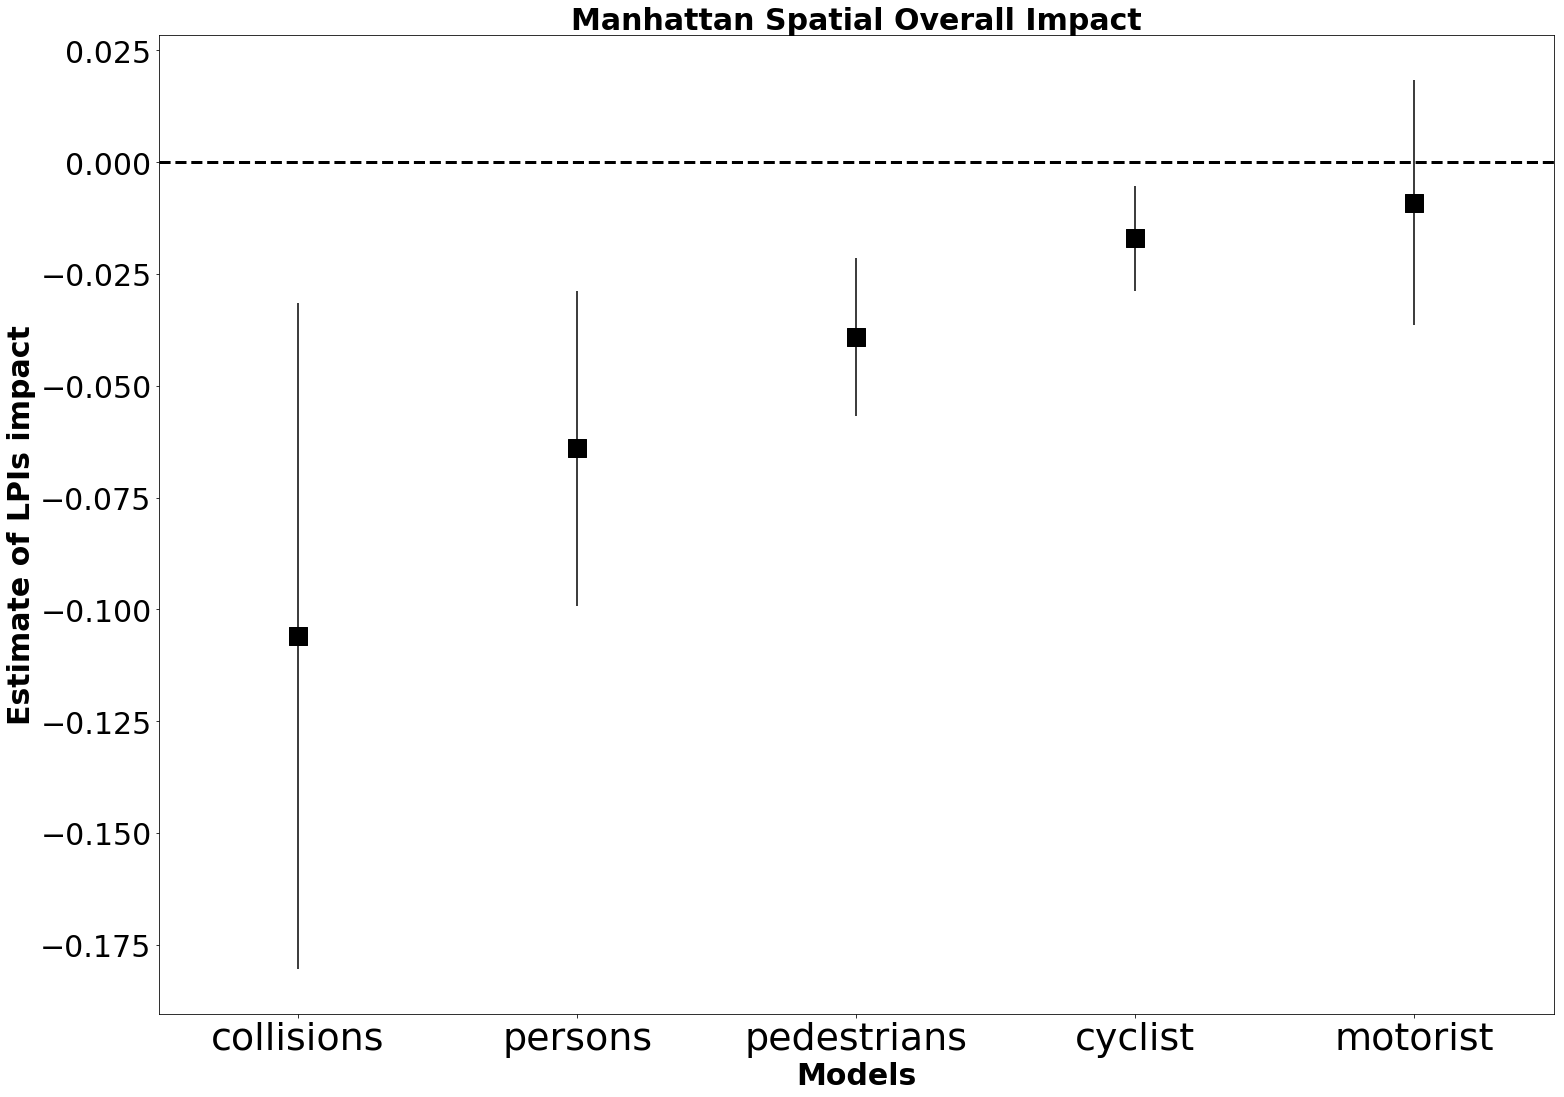

In [31]:
plt.rcParams['xtick.labelsize']=38
plt.rcParams['ytick.labelsize']=30

fig, ax = plt.subplots(figsize=(25, 18))
Manhattan_collisions_overall_df.plot(x='outcome', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='h', legend=False)
plt.title('Manhattan Spatial Overall Impact', fontsize=30,fontweight='bold')
plt.ylabel('Estimate of LPIs impact', fontsize=30,fontweight='bold')
plt.xlabel('Models', fontsize=30,fontweight='bold')
ax.scatter(x=pd.np.arange(Manhattan_collisions_overall_df.shape[0]), 
           marker='s', s=300, 
           y=Manhattan_collisions_overall_df['coef'], color='black')
ax.axhline(y=0, linestyle='--', color='black', linewidth=3)
ax.tick_params(axis='x', rotation='default')
plt.savefig('..\manuscripts\Manhattan_collisions_overall_visuals.png')

## Spatial Lagged Overall Impact Fixed Effects DiD (Manhattan)
![Manhattan_collisions_overall_visuals.png](../manuscripts/Manhattan_collisions_overall_visuals.png)

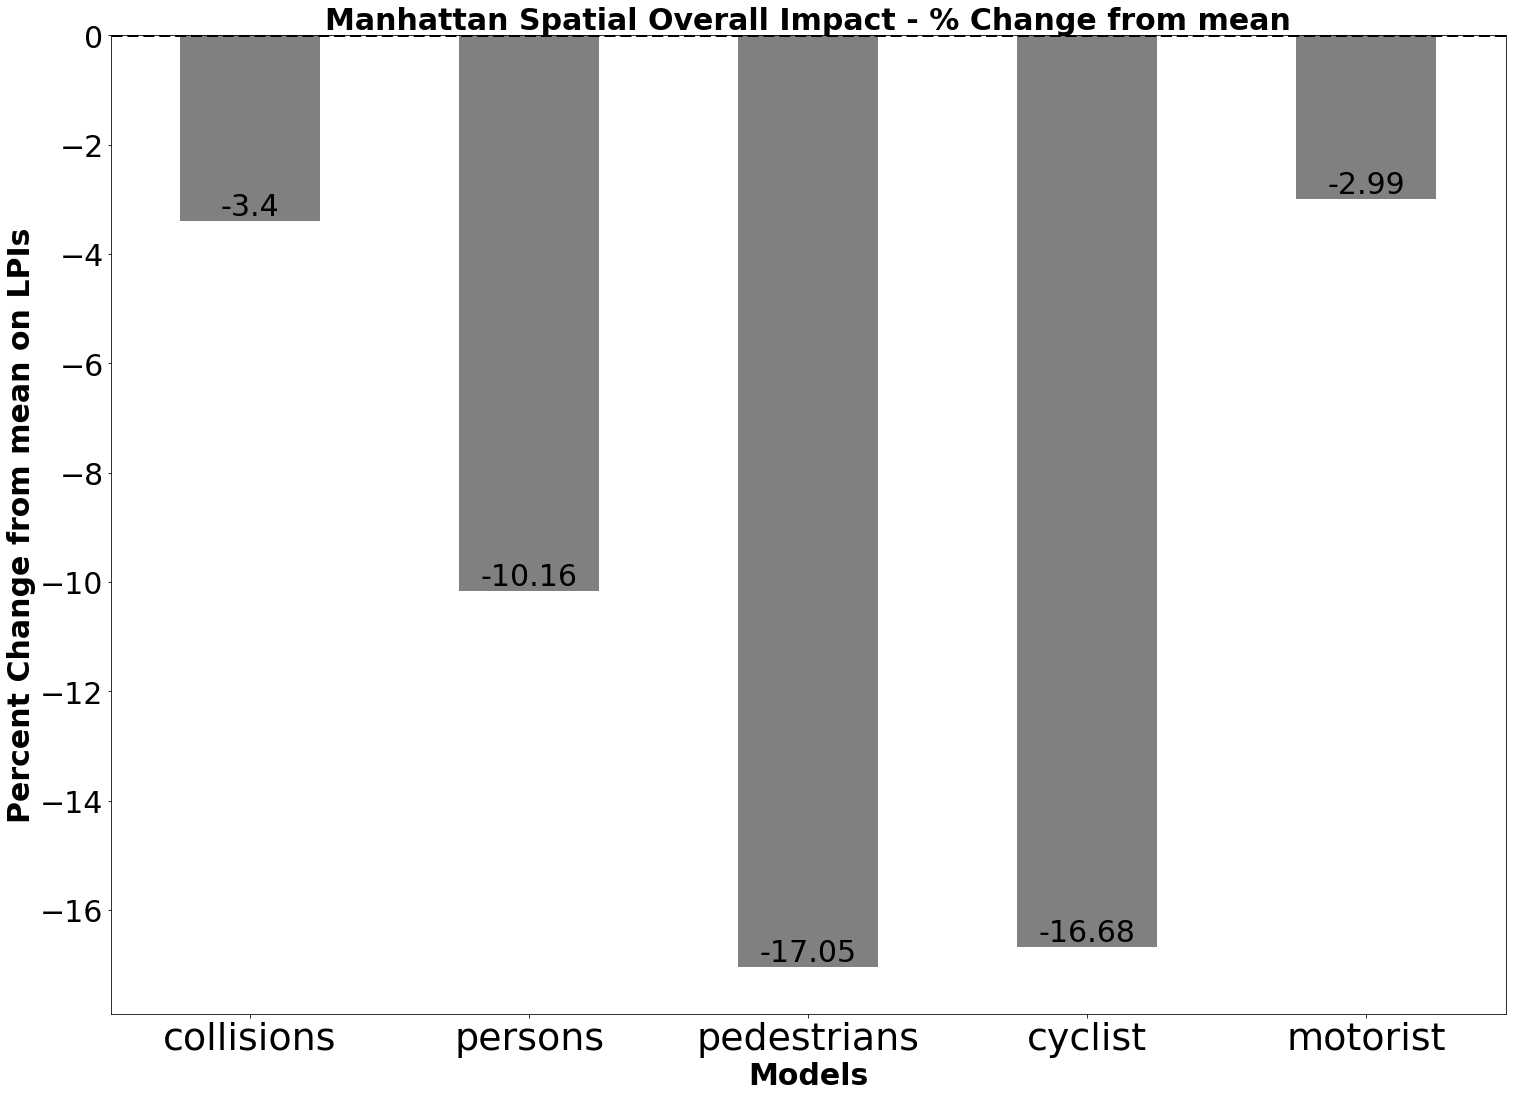

In [149]:
plt.rcParams['xtick.labelsize']=38
plt.rcParams['ytick.labelsize']=30

fig, ax = plt.subplots(figsize=(25, 18))
Manhattan_collisions_overall_df.plot(x='outcome', y='percentchange', kind='bar', 
             ax=ax, color='grey', legend=False)
plt.title('Manhattan Spatial Overall Impact - % Change from mean', fontsize=30,fontweight='bold')
plt.ylabel('Percent Change from mean on LPIs', fontsize=30,fontweight='bold')
plt.xlabel('Models', fontsize=30,fontweight='bold')

ax.axhline(y=0, linestyle='--', color='black', linewidth=3)
ax.tick_params(axis='x', rotation='default')

rects = ax.patches

# Make some labels.
labels = Manhattan_collisions_overall_df['percentchange2']

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, label,
            ha='center', va='bottom',fontsize=30)

plt.savefig('..\manuscripts\Manhattan_collisions_overall_visuals_percent.png')

## Spatial Lagged Overall Impact Fixed Effects DiD (Manhattan)
![Manhattan_collisions_overall_visuals_percent.png](../manuscripts/Manhattan_collisions_overall_visuals_percent.png)

## Manhattan Indirect

In [ ]:
Manhattan_collisions_indirect_df

In [ ]:
coef2_ = [-.0219132 ,-.0010319,-.0000231,-.0005068,-.0001126 ]
err2_ = [.0078668, .0005169,.0002578,.000208,.0001826]

Manhattan_collisions_indirect_df['coef2'] = coef2_
Manhattan_collisions_indirect_df['err2'] = err2_

confidence = 0.95
Manhattan_collisions_indirect_df['h2'] = Manhattan_collisions_indirect_df['err2'] * t. ppf((1 + confidence) / 2, Manhattan_collisions_indirect_df['n'] - 1)

In [ ]:
Manhattan_collisions_indirect_df

In [ ]:

plt.rcParams['xtick.labelsize']=38
plt.rcParams['ytick.labelsize']=30

fig, ax = plt.subplots(figsize=(25, 18))
Manhattan_collisions_indirect_df.plot(x='outcome', y='coef2', kind='bar', 
             ax=ax, color='none', 
             yerr='h2', legend=False)

plt.title('Manhattan Spatial Indirect Impact', fontsize=30,fontweight='bold')
plt.ylabel('Impact Estimates on LPIs', fontsize=30,fontweight='bold')
plt.xlabel('Models', fontsize=30,fontweight='bold')
ax.scatter(x=pd.np.arange(Manhattan_collisions_indirect_df.shape[0]), 
           marker='s', s=120, 
           y=Manhattan_collisions_indirect_df['coef2'], color='black')
ax.axhline(y=0, linestyle='--', color='black', linewidth=3)
ax.tick_params(axis='x', rotation='default')
plt.savefig('..\manuscripts\Manhattan_collisions_indirect_visuals.png')

# 4. Economic Analysis

## Cost effectiveness

* Back-of-the-envelope calculations
* Each LPIs cost \$1,200 in 2017
* Entire investment for 2,689 intersections was \$3.2 million

Federal Highway Administration report of Crash Cost Estimates by Maximum Police-Reported Injury Severity Within Selected Crash Geometries
* Mean human capital cost: \$67,342
* Mean comprehensive cost per crash: \$129,418

Using the predicted values from the persons injured model:
* 4,609 persons avoided injury at LPIs intersections
* \$12 million in human capital cost loss avoided

# 5. Conclusions

The coefficients from the non-spatial fixed effects DiD analysis of:
* number of collisions, persons and pedestrians injured 
* stayed similar in their magnitude across the different models
* suggests that results to be fairly robust

* The LPIs intervention is a very cost effective method of reducing collisions

Future work:
* Replicating the spatial analysis on the entire New York City data
* Investigate if LPIs reduces the numbers of motorists injured outside of Manhattan, since it was effective in reducing number of motorist injured in the overall model.

## Questions? 
### Thank you!

[Jeremy.Sze@outlook.com](mailto:Jeremy.Sze@outlook.com)

[https://jeremysze.github.io](https://jeremysze.github.io)

# Tables and Figures

## Table 1: Collisions counts and averages

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;border-color:#ccc;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#f0f0f0;}
.tg .tg-qtf5{border-color:#000000;text-align:left}
.tg .tg-73oq{border-color:#000000;text-align:left;vertical-align:top}
.tg .tg-i817{background-color:#f9f9f9;border-color:#000000;text-align:left;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-qtf5">Categories</th>
    <th class="tg-73oq">2012</th>
    <th class="tg-73oq">2013</th>
    <th class="tg-73oq">2014</th>
    <th class="tg-73oq">2015</th>
    <th class="tg-73oq">2016</th>
    <th class="tg-73oq">2017</th>
    <th class="tg-73oq">2018</th>
  </tr>
  <tr>
    <td class="tg-i817">A.  Collision/Injuries outcomes at Intersections</td>
    <td class="tg-i817"></td>
    <td class="tg-i817"></td>
    <td class="tg-i817"></td>
    <td class="tg-i817"></td>
    <td class="tg-i817"></td>
    <td class="tg-i817"></td>
    <td class="tg-i817"></td>
  </tr>
  <tr>
    <td class="tg-73oq">Collisions</td>
    <td class="tg-73oq">47,611</td>
    <td class="tg-73oq">95,437</td>
    <td class="tg-73oq">94,644</td>
    <td class="tg-73oq">97,792</td>
    <td class="tg-73oq">68,511</td>
    <td class="tg-73oq">78,764</td>
    <td class="tg-73oq">58,942</td>
  </tr>
  <tr>
    <td class="tg-i817">Injuries of:</td>
    <td class="tg-i817"> </td>
    <td class="tg-i817"> </td>
    <td class="tg-i817"> </td>
    <td class="tg-i817"> </td>
    <td class="tg-i817"> </td>
    <td class="tg-i817"> </td>
    <td class="tg-i817"> </td>
  </tr>
  <tr>
    <td class="tg-73oq">Persons</td>
    <td class="tg-73oq">13,336</td>
    <td class="tg-73oq">26,640</td>
    <td class="tg-73oq">24,466</td>
    <td class="tg-73oq">23,160</td>
    <td class="tg-73oq">18,611</td>
    <td class="tg-73oq">22,666</td>
    <td class="tg-73oq">17,513</td>
  </tr>
  <tr>
    <td class="tg-i817">Pedestrians</td>
    <td class="tg-i817">3,725</td>
    <td class="tg-i817">7,555</td>
    <td class="tg-i817">6,859</td>
    <td class="tg-i817">6,095</td>
    <td class="tg-i817">4,821</td>
    <td class="tg-i817">5,781</td>
    <td class="tg-i817">3,942</td>
  </tr>
  <tr>
    <td class="tg-73oq">Cyclist</td>
    <td class="tg-73oq">1,355</td>
    <td class="tg-73oq">2,569</td>
    <td class="tg-73oq">2,598</td>
    <td class="tg-73oq">2,597</td>
    <td class="tg-73oq">1,978</td>
    <td class="tg-73oq">2,339</td>
    <td class="tg-73oq">1,766</td>
  </tr>
  <tr>
    <td class="tg-i817">Motorist</td>
    <td class="tg-i817">8,250</td>
    <td class="tg-i817">16,516</td>
    <td class="tg-i817">15,008</td>
    <td class="tg-i817">14,468</td>
    <td class="tg-i817">11,911</td>
    <td class="tg-i817">14,967</td>
    <td class="tg-i817">11,706</td>
  </tr>
  <tr>
    <td class="tg-73oq">B.  Collision/Injuries counts at Intersections Stratified by LPIs</td>
    <td class="tg-73oq"></td>
    <td class="tg-73oq"></td>
    <td class="tg-73oq"></td>
    <td class="tg-73oq"></td>
    <td class="tg-73oq"></td>
    <td class="tg-73oq"></td>
    <td class="tg-73oq"></td>
  </tr>
  <tr>
    <td class="tg-i817">LPIs Ever == 1</td>
    <td class="tg-i817">13,068</td>
    <td class="tg-i817">26,101</td>
    <td class="tg-i817">25,963</td>
    <td class="tg-i817">27,244</td>
    <td class="tg-i817">18,588</td>
    <td class="tg-i817">20,173</td>
    <td class="tg-i817">15,034</td>
  </tr>
  <tr>
    <td class="tg-73oq">LPIs Ever == 0</td>
    <td class="tg-73oq">34,543</td>
    <td class="tg-73oq">69,336</td>
    <td class="tg-73oq">68,681</td>
    <td class="tg-73oq">70,548</td>
    <td class="tg-73oq">49,923</td>
    <td class="tg-73oq">58,591</td>
    <td class="tg-73oq">43,908</td>
  </tr>
  <tr>
    <td class="tg-i817">C.  Collision/Injuries averages at Intersections Stratified by LPIs</td>
    <td class="tg-i817"></td>
    <td class="tg-i817"></td>
    <td class="tg-i817"></td>
    <td class="tg-i817"></td>
    <td class="tg-i817"></td>
    <td class="tg-i817"></td>
    <td class="tg-i817"></td>
  </tr>
  <tr>
    <td class="tg-73oq">LPIs Ever == 1</td>
    <td class="tg-73oq">2.43</td>
    <td class="tg-73oq">2.43</td>
    <td class="tg-73oq">2.41</td>
    <td class="tg-73oq">2.53</td>
    <td class="tg-73oq">1.73</td>
    <td class="tg-73oq">1.88</td>
    <td class="tg-73oq">1.86</td>
  </tr>
  <tr>
    <td class="tg-i817">LPIs Ever == 0</td>
    <td class="tg-i817">1.68</td>
    <td class="tg-i817">1.68</td>
    <td class="tg-i817">1.67</td>
    <td class="tg-i817">1.71</td>
    <td class="tg-i817">1.21</td>
    <td class="tg-i817">1.42</td>
    <td class="tg-i817">1.42</td>
  </tr>
</table>

## Table 2: Collisions with longitude and latitude filled

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-dnr3{font-size:18px;border-color:#ffffff;text-align:left}
.tg .tg-fa7u{font-size:18px;border-color:#ffffff;text-align:left;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-dnr3"><br>&nbsp;&nbsp; </th>
    <th class="tg-dnr3">2012</th>
    <th class="tg-dnr3">2013</th>
    <th class="tg-dnr3">2014</th>
    <th class="tg-dnr3">2015</th>
    <th class="tg-dnr3">2016</th>
    <th class="tg-dnr3">2017</th>
    <th class="tg-dnr3">2018</th>
  </tr>
  <tr>
    <td class="tg-dnr3">Coordinates Filled</td>
    <td class="tg-dnr3">85,452</td>
    <td class="tg-dnr3">171,917</td>
    <td class="tg-dnr3">172,730</td>
    <td class="tg-dnr3">182,958</td>
    <td class="tg-dnr3">162,745</td>
    <td class="tg-dnr3">214,935</td>
    <td class="tg-dnr3">157,185</td>
  </tr>
  <tr>
    <td class="tg-dnr3">(%)</td>
    <td class="tg-dnr3">-84.99</td>
    <td class="tg-dnr3">-84.39</td>
    <td class="tg-dnr3">-83.84</td>
    <td class="tg-dnr3">-84.05</td>
    <td class="tg-dnr3">-71.44</td>
    <td class="tg-dnr3">-93.75</td>
    <td class="tg-dnr3">-94.87</td>
  </tr>
  <tr>
    <td class="tg-dnr3">Coordinates missing</td>
    <td class="tg-dnr3">15,087</td>
    <td class="tg-dnr3">31,806</td>
    <td class="tg-dnr3">33,296</td>
    <td class="tg-dnr3">34,729</td>
    <td class="tg-dnr3">65,077</td>
    <td class="tg-dnr3">14,327</td>
    <td class="tg-dnr3">8,508</td>
  </tr>
  <tr>
    <td class="tg-dnr3">(%)</td>
    <td class="tg-dnr3">-15.01</td>
    <td class="tg-dnr3">-15.61</td>
    <td class="tg-dnr3">-16.16</td>
    <td class="tg-dnr3">-15.95</td>
    <td class="tg-dnr3">-28.56</td>
    <td class="tg-dnr3">-6.25</td>
    <td class="tg-dnr3">-5.13</td>
  </tr>
  <tr>
    <td class="tg-fa7u">Total</td>
    <td class="tg-fa7u">0</td>
    <td class="tg-fa7u">13</td>
    <td class="tg-fa7u">60</td>
    <td class="tg-fa7u">408</td>
    <td class="tg-fa7u">713</td>
    <td class="tg-fa7u">825</td>
    <td class="tg-fa7u">670</td>
  </tr>
</table>

## Table 3: Number of LPIs implemented in Quarters and Years

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-dnr3{font-size:18px;border-color:#ffffff;text-align:left}
.tg .tg-fa7u{font-size:18px;border-color:#ffffff;text-align:left;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-dnr3"><br>&nbsp;&nbsp; </th>
    <th class="tg-dnr3">2012</th>
    <th class="tg-dnr3">2013</th>
    <th class="tg-dnr3">2014</th>
    <th class="tg-dnr3">2015</th>
    <th class="tg-dnr3">2016</th>
    <th class="tg-dnr3">2017</th>
    <th class="tg-dnr3">2018</th>
  </tr>
  <tr>
    <td class="tg-dnr3">Coordinates Filled</td>
    <td class="tg-dnr3">85,452</td>
    <td class="tg-dnr3">171,917</td>
    <td class="tg-dnr3">172,730</td>
    <td class="tg-dnr3">182,958</td>
    <td class="tg-dnr3">162,745</td>
    <td class="tg-dnr3">214,935</td>
    <td class="tg-dnr3">157,185</td>
  </tr>
  <tr>
    <td class="tg-dnr3">(%)</td>
    <td class="tg-dnr3">-84.99</td>
    <td class="tg-dnr3">-84.39</td>
    <td class="tg-dnr3">-83.84</td>
    <td class="tg-dnr3">-84.05</td>
    <td class="tg-dnr3">-71.44</td>
    <td class="tg-dnr3">-93.75</td>
    <td class="tg-dnr3">-94.87</td>
  </tr>
  <tr>
    <td class="tg-dnr3">Coordinates missing</td>
    <td class="tg-dnr3">15,087</td>
    <td class="tg-dnr3">31,806</td>
    <td class="tg-dnr3">33,296</td>
    <td class="tg-dnr3">34,729</td>
    <td class="tg-dnr3">65,077</td>
    <td class="tg-dnr3">14,327</td>
    <td class="tg-dnr3">8,508</td>
  </tr>
  <tr>
    <td class="tg-dnr3">(%)</td>
    <td class="tg-dnr3">-15.01</td>
    <td class="tg-dnr3">-15.61</td>
    <td class="tg-dnr3">-16.16</td>
    <td class="tg-dnr3">-15.95</td>
    <td class="tg-dnr3">-28.56</td>
    <td class="tg-dnr3">-6.25</td>
    <td class="tg-dnr3">-5.13</td>
  </tr>
  <tr>
    <td class="tg-fa7u">Total</td>
    <td class="tg-fa7u">0</td>
    <td class="tg-fa7u">13</td>
    <td class="tg-fa7u">60</td>
    <td class="tg-fa7u">408</td>
    <td class="tg-fa7u">713</td>
    <td class="tg-fa7u">825</td>
    <td class="tg-fa7u">670</td>
  </tr>
</table>

## Table 4: Characteristics of the intersections

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-dnr3{font-size:18px;border-color:#ffffff;text-align:left}
.tg .tg-fa7u{font-size:18px;border-color:#ffffff;text-align:left;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-dnr3"><br>&nbsp;&nbsp; </th>
    <th class="tg-dnr3">LPIs intersections</th>
    <th class="tg-dnr3">Control intersections</th>
  </tr>
  <tr>
    <td class="tg-dnr3">No. of intersections in New York City</td>
    <td class="tg-dnr3">2,689</td>
    <td class="tg-dnr3">10,298</td>
  </tr>
  <tr>
    <td class="tg-dnr3">School (intersections within 200 feet of school)</td>
    <td class="tg-dnr3">201</td>
    <td class="tg-dnr3">475</td>
  </tr>
  <tr>
    <td class="tg-dnr3"></td>
    <td class="tg-dnr3">-7.47%</td>
    <td class="tg-dnr3">-4.61%</td>
  </tr>
  <tr>
    <td class="tg-dnr3">Seniors<br>&nbsp;&nbsp;(intersections within safe senior zone)</td>
    <td class="tg-dnr3">859</td>
    <td class="tg-dnr3">1,717</td>
  </tr>
  <tr>
    <td class="tg-fa7u"></td>
    <td class="tg-fa7u">-31.94%</td>
    <td class="tg-fa7u">-16.67%</td>
  </tr>
  <tr>
    <td class="tg-fa7u">Priority Intersection (intersections within 10 ft of signal intersection)</td>
    <td class="tg-fa7u">110</td>
    <td class="tg-fa7u">109</td>
  </tr>
  <tr>
    <td class="tg-fa7u"></td>
    <td class="tg-fa7u">-4.09%</td>
    <td class="tg-fa7u">-1.06%</td>
  </tr>
</table>

## Table 5: Naive regression model - Number of collisions per quarter
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-6esd{font-weight:bold;font-size:14px;text-align:left}
.tg .tg-x4j0{font-size:14px;text-align:left}
.tg .tg-z9od{font-size:12px;text-align:left;vertical-align:top}
.tg .tg-na3a{font-weight:bold;font-size:14px;text-align:left;vertical-align:top}
.tg .tg-ltad{font-size:14px;text-align:left;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-6esd"><br>&nbsp;&nbsp; </th>
    <th class="tg-6esd">1</th>
    <th class="tg-6esd">2</th>
    <th class="tg-na3a">3</th>
    <th class="tg-na3a">4</th>
    <th class="tg-na3a">5</th>
    <th class="tg-na3a">6</th>
  </tr>
  <tr>
    <td class="tg-6esd">VARIABLES</td>
    <td class="tg-6esd">Poisson </td>
    <td class="tg-6esd">OLS</td>
    <td class="tg-na3a">Poisson Late night</td>
    <td class="tg-na3a">OLS Late night</td>
    <td class="tg-na3a">Poisson Non- Late night</td>
    <td class="tg-na3a">OLS Non- Late night</td>
  </tr>
  <tr>
    <td class="tg-x4j0">Flag LPIs</td>
    <td class="tg-x4j0">0.258***</td>
    <td class="tg-x4j0">0.447***</td>
    <td class="tg-ltad">0.309***</td>
    <td class="tg-ltad">0.0568***</td>
    <td class="tg-ltad">0.252***</td>
    <td class="tg-ltad">0.390***</td>
  </tr>
  <tr>
    <td class="tg-x4j0"> </td>
    <td class="tg-x4j0">-0.0253</td>
    <td class="tg-x4j0">-0.047</td>
    <td class="tg-ltad">-0.0383</td>
    <td class="tg-ltad">-0.00769</td>
    <td class="tg-ltad">-0.025</td>
    <td class="tg-ltad">-0.0415</td>
  </tr>
  <tr>
    <td class="tg-x4j0">Bike route</td>
    <td class="tg-x4j0">0.239***</td>
    <td class="tg-x4j0">0.421***</td>
    <td class="tg-ltad">0.362***</td>
    <td class="tg-ltad">0.0644***</td>
    <td class="tg-ltad">0.226***</td>
    <td class="tg-ltad">0.357***</td>
  </tr>
  <tr>
    <td class="tg-x4j0"> </td>
    <td class="tg-x4j0">-0.0219</td>
    <td class="tg-x4j0">-0.0412</td>
    <td class="tg-ltad">-0.0301</td>
    <td class="tg-ltad">-0.00594</td>
    <td class="tg-ltad">-0.0216</td>
    <td class="tg-ltad">-0.0363</td>
  </tr>
  <tr>
    <td class="tg-x4j0">Street Improvement</td>
    <td class="tg-x4j0">0.334***</td>
    <td class="tg-x4j0">0.707***</td>
    <td class="tg-ltad">0.357***</td>
    <td class="tg-ltad">0.0772***</td>
    <td class="tg-ltad">0.332***</td>
    <td class="tg-ltad">0.630***</td>
  </tr>
  <tr>
    <td class="tg-x4j0"> </td>
    <td class="tg-x4j0">-0.0737</td>
    <td class="tg-x4j0">-0.182</td>
    <td class="tg-ltad">-0.089</td>
    <td class="tg-ltad">-0.0224</td>
    <td class="tg-ltad">-0.0738</td>
    <td class="tg-ltad">-0.164</td>
  </tr>
  <tr>
    <td class="tg-ltad">Left Turn</td>
    <td class="tg-ltad">0.519***</td>
    <td class="tg-ltad">1.186***</td>
    <td class="tg-ltad">0.449***</td>
    <td class="tg-ltad">0.106***</td>
    <td class="tg-ltad">0.527***</td>
    <td class="tg-ltad">1.080***</td>
  </tr>
  <tr>
    <td class="tg-ltad">&nbsp;&nbsp;</td>
    <td class="tg-ltad">-0.0608</td>
    <td class="tg-ltad">-0.176</td>
    <td class="tg-ltad">-0.11</td>
    <td class="tg-ltad">-0.0327</td>
    <td class="tg-ltad">-0.0587</td>
    <td class="tg-ltad">-0.152</td>
  </tr>
  <tr>
    <td class="tg-z9od"> </td>
    <td class="tg-z9od"> </td>
    <td class="tg-z9od"> </td>
    <td class="tg-z9od"> </td>
    <td class="tg-z9od"> </td>
    <td class="tg-z9od"> </td>
    <td class="tg-z9od"> </td>
  </tr>
  <tr>
    <td class="tg-ltad">Observations</td>
    <td class="tg-ltad">324,675</td>
    <td class="tg-ltad">324,675</td>
    <td class="tg-ltad">324,675</td>
    <td class="tg-ltad">324,675</td>
    <td class="tg-ltad">324,675</td>
    <td class="tg-ltad">324,675<br>&nbsp;&nbsp;</td>
  </tr>
</table>

## Table 6: Fixed effect DiD model - Number of collisions per quarter

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-6esd{font-weight:bold;font-size:14px;text-align:left}
.tg .tg-x4j0{font-size:14px;text-align:left}
.tg .tg-z9od{font-size:12px;text-align:left;vertical-align:top}
.tg .tg-na3a{font-weight:bold;font-size:14px;text-align:left;vertical-align:top}
.tg .tg-ltad{font-size:14px;text-align:left;vertical-align:top}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-6esd"> </th>
    <th class="tg-6esd">1</th>
    <th class="tg-6esd">2</th>
    <th class="tg-na3a">3</th>
    <th class="tg-na3a">4</th>
    <th class="tg-na3a">5</th>
    <th class="tg-na3a">6</th>
  </tr>
  <tr>
    <td class="tg-6esd">VARIABLES</td>
    <td class="tg-6esd">Fixed effects<br>&nbsp;&nbsp;poisson </td>
    <td class="tg-6esd">Fixed effects<br>&nbsp;&nbsp;regression</td>
    <td class="tg-na3a">Fixed effects<br>&nbsp;&nbsp;poisson  Late night</td>
    <td class="tg-na3a">Fixed effects<br>&nbsp;&nbsp;regression Late night</td>
    <td class="tg-na3a">Fixed effects<br>&nbsp;&nbsp;poisson Non-Late night</td>
    <td class="tg-na3a">Fixed effects<br>&nbsp;&nbsp;regression Non-Late night</td>
  </tr>
  <tr>
    <td class="tg-x4j0">Flag LPIs</td>
    <td class="tg-x4j0">-0.0545***</td>
    <td class="tg-x4j0">-0.162***</td>
    <td class="tg-ltad">-0.00245</td>
    <td class="tg-ltad">-0.00039</td>
    <td class="tg-ltad">-0.0604***</td>
    <td class="tg-ltad">-0.161***</td>
  </tr>
  <tr>
    <td class="tg-x4j0"> </td>
    <td class="tg-x4j0">-0.0128</td>
    <td class="tg-x4j0">-0.0305</td>
    <td class="tg-ltad">-0.0255</td>
    <td class="tg-ltad">-0.00628</td>
    <td class="tg-ltad">-0.013</td>
    <td class="tg-ltad">-0.0279</td>
  </tr>
  <tr>
    <td class="tg-x4j0">Bike route</td>
    <td class="tg-x4j0">0.0233</td>
    <td class="tg-x4j0">0.0521</td>
    <td class="tg-ltad">0.0421</td>
    <td class="tg-ltad">0.0101</td>
    <td class="tg-ltad">0.0217</td>
    <td class="tg-ltad">0.0434</td>
  </tr>
  <tr>
    <td class="tg-x4j0"> </td>
    <td class="tg-x4j0">-0.0189</td>
    <td class="tg-x4j0">-0.0379</td>
    <td class="tg-ltad">-0.04</td>
    <td class="tg-ltad">-0.00865</td>
    <td class="tg-ltad">-0.0189</td>
    <td class="tg-ltad">-0.0345</td>
  </tr>
  <tr>
    <td class="tg-x4j0">Street Improvement</td>
    <td class="tg-x4j0">-0.0157</td>
    <td class="tg-x4j0">-0.209</td>
    <td class="tg-ltad">-0.0133</td>
    <td class="tg-ltad">-0.016</td>
    <td class="tg-ltad">-0.0172</td>
    <td class="tg-ltad">-0.195</td>
  </tr>
  <tr>
    <td class="tg-x4j0"> </td>
    <td class="tg-x4j0">-0.0449</td>
    <td class="tg-x4j0">-0.148</td>
    <td class="tg-ltad">-0.0661</td>
    <td class="tg-ltad">-0.0234</td>
    <td class="tg-ltad">-0.0458</td>
    <td class="tg-ltad">-0.135</td>
  </tr>
  <tr>
    <td class="tg-ltad">Left Turn</td>
    <td class="tg-ltad">-0.140***</td>
    <td class="tg-ltad">-0.806***</td>
    <td class="tg-ltad">-0.133*</td>
    <td class="tg-ltad">-0.0683**</td>
    <td class="tg-ltad">-0.139***</td>
    <td class="tg-ltad">-0.742***</td>
  </tr>
  <tr>
    <td class="tg-ltad"> </td>
    <td class="tg-ltad">-0.0369</td>
    <td class="tg-ltad">-0.174</td>
    <td class="tg-ltad">-0.0741</td>
    <td class="tg-ltad">-0.0274</td>
    <td class="tg-ltad">-0.0384</td>
    <td class="tg-ltad">-0.162</td>
  </tr>
  <tr>
    <td class="tg-z9od"></td>
    <td class="tg-z9od"></td>
    <td class="tg-z9od"></td>
    <td class="tg-z9od"></td>
    <td class="tg-z9od"></td>
    <td class="tg-z9od"></td>
    <td class="tg-z9od"></td>
  </tr>
  <tr>
    <td class="tg-ltad">Observations</td>
    <td class="tg-ltad">283,550</td>
    <td class="tg-ltad">283,550</td>
    <td class="tg-ltad">242,725</td>
    <td class="tg-ltad">242,725</td>
    <td class="tg-ltad">283,200</td>
    <td class="tg-ltad">283,200</td>
  </tr>
  <tr>
    <td class="tg-0lax">Number of intersection_id</td>
    <td class="tg-0lax">11,342</td>
    <td class="tg-0lax">11,342</td>
    <td class="tg-0lax">9,709</td>
    <td class="tg-0lax">9,709</td>
    <td class="tg-0lax">11,328</td>
    <td class="tg-0lax">11,328</td>
  </tr>
  <tr>
    <td class="tg-0lax">Number of intersection_id</td>
    <td class="tg-0lax">11,342</td>
    <td class="tg-0lax">11,342</td>
    <td class="tg-0lax">9,709</td>
    <td class="tg-0lax">9,709</td>
    <td class="tg-0lax">11,328</td>
    <td class="tg-0lax">11,328<br>&nbsp;&nbsp;</td>
  </tr>
</table>

## Table 7: Fixed effect DiD model - Number of persons injured per quarter
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-6esd{font-weight:bold;font-size:14px;text-align:left}
.tg .tg-x4j0{font-size:14px;text-align:left}
.tg .tg-z9od{font-size:12px;text-align:left;vertical-align:top}
.tg .tg-na3a{font-weight:bold;font-size:14px;text-align:left;vertical-align:top}
.tg .tg-ltad{font-size:14px;text-align:left;vertical-align:top}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-6esd"> </th>
    <th class="tg-6esd">1</th>
    <th class="tg-6esd">2</th>
    <th class="tg-na3a">3</th>
    <th class="tg-na3a">4</th>
    <th class="tg-na3a">5</th>
    <th class="tg-na3a">6</th>
  </tr>
  <tr>
    <td class="tg-6esd">VARIABLES</td>
    <td class="tg-6esd">Fixed effects<br>&nbsp;&nbsp;poisson </td>
    <td class="tg-6esd">Fixed effects<br>&nbsp;&nbsp;regression</td>
    <td class="tg-na3a">Fixed effects<br>&nbsp;&nbsp;poisson  Late night</td>
    <td class="tg-na3a">Fixed effects<br>&nbsp;&nbsp;regression Late night</td>
    <td class="tg-na3a">Fixed effects<br>&nbsp;&nbsp;poisson Non-Late night</td>
    <td class="tg-na3a">Fixed effects<br>&nbsp;&nbsp;regression Non-Late night</td>
  </tr>
  <tr>
    <td class="tg-x4j0">Flag LPIs</td>
    <td class="tg-x4j0">-0.0993***</td>
    <td class="tg-x4j0">-0.0692***</td>
    <td class="tg-ltad">-0.111**</td>
    <td class="tg-ltad">-0.0145**</td>
    <td class="tg-ltad">-0.0980***</td>
    <td class="tg-ltad">-0.0603***</td>
  </tr>
  <tr>
    <td class="tg-x4j0"> </td>
    <td class="tg-x4j0">-0.0213</td>
    <td class="tg-x4j0">-0.0134</td>
    <td class="tg-ltad">-0.054</td>
    <td class="tg-ltad">-0.00722</td>
    <td class="tg-ltad">-0.0221</td>
    <td class="tg-ltad">-0.0122</td>
  </tr>
  <tr>
    <td class="tg-x4j0">Bike route</td>
    <td class="tg-x4j0">0.0169</td>
    <td class="tg-x4j0">0.01</td>
    <td class="tg-ltad">-0.00445</td>
    <td class="tg-ltad">-0.000199</td>
    <td class="tg-ltad">0.0193</td>
    <td class="tg-ltad">0.0103</td>
  </tr>
  <tr>
    <td class="tg-x4j0"> </td>
    <td class="tg-x4j0">-0.0307</td>
    <td class="tg-x4j0">-0.0166</td>
    <td class="tg-ltad">-0.0789</td>
    <td class="tg-ltad">-0.00986</td>
    <td class="tg-ltad">-0.0316</td>
    <td class="tg-ltad">-0.015</td>
  </tr>
  <tr>
    <td class="tg-x4j0">Street Improvement</td>
    <td class="tg-x4j0">-0.0272</td>
    <td class="tg-x4j0">-0.041</td>
    <td class="tg-ltad">-0.106</td>
    <td class="tg-ltad">-0.0187</td>
    <td class="tg-ltad">-0.0167</td>
    <td class="tg-ltad">-0.0287</td>
  </tr>
  <tr>
    <td class="tg-x4j0"> </td>
    <td class="tg-x4j0">-0.0545</td>
    <td class="tg-x4j0">-0.0434</td>
    <td class="tg-ltad">-0.17</td>
    <td class="tg-ltad">-0.028</td>
    <td class="tg-ltad">-0.0557</td>
    <td class="tg-ltad">-0.0388</td>
  </tr>
  <tr>
    <td class="tg-ltad">Left Turn</td>
    <td class="tg-ltad">-0.200***</td>
    <td class="tg-ltad">-0.217***</td>
    <td class="tg-ltad">-0.25</td>
    <td class="tg-ltad">-0.0483*</td>
    <td class="tg-ltad">-0.193***</td>
    <td class="tg-ltad">-0.185***</td>
  </tr>
  <tr>
    <td class="tg-ltad"> </td>
    <td class="tg-ltad">-0.066</td>
    <td class="tg-ltad">-0.0623</td>
    <td class="tg-ltad">-0.156</td>
    <td class="tg-ltad">-0.0272</td>
    <td class="tg-ltad">-0.0675</td>
    <td class="tg-ltad">-0.0552</td>
  </tr>
  <tr>
    <td class="tg-z9od"> </td>
    <td class="tg-z9od"> </td>
    <td class="tg-z9od"> </td>
    <td class="tg-z9od"> </td>
    <td class="tg-z9od"> </td>
    <td class="tg-z9od"> </td>
    <td class="tg-z9od"> </td>
  </tr>
  <tr>
    <td class="tg-ltad">Observations</td>
    <td class="tg-ltad">273,875</td>
    <td class="tg-ltad">273,875</td>
    <td class="tg-ltad">146,725</td>
    <td class="tg-ltad">146,725</td>
    <td class="tg-ltad">272,000</td>
    <td class="tg-ltad">272,000</td>
  </tr>
  <tr>
    <td class="tg-0lax">Number of intersection_id</td>
    <td class="tg-0lax">10,955</td>
    <td class="tg-0lax">10,955</td>
    <td class="tg-0lax">5,869</td>
    <td class="tg-0lax">5,869</td>
    <td class="tg-0lax">10,880</td>
    <td class="tg-0lax">10,880<br>&nbsp;&nbsp;</td>
  </tr>
  <tr>
    <td class="tg-0lax">Number of intersection_id</td>
    <td class="tg-0lax">11,342</td>
    <td class="tg-0lax">11,342</td>
    <td class="tg-0lax">9,709</td>
    <td class="tg-0lax">9,709</td>
    <td class="tg-0lax">11,328</td>
    <td class="tg-0lax">11,328<br>&nbsp;&nbsp;</td>
  </tr>
</table>

## Table 8: Fixed effect DiD model - Number of pedestrians injured per quarter
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-6esd{font-weight:bold;font-size:14px;text-align:left}
.tg .tg-x4j0{font-size:14px;text-align:left}
.tg .tg-z9od{font-size:12px;text-align:left;vertical-align:top}
.tg .tg-na3a{font-weight:bold;font-size:14px;text-align:left;vertical-align:top}
.tg .tg-ltad{font-size:14px;text-align:left;vertical-align:top}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-6esd"> </th>
    <th class="tg-6esd">1</th>
    <th class="tg-6esd">2</th>
    <th class="tg-na3a">3</th>
    <th class="tg-na3a">4</th>
    <th class="tg-na3a">5</th>
    <th class="tg-na3a">6</th>
  </tr>
  <tr>
    <td class="tg-6esd">VARIABLES</td>
    <td class="tg-6esd">Fixed effects<br>&nbsp;&nbsp;poisson </td>
    <td class="tg-6esd">Fixed effects<br>&nbsp;&nbsp;regression</td>
    <td class="tg-na3a">Fixed effects<br>&nbsp;&nbsp;poisson  Late night</td>
    <td class="tg-na3a">Fixed effects<br>&nbsp;&nbsp;regression Late night</td>
    <td class="tg-na3a">Fixed effects<br>&nbsp;&nbsp;poisson Non-Late night</td>
    <td class="tg-na3a">Fixed effects<br>&nbsp;&nbsp;regression Non-Late night</td>
  </tr>
  <tr>
    <td class="tg-x4j0">Flag LPIs</td>
    <td class="tg-x4j0">-0.147***</td>
    <td class="tg-x4j0">-0.0337***</td>
    <td class="tg-ltad">-0.0895</td>
    <td class="tg-ltad">-0.00493</td>
    <td class="tg-ltad">-0.153***</td>
    <td class="tg-ltad">-0.0329***</td>
  </tr>
  <tr>
    <td class="tg-x4j0"> </td>
    <td class="tg-x4j0">-0.0289</td>
    <td class="tg-x4j0">-0.00569</td>
    <td class="tg-ltad">-0.088</td>
    <td class="tg-ltad">-0.00529</td>
    <td class="tg-ltad">-0.0303</td>
    <td class="tg-ltad">-0.00547</td>
  </tr>
  <tr>
    <td class="tg-x4j0">Bike route</td>
    <td class="tg-x4j0">-0.0789*</td>
    <td class="tg-x4j0">-0.0129*</td>
    <td class="tg-ltad">-0.0592</td>
    <td class="tg-ltad">-0.00251</td>
    <td class="tg-ltad">-0.0799*</td>
    <td class="tg-ltad">-0.0123*</td>
  </tr>
  <tr>
    <td class="tg-x4j0"> </td>
    <td class="tg-x4j0">-0.0419</td>
    <td class="tg-x4j0">-0.00749</td>
    <td class="tg-ltad">-0.131</td>
    <td class="tg-ltad">-0.00773</td>
    <td class="tg-ltad">-0.0445</td>
    <td class="tg-ltad">-0.00741</td>
  </tr>
  <tr>
    <td class="tg-x4j0">Street Improvement</td>
    <td class="tg-x4j0">-0.0391</td>
    <td class="tg-x4j0">-0.0208</td>
    <td class="tg-ltad">-0.125</td>
    <td class="tg-ltad">-0.00877</td>
    <td class="tg-ltad">-0.0312</td>
    <td class="tg-ltad">-0.0168</td>
  </tr>
  <tr>
    <td class="tg-x4j0"> </td>
    <td class="tg-x4j0">-0.0744</td>
    <td class="tg-x4j0">-0.0194</td>
    <td class="tg-ltad">-0.236</td>
    <td class="tg-ltad">-0.0159</td>
    <td class="tg-ltad">-0.0849</td>
    <td class="tg-ltad">-0.02</td>
  </tr>
  <tr>
    <td class="tg-ltad">Left Turn</td>
    <td class="tg-ltad">-0.302***</td>
    <td class="tg-ltad">-0.147***</td>
    <td class="tg-ltad">-0.199</td>
    <td class="tg-ltad">-0.0198</td>
    <td class="tg-ltad">-0.311***</td>
    <td class="tg-ltad">-0.136***</td>
  </tr>
  <tr>
    <td class="tg-ltad"> </td>
    <td class="tg-ltad">-0.0718</td>
    <td class="tg-ltad">-0.0264</td>
    <td class="tg-ltad">-0.204</td>
    <td class="tg-ltad">-0.0148</td>
    <td class="tg-ltad">-0.0804</td>
    <td class="tg-ltad">-0.0259</td>
  </tr>
  <tr>
    <td class="tg-z9od"> </td>
    <td class="tg-z9od"> </td>
    <td class="tg-z9od"> </td>
    <td class="tg-z9od"> </td>
    <td class="tg-z9od"> </td>
    <td class="tg-z9od"> </td>
    <td class="tg-z9od"> </td>
  </tr>
  <tr>
    <td class="tg-ltad">Observations</td>
    <td class="tg-ltad">223,100</td>
    <td class="tg-ltad">223,100</td>
    <td class="tg-ltad">58,475</td>
    <td class="tg-ltad">58,475</td>
    <td class="tg-ltad">218,675</td>
    <td class="tg-ltad">218,675</td>
  </tr>
  <tr>
    <td class="tg-0lax">Number of intersection_id</td>
    <td class="tg-0lax">8,924</td>
    <td class="tg-0lax">8,924</td>
    <td class="tg-0lax">2,339</td>
    <td class="tg-0lax">2,339</td>
    <td class="tg-0lax">8,747</td>
    <td class="tg-0lax">8,747<br>&nbsp;&nbsp;</td>
  </tr>
  <tr>
    <td class="tg-0lax">Number of intersection_id</td>
    <td class="tg-0lax">11,342</td>
    <td class="tg-0lax">11,342</td>
    <td class="tg-0lax">9,709</td>
    <td class="tg-0lax">9,709</td>
    <td class="tg-0lax">11,328</td>
    <td class="tg-0lax">11,328<br>&nbsp;&nbsp;</td>
  </tr>
</table>

## Table 9: Fixed effect DiD model - Number of cyclists injured per quarter
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-6esd{font-weight:bold;font-size:14px;text-align:left}
.tg .tg-x4j0{font-size:14px;text-align:left}
.tg .tg-z9od{font-size:12px;text-align:left;vertical-align:top}
.tg .tg-na3a{font-weight:bold;font-size:14px;text-align:left;vertical-align:top}
.tg .tg-ltad{font-size:14px;text-align:left;vertical-align:top}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-6esd"> </th>
    <th class="tg-6esd">1</th>
    <th class="tg-6esd">2</th>
    <th class="tg-na3a">3</th>
    <th class="tg-na3a">4</th>
    <th class="tg-na3a">5</th>
    <th class="tg-na3a">6</th>
  </tr>
  <tr>
    <td class="tg-6esd">VARIABLES</td>
    <td class="tg-6esd">Fixed effects<br>&nbsp;&nbsp;poisson </td>
    <td class="tg-6esd">Fixed effects<br>&nbsp;&nbsp;regression</td>
    <td class="tg-na3a">Fixed effects<br>&nbsp;&nbsp;poisson  Late night</td>
    <td class="tg-na3a">Fixed effects<br>&nbsp;&nbsp;regression Late night</td>
    <td class="tg-na3a">Fixed effects<br>&nbsp;&nbsp;poisson Non-Late night</td>
    <td class="tg-na3a">Fixed effects<br>&nbsp;&nbsp;regression Non-Late night</td>
  </tr>
  <tr>
    <td class="tg-x4j0">Flag LPIs</td>
    <td class="tg-x4j0">-0.0272</td>
    <td class="tg-x4j0">-0.00275</td>
    <td class="tg-ltad">0.0632</td>
    <td class="tg-ltad">0.00269</td>
    <td class="tg-ltad">-0.0376</td>
    <td class="tg-ltad">-0.00357</td>
  </tr>
  <tr>
    <td class="tg-x4j0"> </td>
    <td class="tg-x4j0">-0.0418</td>
    <td class="tg-x4j0">-0.00431</td>
    <td class="tg-ltad">-0.13</td>
    <td class="tg-ltad">-0.00617</td>
    <td class="tg-ltad">-0.0437</td>
    <td class="tg-ltad">-0.00423</td>
  </tr>
  <tr>
    <td class="tg-x4j0">Bike route</td>
    <td class="tg-x4j0">0.172***</td>
    <td class="tg-x4j0">0.0157***</td>
    <td class="tg-ltad">0.0532</td>
    <td class="tg-ltad">0.00229</td>
    <td class="tg-ltad">0.184***</td>
    <td class="tg-ltad">0.0161***</td>
  </tr>
  <tr>
    <td class="tg-x4j0"> </td>
    <td class="tg-x4j0">-0.0643</td>
    <td class="tg-x4j0">-0.00585</td>
    <td class="tg-ltad">-0.204</td>
    <td class="tg-ltad">-0.00951</td>
    <td class="tg-ltad">-0.0677</td>
    <td class="tg-ltad">-0.00584</td>
  </tr>
  <tr>
    <td class="tg-x4j0">Street Improvement</td>
    <td class="tg-x4j0">0.0935</td>
    <td class="tg-x4j0">0.00912</td>
    <td class="tg-ltad">0.252</td>
    <td class="tg-ltad">0.0121</td>
    <td class="tg-ltad">0.0788</td>
    <td class="tg-ltad">0.00728</td>
  </tr>
  <tr>
    <td class="tg-x4j0"> </td>
    <td class="tg-x4j0">-0.116</td>
    <td class="tg-x4j0">-0.0125</td>
    <td class="tg-ltad">-0.33</td>
    <td class="tg-ltad">-0.0163</td>
    <td class="tg-ltad">-0.124</td>
    <td class="tg-ltad">-0.0125</td>
  </tr>
  <tr>
    <td class="tg-ltad">Left Turn</td>
    <td class="tg-ltad">-0.206*</td>
    <td class="tg-ltad">-0.0309*</td>
    <td class="tg-ltad">-0.291</td>
    <td class="tg-ltad">-0.0155</td>
    <td class="tg-ltad">-0.199</td>
    <td class="tg-ltad">-0.0272*</td>
  </tr>
  <tr>
    <td class="tg-ltad"> </td>
    <td class="tg-ltad">-0.122</td>
    <td class="tg-ltad">-0.0158</td>
    <td class="tg-ltad">-0.339</td>
    <td class="tg-ltad">-0.0186</td>
    <td class="tg-ltad">-0.133</td>
    <td class="tg-ltad">-0.0158</td>
  </tr>
  <tr>
    <td class="tg-z9od"> </td>
    <td class="tg-z9od"> </td>
    <td class="tg-z9od"> </td>
    <td class="tg-z9od"> </td>
    <td class="tg-z9od"> </td>
    <td class="tg-z9od"> </td>
    <td class="tg-z9od"> </td>
  </tr>
  <tr>
    <td class="tg-ltad">Observations</td>
    <td class="tg-ltad">158,275</td>
    <td class="tg-ltad">158,275</td>
    <td class="tg-ltad">27,575</td>
    <td class="tg-ltad">27,575</td>
    <td class="tg-ltad">152,775</td>
    <td class="tg-ltad">152,775</td>
  </tr>
  <tr>
    <td class="tg-0lax">Number of intersection_id</td>
    <td class="tg-0lax">6,331</td>
    <td class="tg-0lax">6,331</td>
    <td class="tg-0lax">1,103</td>
    <td class="tg-0lax">1,103</td>
    <td class="tg-0lax">6,111</td>
    <td class="tg-0lax">6,111<br>&nbsp;&nbsp;</td>
  </tr>
  <tr>
    <td class="tg-0lax">Number of intersection_id</td>
    <td class="tg-0lax">11,342</td>
    <td class="tg-0lax">11,342</td>
    <td class="tg-0lax">9,709</td>
    <td class="tg-0lax">9,709</td>
    <td class="tg-0lax">11,328</td>
    <td class="tg-0lax">11,328<br>&nbsp;&nbsp;</td>
  </tr>
</table>

## Table 10: Fixed effect DiD model - Number of motorists injured per quarter
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-6esd{font-weight:bold;font-size:14px;text-align:left}
.tg .tg-x4j0{font-size:14px;text-align:left}
.tg .tg-z9od{font-size:12px;text-align:left;vertical-align:top}
.tg .tg-na3a{font-weight:bold;font-size:14px;text-align:left;vertical-align:top}
.tg .tg-ltad{font-size:14px;text-align:left;vertical-align:top}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-6esd"> </th>
    <th class="tg-6esd">1</th>
    <th class="tg-6esd">2</th>
    <th class="tg-na3a">3</th>
    <th class="tg-na3a">4</th>
    <th class="tg-na3a">5</th>
    <th class="tg-na3a">6</th>
  </tr>
  <tr>
    <td class="tg-6esd">VARIABLES</td>
    <td class="tg-6esd">Fixed effects<br>&nbsp;&nbsp;poisson </td>
    <td class="tg-6esd">Fixed effects<br>&nbsp;&nbsp;regression</td>
    <td class="tg-na3a">Fixed effects<br>&nbsp;&nbsp;poisson  Late night</td>
    <td class="tg-na3a">Fixed effects<br>&nbsp;&nbsp;regression Late night</td>
    <td class="tg-na3a">Fixed effects<br>&nbsp;&nbsp;poisson Non-Late night</td>
    <td class="tg-na3a">Fixed effects<br>&nbsp;&nbsp;regression Non-Late night</td>
  </tr>
  <tr>
    <td class="tg-x4j0">Flag LPIs</td>
    <td class="tg-x4j0">-0.0856***</td>
    <td class="tg-x4j0">-0.0362***</td>
    <td class="tg-ltad">-0.129*</td>
    <td class="tg-ltad">-0.0163*</td>
    <td class="tg-ltad">-0.0778**</td>
    <td class="tg-ltad">-0.0284***</td>
  </tr>
  <tr>
    <td class="tg-x4j0"> </td>
    <td class="tg-x4j0">-0.029</td>
    <td class="tg-x4j0">-0.0119</td>
    <td class="tg-ltad">-0.0676</td>
    <td class="tg-ltad">-0.0084</td>
    <td class="tg-ltad">-0.0311</td>
    <td class="tg-ltad">-0.0109</td>
  </tr>
  <tr>
    <td class="tg-x4j0">Bike route</td>
    <td class="tg-x4j0">0.0359</td>
    <td class="tg-x4j0">0.013</td>
    <td class="tg-ltad">0.00446</td>
    <td class="tg-ltad">0.000949</td>
    <td class="tg-ltad">0.0399</td>
    <td class="tg-ltad">0.0127</td>
  </tr>
  <tr>
    <td class="tg-x4j0"> </td>
    <td class="tg-x4j0">-0.0419</td>
    <td class="tg-x4j0">-0.0149</td>
    <td class="tg-ltad">-0.0974</td>
    <td class="tg-ltad">-0.0118</td>
    <td class="tg-ltad">-0.044</td>
    <td class="tg-ltad">-0.0136</td>
  </tr>
  <tr>
    <td class="tg-x4j0">Street Improvement</td>
    <td class="tg-x4j0">-0.0357</td>
    <td class="tg-x4j0">-0.0271</td>
    <td class="tg-ltad">-0.12</td>
    <td class="tg-ltad">-0.0172</td>
    <td class="tg-ltad">-0.0216</td>
    <td class="tg-ltad">-0.0171</td>
  </tr>
  <tr>
    <td class="tg-x4j0"> </td>
    <td class="tg-x4j0">-0.0751</td>
    <td class="tg-x4j0">-0.0389</td>
    <td class="tg-ltad">-0.219</td>
    <td class="tg-ltad">-0.0322</td>
    <td class="tg-ltad">-0.0758</td>
    <td class="tg-ltad">-0.0337</td>
  </tr>
  <tr>
    <td class="tg-ltad">Left Turn</td>
    <td class="tg-ltad">-0.0792</td>
    <td class="tg-ltad">-0.0408</td>
    <td class="tg-ltad">-0.216</td>
    <td class="tg-ltad">-0.0319</td>
    <td class="tg-ltad">-0.0525</td>
    <td class="tg-ltad">-0.0236</td>
  </tr>
  <tr>
    <td class="tg-ltad"> </td>
    <td class="tg-ltad">-0.103</td>
    <td class="tg-ltad">-0.0518</td>
    <td class="tg-ltad">-0.217</td>
    <td class="tg-ltad">-0.03</td>
    <td class="tg-ltad">-0.107</td>
    <td class="tg-ltad">-0.0461</td>
  </tr>
  <tr>
    <td class="tg-z9od"> </td>
    <td class="tg-z9od"> </td>
    <td class="tg-z9od"> </td>
    <td class="tg-z9od"> </td>
    <td class="tg-z9od"> </td>
    <td class="tg-z9od"> </td>
    <td class="tg-z9od"> </td>
  </tr>
  <tr>
    <td class="tg-ltad">Observations</td>
    <td class="tg-ltad">254,400</td>
    <td class="tg-ltad">254,400</td>
    <td class="tg-ltad">113,775</td>
    <td class="tg-ltad">113,775</td>
    <td class="tg-ltad">248,025</td>
    <td class="tg-ltad">248,025</td>
  </tr>
  <tr>
    <td class="tg-0lax">Number of intersection_id</td>
    <td class="tg-0lax">10,176</td>
    <td class="tg-0lax">10,176</td>
    <td class="tg-0lax">4,551</td>
    <td class="tg-0lax">4,551</td>
    <td class="tg-0lax">9,921</td>
    <td class="tg-0lax">9,921<br>&nbsp;&nbsp;</td>
  </tr>
  <tr>
    <td class="tg-0lax">Number of intersection_id</td>
    <td class="tg-0lax">11,342</td>
    <td class="tg-0lax">11,342</td>
    <td class="tg-0lax">9,709</td>
    <td class="tg-0lax">9,709</td>
    <td class="tg-0lax">11,328</td>
    <td class="tg-0lax">11,328<br>&nbsp;&nbsp;</td>
  </tr>
</table>

## Table 11: Fixed effects DiD Spatial Lag Model of Manhattan Intersections
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-s268{text-align:left}
.tg .tg-5ua9{font-weight:bold;text-align:left}
.tg .tg-hgcj{font-weight:bold;text-align:center}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-s268"><br>&nbsp;&nbsp; </th>
    <th class="tg-5ua9">1</th>
    <th class="tg-5ua9">2</th>
    <th class="tg-5ua9">3</th>
    <th class="tg-5ua9">4</th>
    <th class="tg-5ua9">5</th>
  </tr>
  <tr>
    <td class="tg-5ua9">VARIABLES</td>
    <td class="tg-5ua9">Number of Collisions</td>
    <td class="tg-5ua9">Number of Person injured</td>
    <td class="tg-5ua9">Number of Pedestrians injured</td>
    <td class="tg-5ua9">Number of Cyclists injured</td>
    <td class="tg-5ua9">Number of Motorist Injured<br></td>
  </tr>
  <tr>
    <td class="tg-s268"><br>&nbsp;&nbsp;<br>&nbsp;&nbsp;Flag LPIs</td>
    <td class="tg-s268">-0.106***</td>
    <td class="tg-s268">-0.0643***</td>
    <td class="tg-s268">-0.0389***</td>
    <td class="tg-s268">-0.0166***</td>
    <td class="tg-s268">-0.00897</td>
  </tr>
  <tr>
    <td class="tg-s268"> </td>
    <td class="tg-s268">-0.0377</td>
    <td class="tg-s268">-0.0176</td>
    <td class="tg-s268">-0.00894</td>
    <td class="tg-s268">-0.00569</td>
    <td class="tg-s268">-0.0137</td>
  </tr>
  <tr>
    <td class="tg-s268">W.outcome</td>
    <td class="tg-s268">0.188***</td>
    <td class="tg-s268">0.0171**</td>
    <td class="tg-s268">0.00064</td>
    <td class="tg-s268">0.0320***</td>
    <td class="tg-s268">0.0134*</td>
  </tr>
  <tr>
    <td class="tg-s268"> </td>
    <td class="tg-s268">-0.00628</td>
    <td class="tg-s268">-0.00709</td>
    <td class="tg-s268">-0.00714</td>
    <td class="tg-s268">-0.00705</td>
    <td class="tg-s268">-0.00713</td>
  </tr>
  <tr>
    <td class="tg-hgcj" colspan="6">Impact</td>
  </tr>
  <tr>
    <td class="tg-s268">Direct</td>
    <td class="tg-s268">-0.106***</td>
    <td class="tg-s268">-0.064***</td>
    <td class="tg-s268">-0.039***</td>
    <td class="tg-s268">-0.017***</td>
    <td class="tg-s268">-0.009</td>
  </tr>
  <tr>
    <td class="tg-s268"> </td>
    <td class="tg-s268">0.038</td>
    <td class="tg-s268">0.018</td>
    <td class="tg-s268">0.009</td>
    <td class="tg-s268">0.006</td>
    <td class="tg-s268">0.014</td>
  </tr>
  <tr>
    <td class="tg-s268">Indirect</td>
    <td class="tg-s268">-0.022***</td>
    <td class="tg-s268">-0.001**</td>
    <td class="tg-s268">0</td>
    <td class="tg-s268">-0.001**</td>
    <td class="tg-s268">0</td>
  </tr>
  <tr>
    <td class="tg-s268"> </td>
    <td class="tg-s268">0.008</td>
    <td class="tg-s268">0.001</td>
    <td class="tg-s268">0</td>
    <td class="tg-s268">0</td>
    <td class="tg-s268">0</td>
  </tr>
  <tr>
    <td class="tg-s268">Total</td>
    <td class="tg-s268">-0.128***</td>
    <td class="tg-s268">-0.065***</td>
    <td class="tg-s268">-0.039***</td>
    <td class="tg-s268">-0.017***</td>
    <td class="tg-s268">-0.009</td>
  </tr>
  <tr>
    <td class="tg-s268"> </td>
    <td class="tg-s268">0.046</td>
    <td class="tg-s268">0.018</td>
    <td class="tg-s268">0.009</td>
    <td class="tg-s268">0.006</td>
    <td class="tg-s268">0.014</td>
  </tr>
  <tr>
    <td class="tg-s268">Observations</td>
    <td class="tg-s268">68,400</td>
    <td class="tg-s268">68,400</td>
    <td class="tg-s268">68,400</td>
    <td class="tg-s268">68,400</td>
    <td class="tg-s268">68,400</td>
  </tr>
  <tr>
    <td class="tg-0lax">Number of intersection_id</td>
    <td class="tg-0lax">2,736</td>
    <td class="tg-0lax">2,736</td>
    <td class="tg-0lax">2,736</td>
    <td class="tg-0lax">2,736</td>
    <td class="tg-0lax">2,736<br>&nbsp;&nbsp;</td>
  </tr>
</table>

## Table 12: Fixed effects DiD Spatial Error Model of Manhattan Intersections
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-s268{text-align:left}
.tg .tg-5ua9{font-weight:bold;text-align:left}
</style>
<table class="tg">
  <tr>
    <th class="tg-s268"><br>&nbsp;&nbsp; </th>
    <th class="tg-5ua9">1</th>
    <th class="tg-5ua9">2</th>
    <th class="tg-5ua9">3</th>
    <th class="tg-5ua9">4</th>
    <th class="tg-5ua9">5</th>
  </tr>
  <tr>
    <td class="tg-5ua9">VARIABLES</td>
    <td class="tg-5ua9">Number of Collisions</td>
    <td class="tg-5ua9">Number of Person injured</td>
    <td class="tg-5ua9">Number of Pedestrians injured</td>
    <td class="tg-5ua9">Number of Cyclists injured</td>
    <td class="tg-5ua9">Number of Motorist Injured</td>
  </tr>
  <tr>
    <td class="tg-s268">Flag LPIs</td>
    <td class="tg-s268">-0.129***</td>
    <td class="tg-s268">-0.0644***</td>
    <td class="tg-s268">-0.0389***</td>
    <td class="tg-s268">-0.0168***</td>
    <td class="tg-s268">-0.00893</td>
  </tr>
  <tr>
    <td class="tg-s268"> </td>
    <td class="tg-s268">-0.0387</td>
    <td class="tg-s268">-0.0176</td>
    <td class="tg-s268">-0.00894</td>
    <td class="tg-s268">-0.00572</td>
    <td class="tg-s268">-0.0138</td>
  </tr>
  <tr>
    <td class="tg-s268">e.outcome</td>
    <td class="tg-s268">0.188***</td>
    <td class="tg-s268">0.0150**</td>
    <td class="tg-s268">-0.00143</td>
    <td class="tg-s268">0.0319***</td>
    <td class="tg-s268">0.0129*</td>
  </tr>
  <tr>
    <td class="tg-s268"> </td>
    <td class="tg-s268">-0.00639</td>
    <td class="tg-s268">-0.00713</td>
    <td class="tg-s268">-0.00718</td>
    <td class="tg-s268">-0.00707</td>
    <td class="tg-s268">-0.00714</td>
  </tr>
  <tr>
    <td class="tg-s268">Observations</td>
    <td class="tg-s268">68,400</td>
    <td class="tg-s268">68,400</td>
    <td class="tg-s268">68,400</td>
    <td class="tg-s268">68,400</td>
    <td class="tg-s268">68,400</td>
  </tr>
  <tr>
    <td class="tg-s268">Number of intersection_id</td>
    <td class="tg-s268">2,736</td>
    <td class="tg-s268">2,736</td>
    <td class="tg-s268">2,736</td>
    <td class="tg-s268">2,736</td>
    <td class="tg-s268">2,736<br>&nbsp;&nbsp;</td>
  </tr>
</table>

## Table 13: Fixed effects DiD Non-Spatial Model of Manhattan Intersections

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-xldj{border-color:inherit;text-align:left}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-xldj"> </th>
    <th class="tg-xldj">1</th>
    <th class="tg-xldj">2</th>
    <th class="tg-xldj">3</th>
    <th class="tg-xldj">4</th>
    <th class="tg-xldj">5</th>
  </tr>
  <tr>
    <td class="tg-xldj">VARIABLES</td>
    <td class="tg-xldj">Number of Collisions</td>
    <td class="tg-xldj">Number of Person injured</td>
    <td class="tg-xldj">Number of Pedestrians injured</td>
    <td class="tg-xldj">Number of Cyclists injured</td>
    <td class="tg-xldj">Number of Motorist Injured</td>
  </tr>
  <tr>
    <td class="tg-xldj">1.flag_LPIS</td>
    <td class="tg-xldj">-0.089</td>
    <td class="tg-xldj">-0.0644***</td>
    <td class="tg-xldj">-0.0389***</td>
    <td class="tg-xldj">-0.0166**</td>
    <td class="tg-xldj">-0.00906</td>
  </tr>
  <tr>
    <td class="tg-xldj"> </td>
    <td class="tg-xldj">-0.0679</td>
    <td class="tg-xldj">-0.0208</td>
    <td class="tg-xldj">-0.0109</td>
    <td class="tg-xldj">-0.00662</td>
    <td class="tg-xldj">-0.0153</td>
  </tr>
  <tr>
    <td class="tg-xldj">bike_route_tv</td>
    <td class="tg-xldj">0.177**</td>
    <td class="tg-xldj">0.0265</td>
    <td class="tg-xldj">-0.011</td>
    <td class="tg-xldj">0.00352</td>
    <td class="tg-xldj">0.0361*</td>
  </tr>
  <tr>
    <td class="tg-0pky"> </td>
    <td class="tg-0pky">-0.088</td>
    <td class="tg-0pky">-0.025</td>
    <td class="tg-0pky">-0.0128</td>
    <td class="tg-0pky">-0.00735</td>
    <td class="tg-0pky">-0.0189</td>
  </tr>
  <tr>
    <td class="tg-0pky">flag_street_improv</td>
    <td class="tg-0pky">-0.453</td>
    <td class="tg-0pky">-0.0712</td>
    <td class="tg-0pky">-0.0457</td>
    <td class="tg-0pky">0.00515</td>
    <td class="tg-0pky">-0.0297</td>
  </tr>
  <tr>
    <td class="tg-0pky"> </td>
    <td class="tg-0pky">-0.301</td>
    <td class="tg-0pky">-0.0638</td>
    <td class="tg-0pky">-0.0301</td>
    <td class="tg-0pky">-0.0198</td>
    <td class="tg-0pky">-0.0461</td>
  </tr>
  <tr>
    <td class="tg-0pky">flag_left_turn</td>
    <td class="tg-0pky">-0.999***</td>
    <td class="tg-0pky">-0.291***</td>
    <td class="tg-0pky">-0.168***</td>
    <td class="tg-0pky">-0.0284</td>
    <td class="tg-0pky">-0.0966</td>
  </tr>
  <tr>
    <td class="tg-0pky"> </td>
    <td class="tg-0pky">-0.328</td>
    <td class="tg-0pky">-0.0924</td>
    <td class="tg-0pky">-0.0494</td>
    <td class="tg-0pky">-0.025</td>
    <td class="tg-0pky">-0.0604</td>
  </tr>
  <tr>
    <td class="tg-0pky">Observations</td>
    <td class="tg-0pky">68400</td>
    <td class="tg-0pky">68400</td>
    <td class="tg-0pky">68400</td>
    <td class="tg-0pky">68400</td>
    <td class="tg-0pky">68400</td>
  </tr>
  <tr>
    <td class="tg-0pky">R-squared</td>
    <td class="tg-0pky">0.089</td>
    <td class="tg-0pky">0.016</td>
    <td class="tg-0pky">0.015</td>
    <td class="tg-0pky">0.01</td>
    <td class="tg-0pky">0.006</td>
  </tr>
  <tr>
    <td class="tg-0pky">Number of _ID</td>
    <td class="tg-0pky">2736</td>
    <td class="tg-0pky">2736</td>
    <td class="tg-0pky">2736</td>
    <td class="tg-0pky">2736</td>
    <td class="tg-0pky">2736</td>
  </tr>
</table>

# References

Ajilore, O. (2015). Identifying peer effects using spatial analysis: the role of peers on risky sexual behavior. Review of Economics of the Household, 13(3), 635–652. https://doi.org/10.1007/s11150-013-9235-4
Anselin, L. (1988). Spatial Econometrics: Methods and Models. In Studies in Operational Regional Science. Retrieved from https://www.springer.com/us/book/9789024737352
<br><br>
Anselin, L., & Griffith, D. A. (1988). Do spatial effects really matter in regression analysis? Papers - Regional Science Association, 65, 11–34.
<br><br>
Appendix A - Crash Cost Estimates by Maximum Police-Reported Injury Severity Within Selected Crash Geometries, October 2005 - FHWA-HRT-05-051. (n.d.). Retrieved March 16, 2019, from https://www.fhwa.dot.gov/publications/research/safety/05051/06.cfm
<br><br>
Fayish, A., & Gross, F. (2010). Safety Effectiveness of Leading Pedestrian Intervals Evaluated by a Before-After Study with Comparison Groups. Transportation Research Record: Journal of the Transportation Research Board, 2198, 15–22. https://doi.org/10.3141/2198-03
<br><br>
Goodman-Bacon, A. (2018). Difference-in-Differences with Variation in Treatment Timing (No. w25018). https://doi.org/10.3386/w25018
<br><br>
Goughnour, E., Carter, D., Lyon, C., Persaud, B., Lan, B., Chun, P., … Signor, K. (2018). Safety Evaluation of Protected Left-Turn Phasing and Leading Pedestrian Intervals on Pedestrian Safety (No. FHWA-HRT-18-044). U.S. Department of Transportation.
<br><br>
Goughnour, Elissa, Carter, D., Lyon, C., Persaud, B., Lan, B., Chun, P., … Signor, K. (n.d.). Safety Evaluation of Protected Left-Turn Phasing and Leading Pedestrian Intervals on Pedestrian Safety. Retrieved from https://www.fhwa.dot.gov/publications/research/safety/18044/18044.pdf
<br><br>
Hauer, E., Harwood, D. W., Council, F. M., & Griffith, M. S. (2002). Estimating Safety by the Empirical Bayes Method: A Tutorial. Transportation Research Record: Journal of the Transportation Research Board, 1784(1), 126–131. https://doi.org/10.3141/1784-16
<br><br>
Hubbard, S. M. L., Bullock, D. M., & Thai, J. H. (2008). Trial Implementation of a Leading Pedestrian Interval: Lessons Learned. ITE Journal, 78(10). Retrieved from https://trid.trb.org/view/873717
<br><br>
King, M. R. (2000). CALMING NEW YORK CITY INTERSECTIONS. Transportation Research Circular. Presented at the Urban Street Symposium Transportation Research Board; American Association of State Highway and Transportation Officials; American Society of Civil Engineers; Federal Highway Administration; Institute of Transportation Engineers; and National Association of County Engineers. Retrieved from https://trid.trb.org/view/686665
<br><br>
LeSage, J., Pace, R. K., & Pace, R. K. (2009). Introduction to Spatial Econometrics. https://doi.org/10.1201/9781420064254
<br><br>
Matyas, L., & Sevestre, P. (Eds.). (2008). The Econometrics of Panel Data: Fundamentals and Recent Developments in Theory and Practice (3rd ed.). In (3rd ed.). Retrieved from https://www.springer.com/us/book/9783540758891
<br><br>
NYC DOT. (2014). Vision Zero Action Plan 2014. Retrieved from http://www.nyc.gov/html/visionzero/pdf/nyc-vision-zero-action-plan.pdf
<br><br>
NYC DOT. (n.d.). NYC DOT - Data Feeds. Retrieved February 20, 2019, from https://www1.nyc.gov/html/dot/html/about/datafeeds.shtml
<br><br>
NYC DOT - Leading Pedestrian Interval Signals. (n.d.). Retrieved December 17, 2018, from http://www.nyc.gov/html/dot/html/infrastructure/leading-ped-intervals.shtml
<br><br>
NYC Open Data, O. (2018, December 2). NYPD Motor Vehicle Collisions | NYC Open Data. Retrieved December 2, 2018, from /Public-Safety/NYPD-Motor-Vehicle-Collisions/h9gi-nx95, /Public-Safety/NYPD-Motor-Vehicle-Collisions/h9gi-nx95
<br><br>
NYS DMV. (n.d.). Motorist accident reports | New York State Department of Motor Vehicles. Retrieved February 20, 2019, from https://dmv.ny.gov/dmv-records/motorist-accident-reports
<br><br>
Open Data Law - DoITT. (2019, February 16). Retrieved February 16, 2019, from https://www1.nyc.gov/site/doitt/initiatives/open-data-law.page
<br><br>
Pécheux, K., Bauer, J., & McLeod, P. (2009). Pedestrian Safety Engineering and ITS-Based Countermeasures Program for Reducing Pedestrian Fatalities, Injury Conflicts, and Other Surrogate Measures Final System Impact Report. Retrieved from Science Applications International Corporation (SAIC) website: https://safety.fhwa.dot.gov/ped_bike/tools_solve/ped_scdproj/sys_impact_rpt/sys_impact_rpt.pdf
<br><br>
Rhee, K.-A., Kim, J.-K., Lee, Y., & Ulfarsson, G. F. (2016). Spatial regression analysis of traffic crashes in Seoul. Accident Analysis & Prevention, 91, 190–199. https://doi.org/10.1016/j.aap.2016.02.023
<br><br>
Sharma, A., Smaglik, E. J., Kothuri, S., Smith, O., Koonce, P., & Huang, T. (2017). Leading pedestrian intervals treating the decision to implement as a marginal benefit–Cost problem. Traffic Signal Systems, Volume 2, 96–104. https://doi.org/10.3141/2620-09
<br><br>
Tchoukanski, I. (n.d.). Thiessen Polygons. Retrieved March 4, 2019, from https://www.ian-ko.com/ET_GeoWizards/UserGuide/thiessenPolygons.htm
<br><br>
Van Houten, R., Retting, R. A., Farmer, C. M., & Van Houten, J. (2000). FIELD EVALUATION OF A LEADING PEDESTRIAN INTERVAL SIGNAL PHASE AT THREE URBAN INTERSECTIONS. Transportation Research Record, (1734). Retrieved from https://trid.trb.org/view/671706
<br><br>
Wing, C., Simon, K., & Bello-Gomez, R. A. (2018). Designing Difference in Difference Studies: Best Practices for Public Health Policy Research. Annual Review of Public Health, 39(1), 453–469. https://doi.org/10.1146/annurev-publhealth-040617-013507